# Capostone Project - Late Delivery Risk Prediction 

#### Importing Libraries

In [1]:
!pip install geopy

In [1]:
!pip install catboost

     -------------------------------------- 101.0/101.0 MB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
from datetime import datetime
#import geopy.distance
#from geopy.geocoders import Nominatim

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE,RFECV
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix,accuracy_score,classification_report,\
recall_score,precision_score,f1_score, roc_curve,roc_auc_score,auc
from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,\
StackingClassifier,VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#from catboost import CatBoostClassifier
#import category_encoders as ce
import pickle


pd.set_option("display.max_columns",None)

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [16]:
df = pd.read_csv("DataCoSupplyChainDataset.csv",encoding='latin-1')

In [17]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [113]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [114]:
df.shape

(180519, 53)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

## EDA

### Filling Missing Values

In [116]:
df.isnull().sum()[df.isnull().sum()>0]

Customer Lname              8
Customer Zipcode            3
Order Zipcode          155679
Product Description    180519
dtype: int64

In [117]:
index = random.sample(range(len(df)),k=3595)

In [118]:
df["Customer State"] = df["Customer State"].drop(index)

In [119]:
index1 = random.sample(range(len(df)),k=29816)

In [120]:
df["Days for shipping (real)"] = df["Days for shipping (real)"].drop(index1)

In [121]:
index2 = random.sample(range(len(df)),k=24386)

In [122]:
df["Order Item Total"] = df["Order Item Total"].drop(index2)

In [123]:
index3 = random.sample(range(len(df)),k=19732)

In [124]:
df["Order Item Profit Ratio"] =  df["Order Item Profit Ratio"].drop(index3)

In [125]:
df.isnull().sum()[df.isnull().sum()>0]

Days for shipping (real)     29816
Customer Lname                   8
Customer State                3595
Customer Zipcode                 3
Order Item Profit Ratio      19732
Order Item Total             24386
Order Zipcode               155679
Product Description         180519
dtype: int64

In [126]:
def date_dif(start,end):
    date_format = "%m/%d/%Y"
    s = start.split(" ")[0]
    e = end.split(" ")[0]
    a = datetime.strptime(s,date_format)
    b = datetime.strptime(e,date_format)
    dif = b-a
    return dif.days

In [127]:
df["Days for shipping (real)"] = df.apply(lambda x: date_dif(x["order date (DateOrders)"],x["shipping date (DateOrders)"]),axis=1)

In [128]:
df['Customer Lname'] = df['Customer Lname'].fillna(df['Customer Lname'].mode()[0])

In [129]:
df["Customer State"] =  df.groupby("Customer City")["Customer State"].apply(lambda x: x.fillna(x.mode()[0]))

In [130]:
df ['Customer Zipcode'] = df['Customer Zipcode'].fillna(df['Customer Zipcode'].mode().iloc[0])

In [131]:
a = df["Order Item Product Price"]
b = df["Order Item Quantity"]
c = df["Order Item Discount"]
df["Order Item Total"] = (a*b)-c

In [132]:
df["Order Item Profit Ratio"] = round(df["Order Profit Per Order"]/df["Order Item Total"],2)

In [133]:
df.isnull().sum()[df.isnull().sum()>0]/len(df)

Order Zipcode          0.862397
Product Description    1.000000
dtype: float64

#### Since more than 80% data is missing in the Order Zipcode and Product Description. We can drop these columns. And Customer Email,Customer Password,Product Image columns are not usefull for our analysis we can drop these columns also.

In [134]:
df.drop(["Customer Email","Customer Password","Order Zipcode","Product Image","Product Description"],axis=1,inplace=True)

In [135]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [136]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.719999,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.07,1,327.75,304.809999,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


#### Checking for Outliers

In [137]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
ll = q1-(1.5*iqr)
ul = q3+(1.5*iqr)

In [157]:
print("Number of Outlier Rows:",len(df[((df<ll) | (df>ul)).any(axis=1)]))
print("Number of non Outlier Rows:",len(df[~((df<ll) | (df>ul)).any(axis=1)]))
print("Total number of rows:",len(df))

Number of Outlier Rows: 32495
Number of non Outlier Rows: 148024
Total number of rows: 180519


### Univariate Analysis

In [29]:
#Getting categorical and numerical variable using selected dtypes
df_cat=df.select_dtypes(include="O")
df_num=df.select_dtypes(exclude="O")

In [30]:
df_num.shape,df_cat.shape

((180519, 27), (180519, 21))

<function matplotlib.pyplot.show(close=None, block=None)>

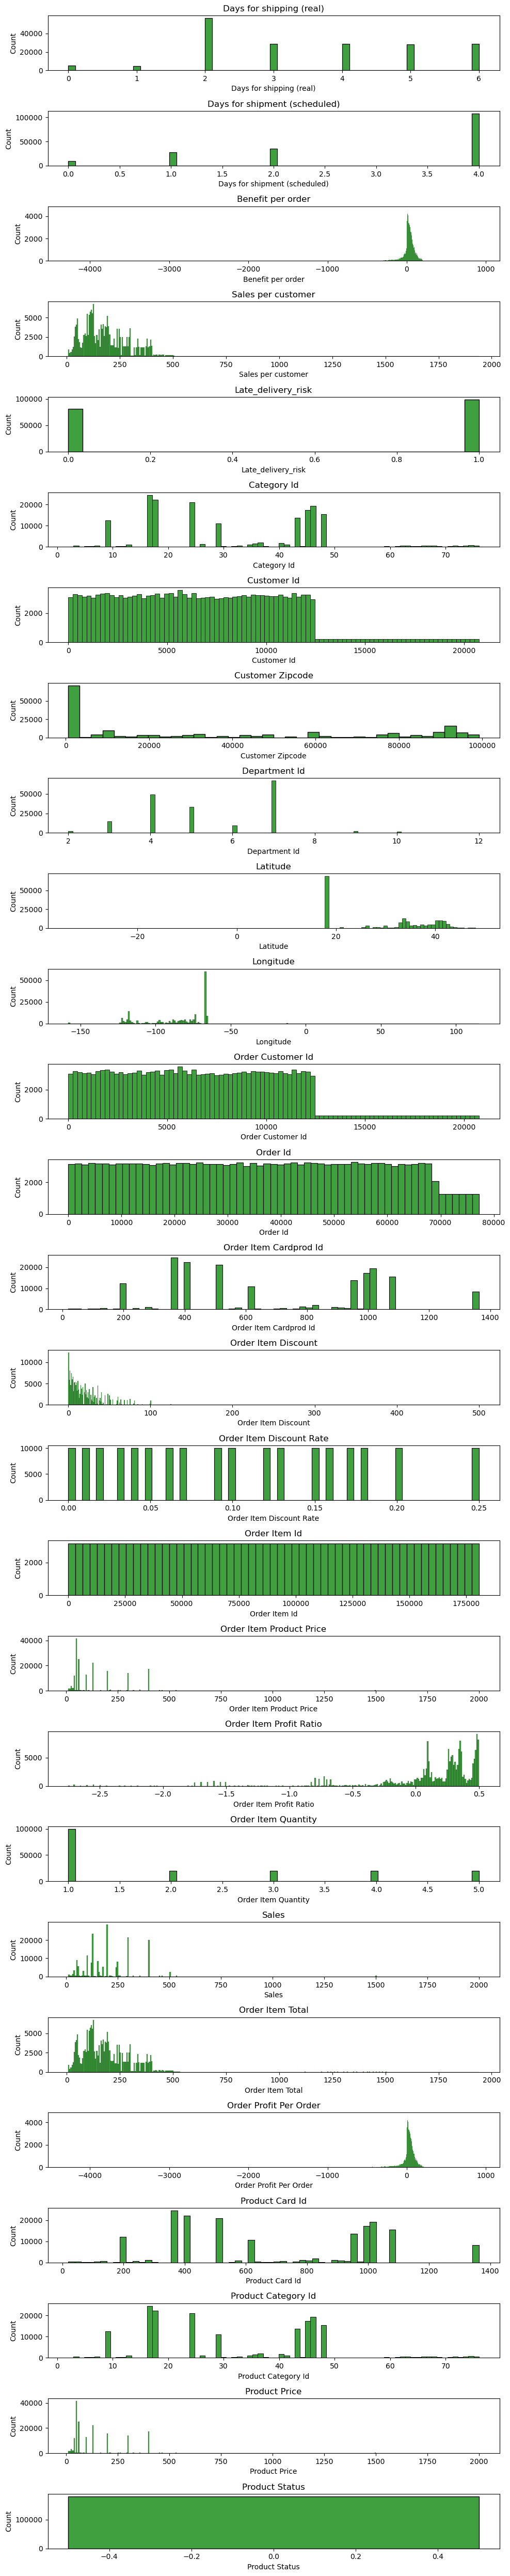

In [31]:
#Floating the numerical columns are histplot
plt.figure(figsize=(10,50))
re=1
for i in df_num.columns:
    plt.subplot(27,1,re)
    sns.histplot(x=df_num[i], color='green')
    plt.title(i)
    re+=1
plt.tight_layout()
plt.show

The analysis of numerical plots gives the following conclusions

* the days for shipping real  is highest at 2 days. 

* the days of shipments Scheduled is highest at 4 days.

*  there is the distribution method in sales per customer

* the late delivery risk has to categories which is zero and one

* the category ID is an encotted colum which you top around 18

* the repetition of the customer ID shows that there are customers who brought items repeatedly.

* there is a customer is it good which buys things repeatedly.

*  some department have more buyer than the other departments.

* The order item product price peaks around 50 and order item profit ratio shows their could be for possible cluster in the profit ratio.

* the order item quantity pics at one item per order

* the sales takes in between 100 and 250

* the product price pics in between zero and hundred.

* the product status column has only one value so it can be dropped

In [32]:
for i in df_cat.columns:
    print(i, df_cat[i].nunique())

Type 4
Delivery Status 4
Category Name 50
Customer City 563
Customer Country 2
Customer Fname 782
Customer Lname 1109
Customer Segment 3
Customer State 46
Customer Street 7458
Department Name 11
Market 5
Order City 3597
Order Country 164
order date (DateOrders) 65752
Order Region 23
Order State 1089
Order Status 9
Product Name 118
shipping date (DateOrders) 63701
Shipping Mode 4


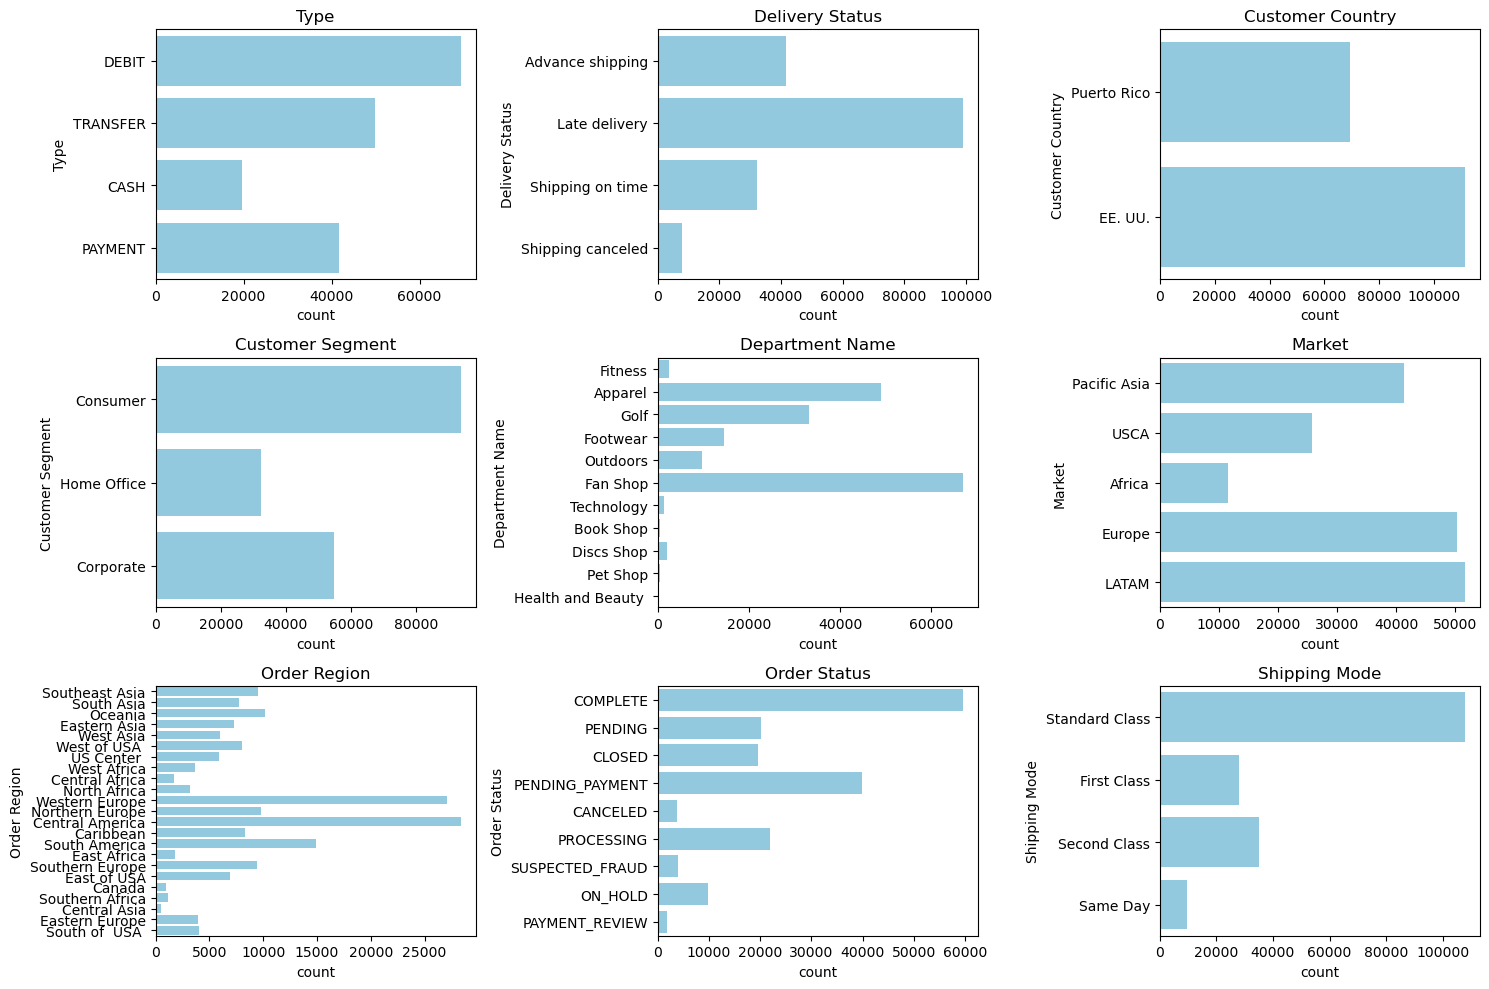

In [33]:
# analysing columns with less unique values in categorical columns.
plt.figure(figsize=(15,10))
re=1
for i in ['Type','Delivery Status','Customer Country','Customer Segment',
          'Department Name','Market','Order Region','Order Status','Shipping Mode']:
    plt.subplot(3,3,re)
    sns.countplot(y=df_cat[i], color='skyblue')
    plt.title(i)
    re+=1
plt.tight_layout()
plt.show()

The following points can be concluded from the categorical columns

* that type has four categories in it debit transfer cash payment in which debit has the highest count followed by payment transfer and cash.

* the customer segment Kolam has three categories in IT consumer which has the highest account followed by corporate and home office.

*  the order region has 23 categories in it which is says from which region the order has been made. Among the 23 categories  Central America has the highest orders placed followed by western Europe, South America, South Europe etc.

* the order status column has Nayan categories in which complete has the highest account followed by pending payment.  In the categories payment review and cancelled has the lowest account.

*  in the department name fan shop has the highest account which mean most of the orders are placed in related to fan shop followed by apparel and golf.  The law was to count is in health and beauty. 

* The delivery status column has four categories in it which are, advance shipping, late delivery, shipping on time and shipping cancelled,  late delivery peaks.

* In the customer country has only two countries.

* the market feature has 5 categories in it in which  latam and Europe has the highest account

* the shipping mode column has four categories in it among standard class shipping mode has the highest count

### Bivariate analysis

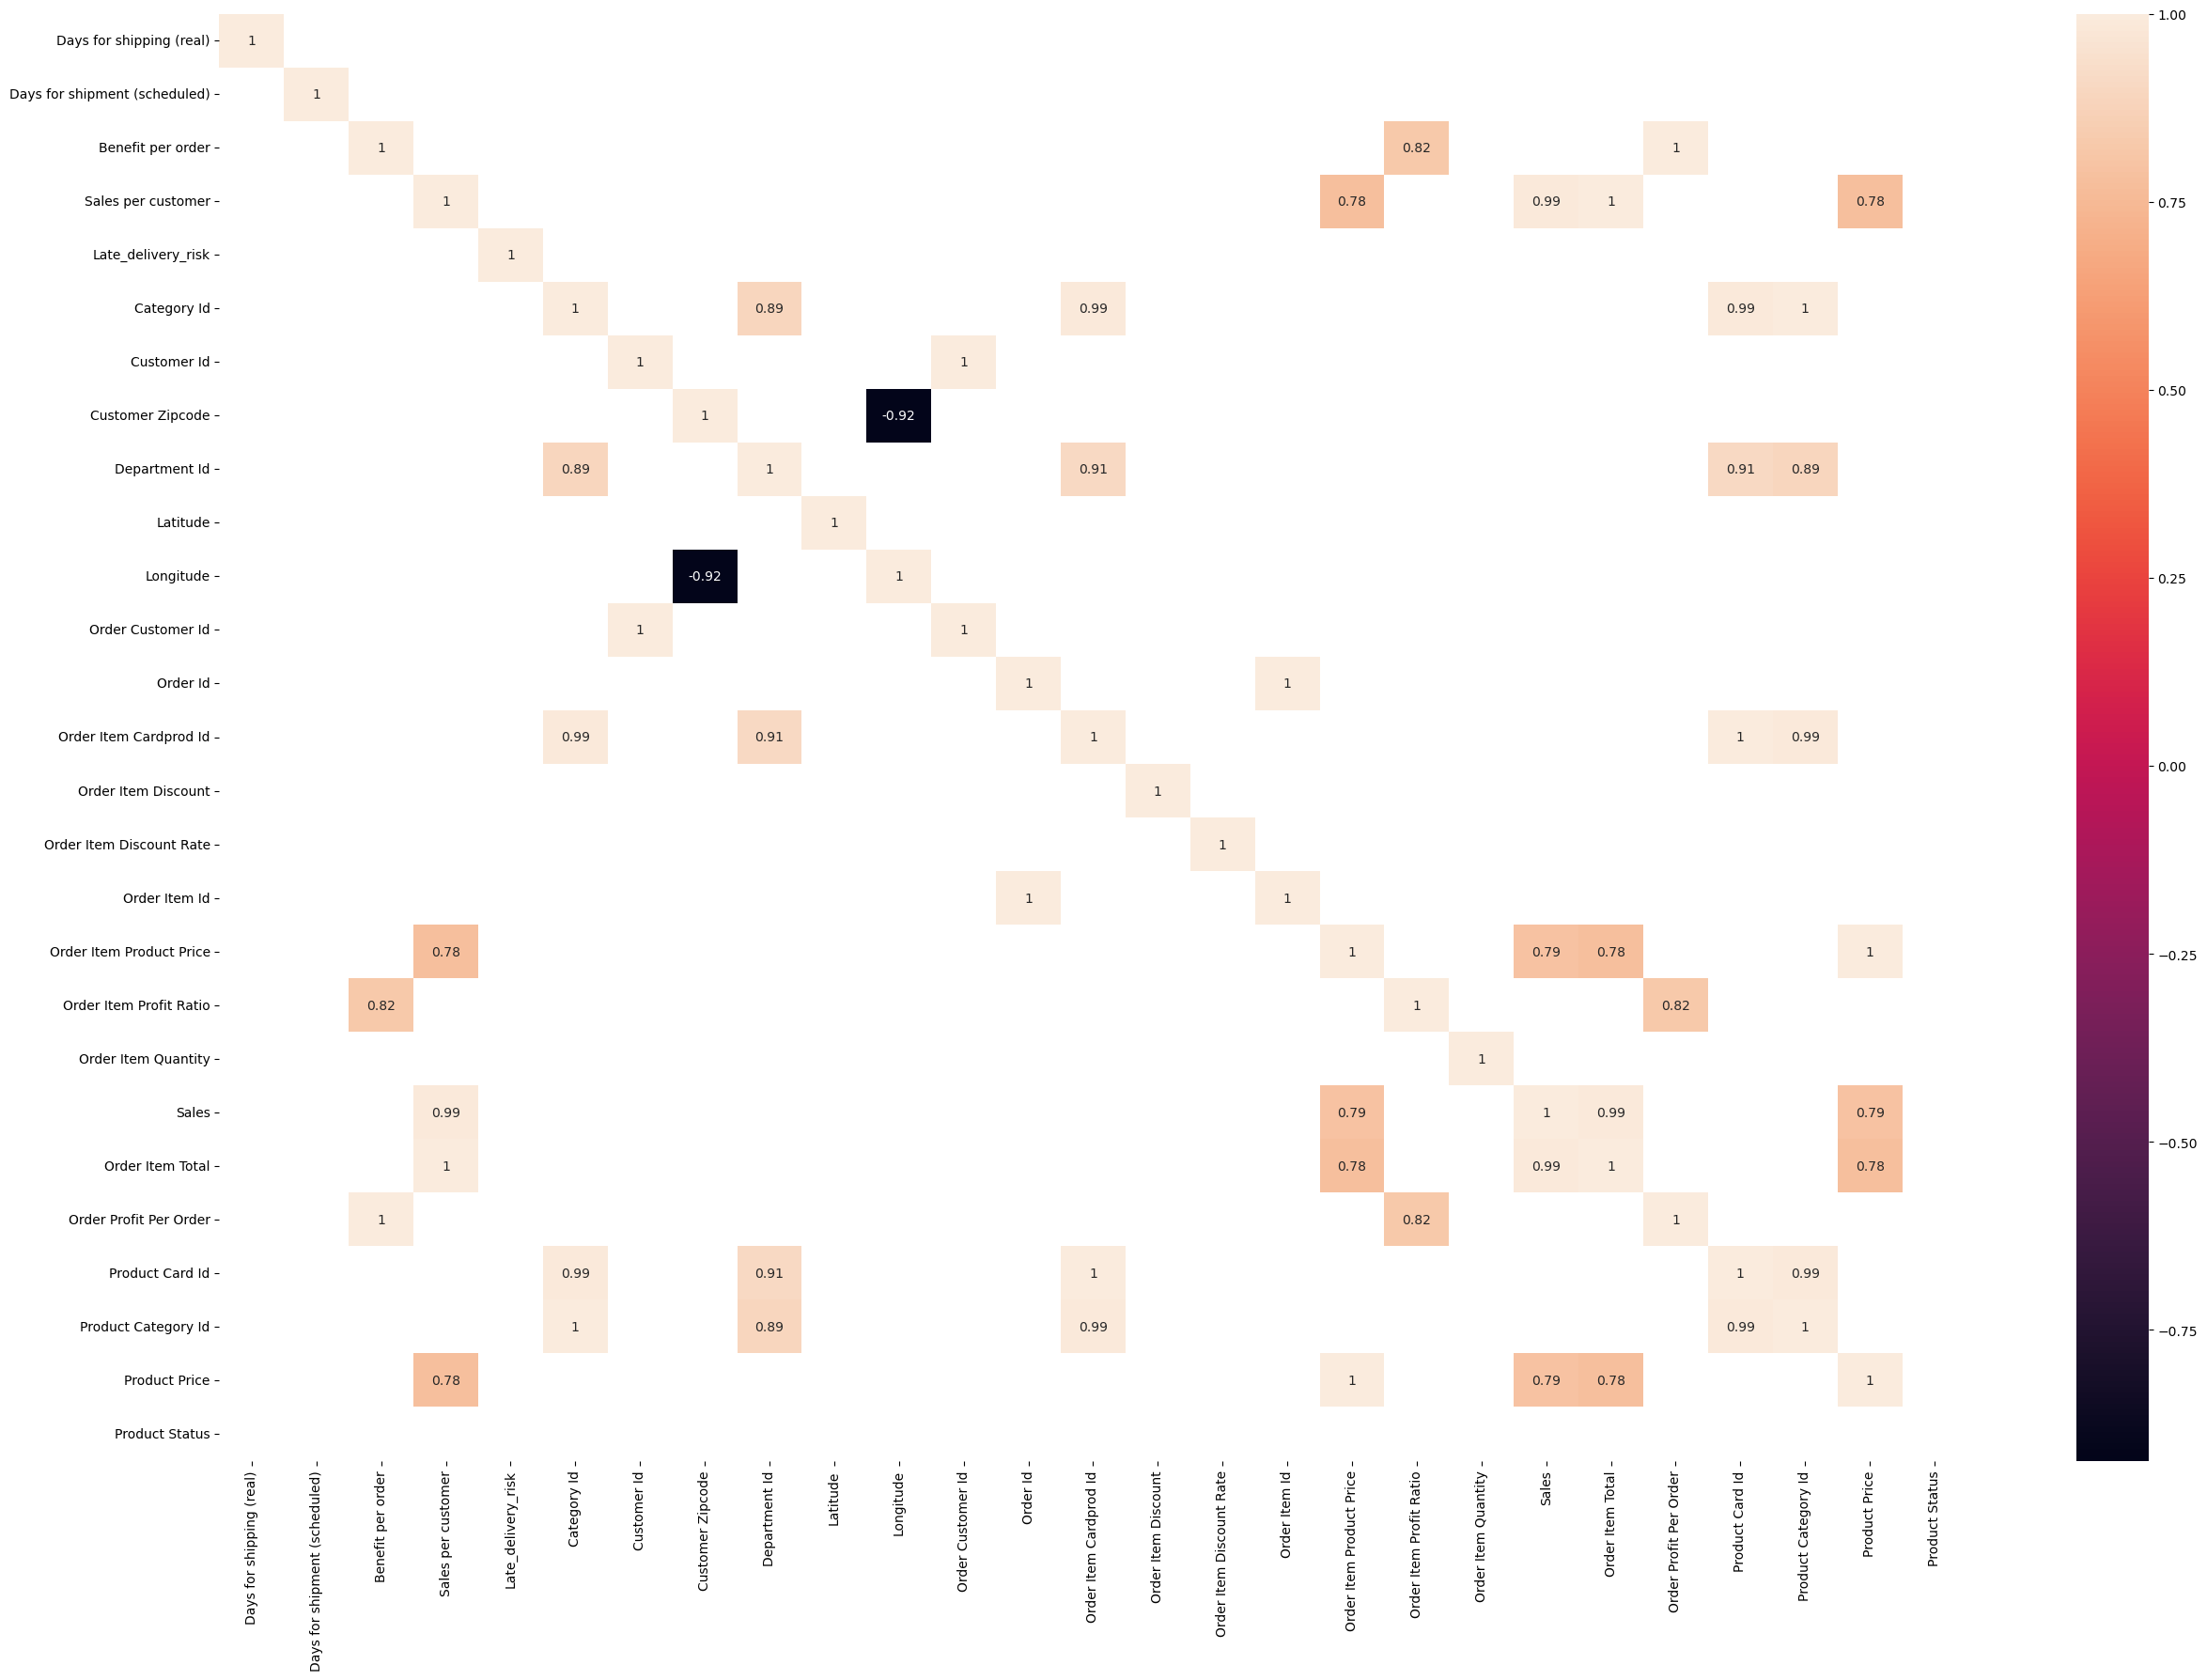

In [34]:
plt.figure(figsize=(30,20))
sns.heatmap(df_num.corr()[(abs(df_num.corr())>0.75)], annot=True)
plt.show()

From the correlation matrix we can have the conclusions



*  there are certain columns  which shows correlation of 1 they are  product category ID and category ID,  order profit per order and benefit per order,  order item total and sales per customer,  product card ID and order item card product ID,  product price and order item product price,  order ID and order item ID,  order customer ID and customer ID. 

*  The Other columns has high correlation about 95 percentage is   sales and sales per customer,  product carved ID and category ID, product category ID and order item card prod ID,  category ID and order item card prod ID. 

*  there are many other features which are correlated about .75.



From the analysis of heat map it is clear that the data set features are highly correlated and have to be treated.  

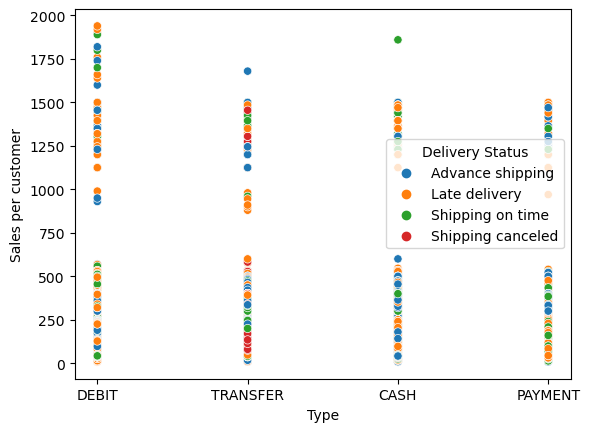

In [35]:
sns.scatterplot(data=df, y='Sales per customer', x='Type', hue="Delivery Status")
plt.show()

From this scatter plot is clear that the sales per customer is not dependent on the type of payment  method. 

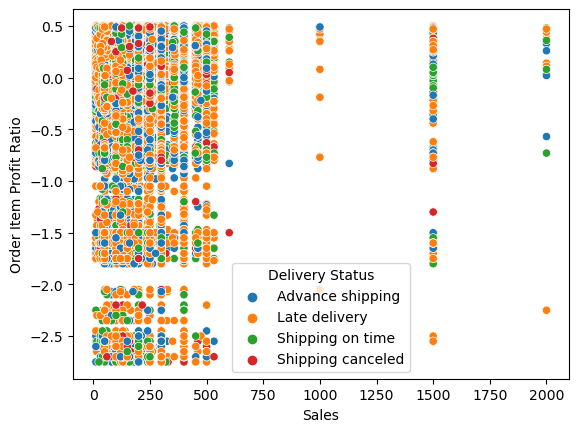

In [36]:
sns.scatterplot(data=df, x='Sales', y='Order Item Profit Ratio', hue='Delivery Status')
plt.show()

Delivery Status and Late Delivery Risk

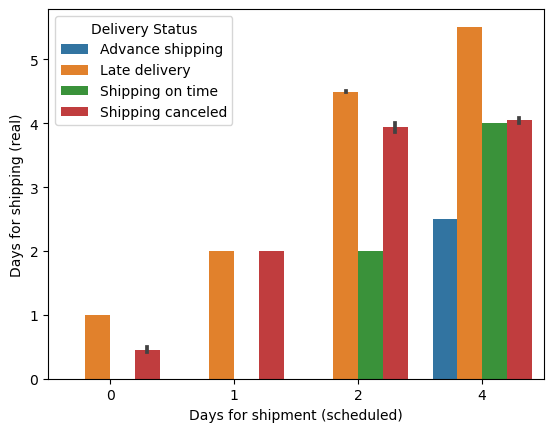

In [37]:
sns.barplot(data=df, y='Days for shipping (real)', x='Days for shipment (scheduled)',hue='Delivery Status')
plt.show()

The days of shipment scheduled is zero then there is a late then delivery risk.

If the days of shipment scheduled is one the delivery status to be late delivery or cancelled is equal. 

If the days of shipment scheduled is two then there is a chance of days of shipping real is also two.

If the days of shipment schedule is to then the late delivery risk is there long with shipment cancelled. 

If the days of delivery schedule is 4  then there is a possibility of advance shipping which is not seen in other days of shipment schedule.

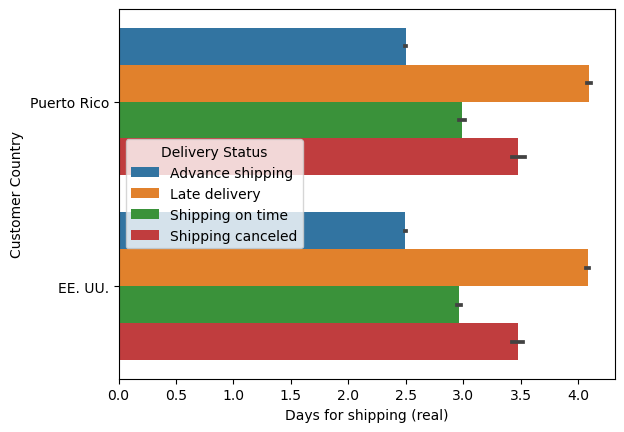

In [38]:
sns.barplot(data=df, y='Customer Country', x='Days for shipping (real)',hue='Delivery Status')
plt.show()

The delivery status and days of shipping real similar in both of the customer country.

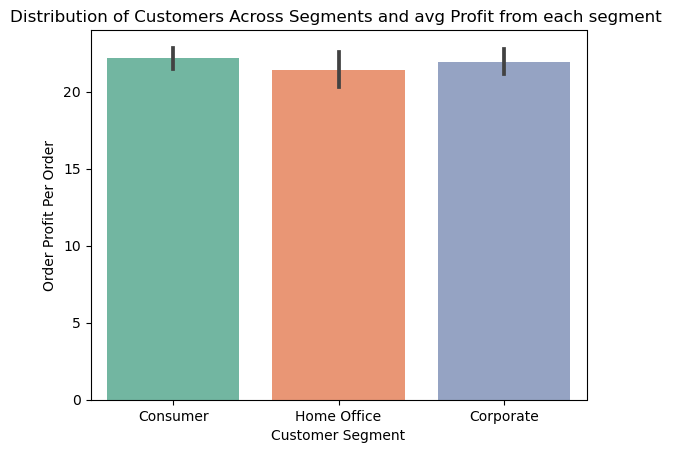

In [39]:
sns.barplot(x='Customer Segment', y='Order Profit Per Order',data=df, palette='Set2')  
plt.title('Distribution of Customers Across Segments and avg Profit from each segment ')
plt.xlabel('Customer Segment')
plt.show()

The average profit from consumer segment in little higher than the other two segments

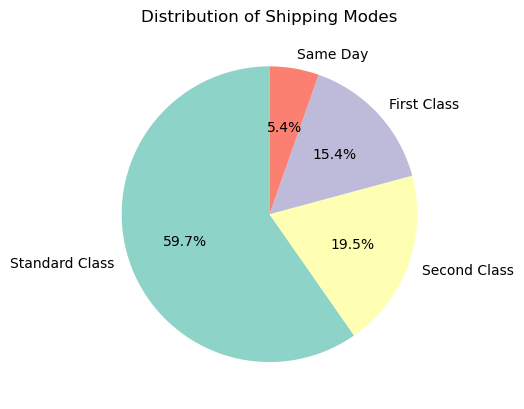

In [40]:
plt.pie(df['Shipping Mode'].value_counts(), labels=df['Shipping Mode'].value_counts().index, 
        autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Distribution of Shipping Modes')
plt.show()

59.7 percentage of the orders of for standard class shipping notes while 19.5 percentage choses 2nd class shipping mode and 15.24% choses first class shipping mode and 5.4 percentage. 

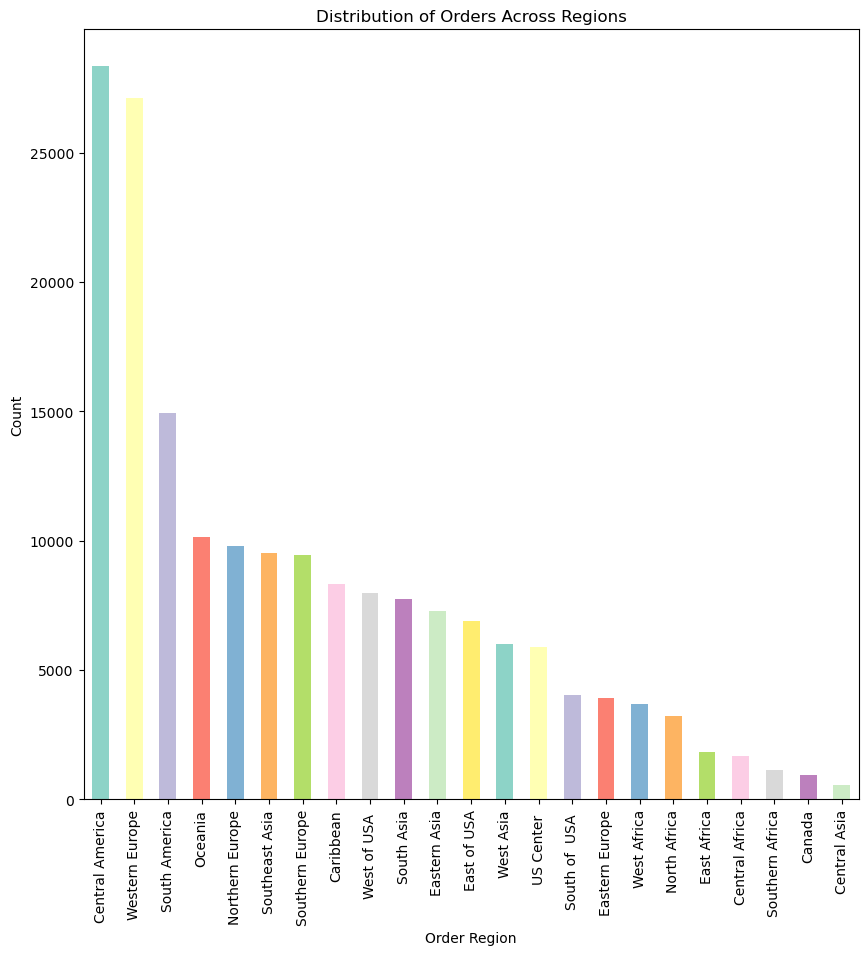

In [21]:
plt.figure(figsize=(10,10))
df['Order Region'].value_counts().plot(kind='bar', color=plt.cm.Set3.colors)  
plt.title('Distribution of Orders Across Regions')
plt.xlabel('Order Region')
plt.ylabel('Count')
plt.show()

15.7 percentage of the Total Orders are from Central America and 15% of the orders are from Western Europe while the remaining orders are distributed all over the world. 

### Feature Engineering

In [42]:
date=[]
month=[]
year=[]
time=[]
def date_time(timestamp):
    global date,month,year,time
    x=timestamp.split(" ")[0]
    time.append(int(timestamp.split(" ")[1].split(":")[0]))
    month.append(int(x.split("/")[0]))
    date.append(int(x.split("/")[1]))
    year.append(int(x.split("/")[2]))

In [43]:
df["order date (DateOrders)"].apply(date_time)

0         None
1         None
2         None
3         None
4         None
          ... 
180514    None
180515    None
180516    None
180517    None
180518    None
Name: order date (DateOrders), Length: 180519, dtype: object

In [44]:
df["Order Date"]=date
df["Order Month"]=month
df["Order Year"]=year
df["Order Time"]=time

In [45]:
def timing(time):
    if (time>=6) & (time<12):
        return "Morining"
    elif (time>=12) & (time<17):
        return "Afternoon"
    elif (time>=17) & (time<21):
        return "Evening"
    elif (time>=21) | (time<6):
        return "Night"

In [46]:
df["Order Time"] = df["Order Time"].apply(timing)

In [47]:
df[["order date (DateOrders)","Order Date","Order Month","Order Year","Order Time"]].head()

,order date (DateOrders),Order Date,Order Month,Order Year,Order Time
0,1/31/2018 22:56,31,1,2018,Night
1,1/13/2018 12:27,13,1,2018,Afternoon
2,1/13/2018 12:06,13,1,2018,Afternoon
3,1/13/2018 11:45,13,1,2018,Morining
4,1/13/2018 11:24,13,1,2018,Morining


In [48]:
df.drop("order date (DateOrders)",axis=1,inplace=True)

In [49]:
date=[]
month=[]
year=[]
time=[]
df["shipping date (DateOrders)"].apply(date_time)

0         None
1         None
2         None
3         None
4         None
          ... 
180514    None
180515    None
180516    None
180517    None
180518    None
Name: shipping date (DateOrders), Length: 180519, dtype: object

In [50]:
df["Shipping Date"]=date
df["Shipping Month"]=month
df["Shipping Year"]=year
df["Shipping Time"]=time

In [51]:
df["Shipping Time"] = df["Shipping Time"].apply(timing)

In [52]:
df[["shipping date (DateOrders)","Shipping Date","Shipping Month","Shipping Year","Shipping Time"]].head()

,shipping date (DateOrders),Shipping Date,Shipping Month,Shipping Year,Shipping Time
0,2/3/2018 22:56,3,2,2018,Night
1,1/18/2018 12:27,18,1,2018,Afternoon
2,1/17/2018 12:06,17,1,2018,Afternoon
3,1/16/2018 11:45,16,1,2018,Morining
4,1/15/2018 11:24,15,1,2018,Morining


In [53]:
df.drop("shipping date (DateOrders)",axis=1,inplace=True)

In [54]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,0,Standard Class,31,1,2018,Night,3,2,2018,Night
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Afternoon,18,1,2018,Afternoon
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.719999,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Afternoon,17,1,2018,Afternoon
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,75937,1360,22.940001,0.07,179252,327.75,0.07,1,327.75,304.809999,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Morining,16,1,2018,Morining
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Morining,15,1,2018,Morining


In [55]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer Segment', 'Customer State', 'Customer Street',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude',
       'Longitude', 'Market', 'Order City', 'Order Country',
       'Order Customer Id', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Product Status', 'Shipping Mode', 'Order Date',
       'Order Month

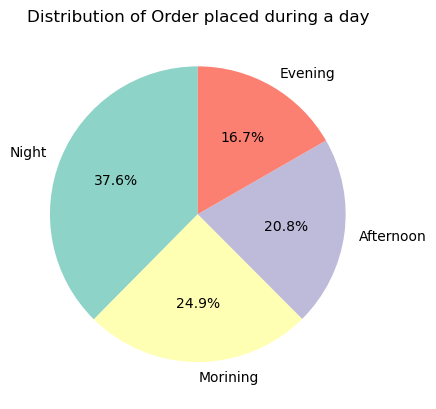

In [56]:
plt.pie(x=df["Order Time"].value_counts(),labels=df["Order Time"].value_counts().index, 
            autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)  
plt.title('Distribution of Order placed during a day')
plt.show()

37.6% percentage of the orders are placed at night followed by 25% of orders in morning and 20.8% of orders in afternoon.  Evening show the lowest placement of orders with 16.7%. 

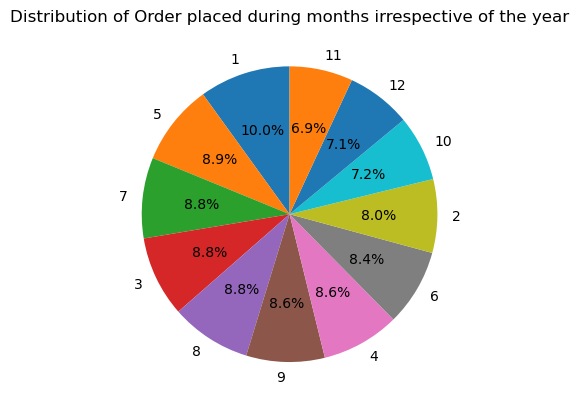

In [57]:
plt.pie(x=df["Order Month"].value_counts(),labels=df["Order Month"].value_counts().index, 
            autopct='%1.1f%%', startangle=90)  
plt.title('Distribution of Order placed during months irrespective of the year')
plt.show()

The  percentage of Orders that are placed is high in January and low in November according to this data set. 

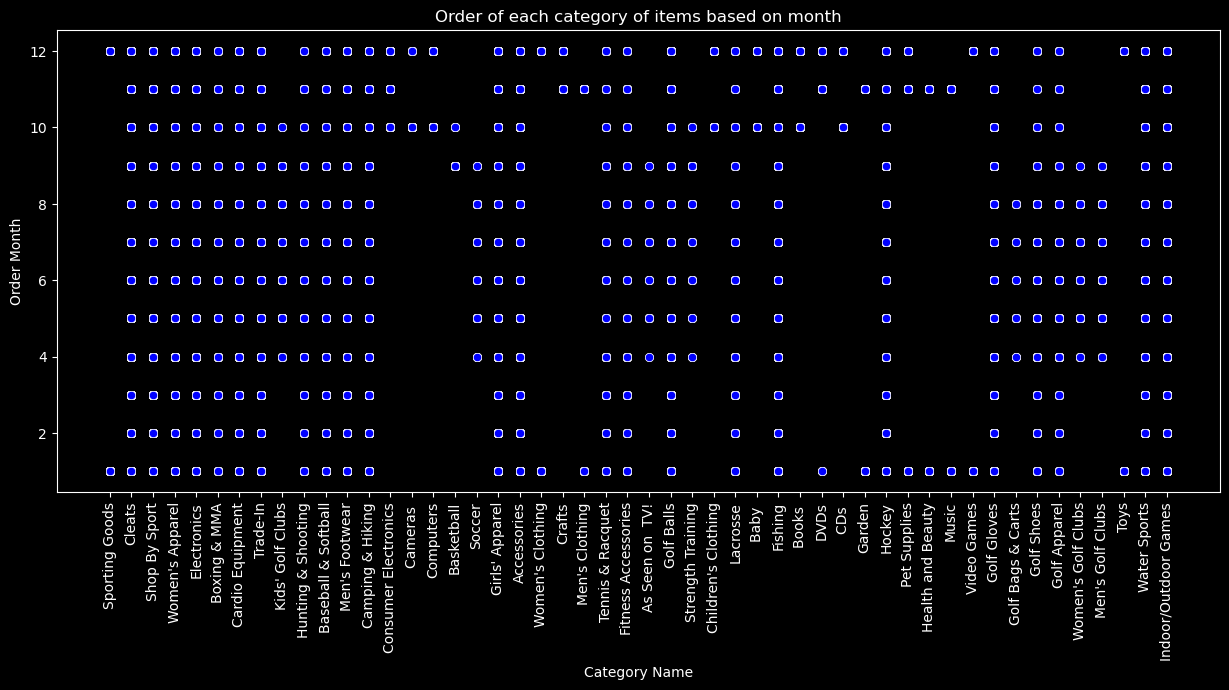

In [58]:
plt.style.use('dark_background')
plt.figure(figsize=(15,6))
sns.scatterplot(x=df["Category Name"], y=df["Order Month"], color='blue')
plt.title('Order of each category of items based on month')
plt.xticks(rotation=90)
plt.show()

* Girls apparels, accessories,  Golf balls, tennis and racquet, Fitness accessories  lacrosse,  fishing, hockey, gold gloves, gold shoes ,Golf apparel, water sports, indoor outdoor games have orders in all months. 
* Consumer electronics shows no sales  from January to September and have sales in the remaining months.
* Cameras computers shop the same pattern of orders where both have sales only in October and December. 
* Basketball has orders only in September and October. 
* Saccer  has no orders from January to March and October to December. 
* Sporting goods  have sales only in the month of December and January. 
* Kids golf club category  do not have any sales in January February March  November and December. 
* Crafts craft has only sales during November and December. 
* Mens clothing has sales only in January and November. 
* As scene on TV category house sales from April to september. 
* Strength training has sales from April to october. 
* Children's clothing has sales only during October and December.
* books  have fails only during November and December. 
* DVD CD supplies health and beauty music video games or has only 3 months of sales from November, December  to next year Jan. 

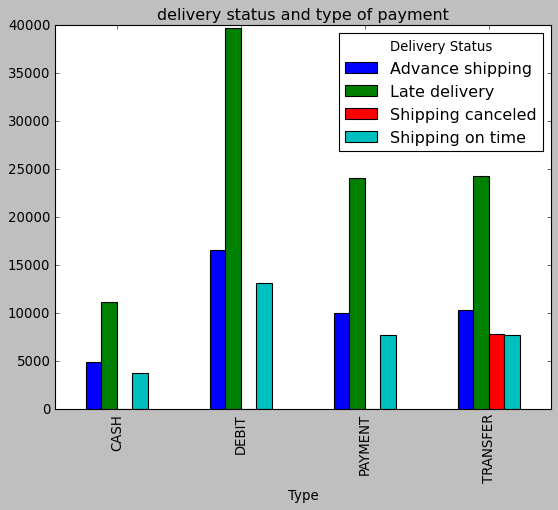

In [59]:
plt.style.use("classic")
pd.crosstab(df["Type"], df["Delivery Status"]).plot(kind="bar")
plt.title("delivery status and type of payment")
plt.show()

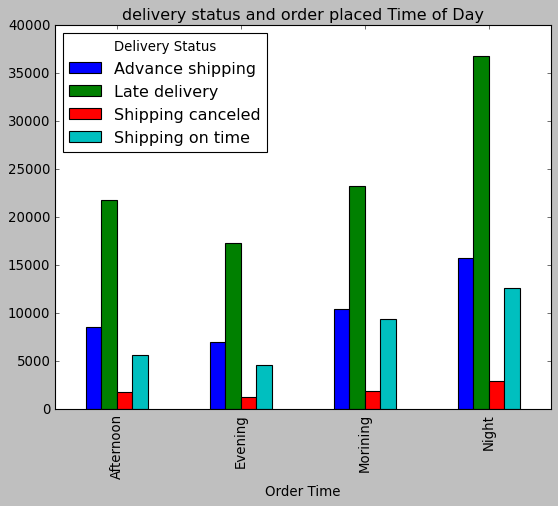

In [60]:
plt.style.use("classic")
pd.crosstab(df["Order Time"], df["Delivery Status"]).plot(kind="bar")
plt.title("delivery status and order placed Time of Day")
plt.show()

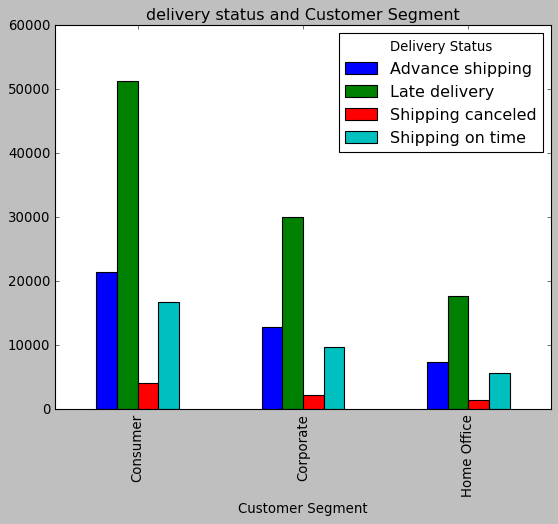

In [61]:
plt.style.use('classic')
pd.crosstab(df['Customer Segment'], df['Delivery Status']).plot(kind='bar')
plt.title('delivery status and Customer Segment')
plt.show()

From the graphs the late delivery is high when the payment is debit. 

The late delivery count is high when the orders are placed at night. 

If the customer segment is consumer then the count of late delivery is high. 

The shipping cancelled delivery status is present only transfer type of payments.

In [ ]:
name = {"K'ut'aisi":"Kutaisi","Kryvyy Rih":"Kryvyi Rih","Kahramanmara?":"Kahramanmaras","Thies Nones":"Thies",
        "Klaip?da":"klaipeda","Aew?l-li":"aewol","Usol'ye-Sibirskoye":"Usolye-Sibirskoye",
       "Fresnillo de González Echeverría":"Fresnillo","Kafr ad Dawwar":"Kafr El-Dawar","Bene Beraq":"Bnei Brak",
       "Berdyans'k":"Berdyansk","Dzhezkazgan":"Jezkazgan"}

In [63]:
len(name)

12

In [65]:
df["Order City"] = df["Order City"].replace(name)

In [ ]:
loc = {}

In [102]:
for i in df["Order City"].unique():
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.geocode(i)
    loc[i]=[location.latitude,location.longitude]

In [118]:
for i in loc:
    loc[i] = str(loc[i])

In [161]:
loca = df["Order City"].replace(loc).str.strip("[]")

In [179]:
def split(x):
    lat = float(x.split(",")[0])
    long = float(x.split(",")[1])
    return (lat,long)

In [180]:
order_loca = loca.apply(split)

In [195]:
df["Order Location"] = order_loca

In [190]:
def merge(x):
    return (x.loc["Latitude"],x.loc["Longitude"])

In [197]:
df["Store Location"] = df.apply(merge,axis=1)

In [200]:
def dist(x):
    return geopy.distance.geodesic(x["Order Location"],x["Store Location"]).km

In [214]:
df["Distance(KM)"] = df.apply(dist,axis=1)

In [215]:
df["Distance(KM)"].mean()

7409.350931830826

In [ ]:
df.to_csv('SupplyChainDataset.csv', index=False)

In [36]:
df = pd.read_csv(r"C:\Users\Windows 10 Pro\cap\SupplyChainDataset.csv")

In [37]:
df.shape

(180519, 55)

In [38]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,0,Standard Class,31,1,2018,Night,3,2,2018,Night,18481.922336
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Afternoon,18,1,2018,Afternoon,13278.496831
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.719999,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Afternoon,17,1,2018,Afternoon,12603.663952
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,75937,1360,22.940001,0.07,179252,327.75,0.07,1,327.75,304.809999,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Morining,16,1,2018,Morining,11625.195512
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Morining,15,1,2018,Morining,16572.070499


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Fname                 180519 non-null  object 
 12  Customer Id                   

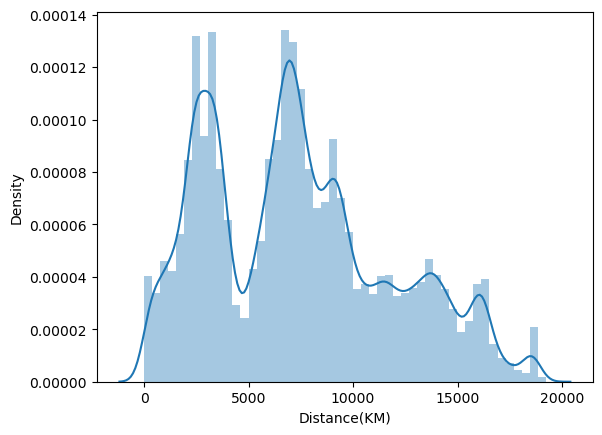

In [66]:
sns.distplot(df["Distance(KM)"])
plt.show()

In [67]:
df["Distance(KM)"].describe()

count    180519.000000
mean       7409.350932
std        4427.176723
min           0.662699
25%        3449.892589
50%        6975.340454
75%       10068.810328
max       19221.118564
Name: Distance(KM), dtype: float64

* The minimum distance between the store and a delivery location is 0.66 KM and the maximum distance is 19221.11 KM

In [68]:
df = df.drop(["Order Location","Store Location"],axis=1)

In [69]:
df.shape

(180519, 55)

* Checking for outliers after all EDA and Feature Engineering

In [8]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
ll = q1-(1.5*iqr)
ul = q3+(1.5*iqr)

In [9]:
print("Number of Outlier Rows:",len(df[((df<ll) | (df>ul)).any(axis=1)]))
print("Number of non Outlier Rows:",len(df[~((df<ll) | (df>ul)).any(axis=1)]))
print("Total number of rows:",len(df))

Number of Outlier Rows: 32495
Number of non Outlier Rows: 148024
Total number of rows: 180519


In [10]:
print("Percentage of Outlier Rows:",(len(df[((df<ll) | (df>ul)).any(axis=1)])/len(df))*100)
print("Percentage of non Outlier Rows:",(len(df[~((df<ll) | (df>ul)).any(axis=1)])/len(df))*100)

Percentage of Outlier Rows: 18.000875254128374
Percentage of non Outlier Rows: 81.99912474587163


In [40]:
df = df[~(df["Delivery Status"]=="Shipping canceled")].reset_index(drop=True)
df["Delivery Status"] = df["Delivery Status"].replace({"Advance shipping":"Shipping on time"})
df

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,DEBIT,3,4,91.250000,314.640015,Shipping on time,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.750000,0,Standard Class,31,1,2018,Night,3,2,2018,Night,18481.922336
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Afternoon,18,1,2018,Afternoon,13278.496831
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.719999,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Afternoon,17,1,2018,Afternoon,12603.663952
3,DEBIT,3,4,22.860001,304.809998,Shipping on time,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,75937,1360,22.940001,0.07,179252,327.750000,0.07,1,327.750000,304.809999,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Morining,16,1,2018,Morining,11625.195512
4,PAYMENT,2,4,134.210007,298.250000,Shipping on time,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Morining,15,1,2018,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172760,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,Maria,1005,Peterson,Home Office,NY,1322 Broad Glade,11207.0,7,Fan Shop,40.640930,-73.942711,Pacific Asia,Shanghái,China,1005,26043,1004,0.000000,0.00,65177,399.980011,0.10,1,399.980011,399.980011,40.000000,Eastern Asia,Shanghái,CLOSED,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,Standard Class,16,1,2016,Night,20,1,2016,Night,11890.757350
172761,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,EE. UU.,Ronald,9141,Clark,Corporate,CA,7330 Broad Apple Moor,93304.0,7,Fan Shop,35.362545,-119.018700,Pacific Asia,Hirakata,Japón,9141,26037,1004,4.000000,0.01,65161,399.980011,-1.55,1,399.980011,395.980011,-613.770019,Eastern Asia,Osaka,COMPLETE

In [41]:
df["Delivery Status"].unique()

array(['Shipping on time', 'Late delivery'], dtype=object)

In [158]:
df.to_csv('SupplyChainDataset.csv', index=False)

In [2]:
df=pd.read_csv(r"C:\Users\Windows 10 Pro\cap\SupplyChainDataset.csv")

In [3]:
df

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,DEBIT,3,4,91.250000,314.640015,Shipping on time,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.750000,0,Standard Class,31,1,2018,Night,3,2,2018,Night,18481.922336
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Afternoon,18,1,2018,Afternoon,13278.496831
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.719999,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Afternoon,17,1,2018,Afternoon,12603.663952
3,DEBIT,3,4,22.860001,304.809998,Shipping on time,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,75937,1360,22.940001,0.07,179252,327.750000,0.07,1,327.750000,304.809999,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Morining,16,1,2018,Morining,11625.195512
4,PAYMENT,2,4,134.210007,298.250000,Shipping on time,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.750000,0,Standard Class,13,1,2018,Morining,15,1,2018,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172760,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,Maria,1005,Peterson,Home Office,NY,1322 Broad Glade,11207.0,7,Fan Shop,40.640930,-73.942711,Pacific Asia,Shanghái,China,1005,26043,1004,0.000000,0.00,65177,399.980011,0.10,1,399.980011,399.980011,40.000000,Eastern Asia,Shanghái,CLOSED,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,Standard Class,16,1,2016,Night,20,1,2016,Night,11890.757350
172761,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,EE. UU.,Ronald,9141,Clark,Corporate,CA,7330 Broad Apple Moor,93304.0,7,Fan Shop,35.362545,-119.018700,Pacific Asia,Hirakata,Japón,9141,26037,1004,4.000000,0.01,65161,399.980011,-1.55,1,399.980011,395.980011,-613.770019,Eastern Asia,Osaka,COMPLETE

In [4]:
df["Delivery Status"].unique()

array(['Shipping on time', 'Late delivery'], dtype=object)

### EDA CONCLUSIONS

### The analysis of numerical plots gives the following conclusions\
    the days for shipping real is highest at 2 days.
    the days of shipments Scheduled is highest at 4 days.
    there is the distribution method in sales per custome
    the late delivery risk has to categories which is zero and one
    the category ID is an encotted colum which you top around 18
    the repetition of the customer ID shows that there are customers who brought items repeatedly.
    there is a customer is it good which buys things repeatedly.
    some department have more buyer than the other departments.
    THe order item product price peaks around 50 and order item profit ratio shows their could be for possible cluster in the profit ratio.
    the order item quantity pics at one item per order
    the sales takes in between 100 and 250
    the product price pics in between zero and hundred.
    the product status column has only one value so it can be dropped


### The following points can be concluded from the categorical columns
    that type has four categories in it debit transfer cash payment in which debit has the highest count followed by payment transfer and cash.
    the customer segment Kolam has three categories in IT consumer which has the highest account followed by corporate and home office.
    the order region has 23 categories in it which is says from which region the order has been made. Among the 23 categories Central America has the highest orders placed followed by western Europe, South America, South Europe etc.
    the order status column has Nayan categories in which complete has the highest account followed by pending payment. In the categories payment review and cancelled has the lowest account.
    in the department name fan shop has the highest account which mean most of the orders are placed in related to fan shop followed by apparel and golf. The law was to count is in health and beauty.
    The delivery status column has four categories in it which are, advance shipping, late delivery, shipping on time and shipping cancelled, late delivery peaks.
    In the customer country has only two countries.
    the market feature has 5 categories in it in which latam and Europe has the highest account
    the shipping mode column has four categories in it among standard class shipping mode has the highest count
    There is 18% Outliers in the data
    
###### 15.7 percentage of the Total Orders are from Central America and 15% of the orders are from Western Europe while the remaining orders are distributed all over the world.

###### the late delivery count is high when the orders are placed at night.

###### If the customer segment is consumer then the count of late delivery is high.

###### The shipping cancelled delivery status is present only transfer type of payments.

### Creating Userdefined Function

In [4]:
def model_cal(model_df,model_name,model,x,y):
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.20,random_state=10,shuffle=True)
    model.fit(xtrain,ytrain)
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    train_acc = accuracy_score(ytrain,ypred_train)
    train_f1 = f1_score(ytrain,ypred_train)
    train_rec = recall_score(ytrain,ypred_train)
    train_pres = precision_score(ytrain,ypred_train)
    test_acc = accuracy_score(ytest,ypred_test)
    test_f1 = f1_score(ytest,ypred_test)
    test_rec = recall_score(ytest,ypred_test)
    test_pres = precision_score(ytest,ypred_test)
    model_df.loc[model_name,:]=[train_acc,train_f1,train_rec,train_pres,test_acc,test_f1,test_rec,test_pres]
    print(classification_report(ytrain,ypred_train))
    print(classification_report(ytest,ypred_test))
    return model_df

### 1. Base Model with all features

#### Encoding

In [51]:
base_df = df.copy()

In [52]:
for i in base_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    base_df[i] = le.fit_transform(base_df[i])

In [53]:
label = {"Shipping on time":0,"Late delivery":1}
base_df["Delivery Status"] = base_df["Delivery Status"].replace(label)

#### Splitting Target and Variables

In [54]:
base_x = base_df.drop("Delivery Status",axis=1)
base_y = base_df["Delivery Status"]

### Model Building with all features

In [55]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
base_model_score = pd.DataFrame(columns=col)
base_model_score.index.name = "Model Name"

#### Logistic Regression

In [57]:
lr = LogisticRegression(random_state=10)
model_cal(base_model_score,"Logistic Regression",lr,base_x,base_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     59025
           1       0.57      1.00      0.73     79187

    accuracy                           0.57    138212
   macro avg       0.29      0.50      0.36    138212
weighted avg       0.33      0.57      0.42    138212

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14763
           1       0.57      1.00      0.73     19790

    accuracy                           0.57     34553
   macro avg       0.29      0.50      0.36     34553
weighted avg       0.33      0.57      0.42     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   

                                                
                     F1 Score Recall Precision  
Model Name                                      
Logistic Regression  0.728337    1.0  0.572743

#### Decision Tree

In [58]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(base_model_score,"Decision Tree",dt,base_x,base_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   
Decision Tree             1.0       1.0       1.0       1.0       1.0   

                                                
                     F1 Score Recall Precision  
Model Name                                      
Logistic Regression  0.728337    1.0  0.572743  
Decision Tree             1.0    1.0       1.0

#### Random Forest

In [59]:
rf = RandomForestClassifier(random_state=10)
model_cal(base_model_score,"Random Forest",rf,base_x,base_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   

                                                
                     F1 Score Recall Precision  
Model Name                                      
Logistic Regression  0.728337    1.0  0.572743  
Decision Tree             1.0    1.0       1.0  
Random Forest             1.0    1.0       1.0

#### GaussianNB

In [60]:
gnb = GaussianNB()
model_cal(base_model_score,"GaussianNB",gnb,base_x,base_y)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     59025
           1       0.95      0.98      0.96     79187

    accuracy                           0.96    138212
   macro avg       0.96      0.95      0.96    138212
weighted avg       0.96      0.96      0.96    138212

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     14763
           1       0.95      0.98      0.97     19790

    accuracy                           0.96     34553
   macro avg       0.96      0.96      0.96     34553
weighted avg       0.96      0.96      0.96     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB           0.957457  0.963567  0.981929  0.945879  0.960264   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.728337       1.0  0.572743  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB           0.965899  0.982567  0.949788

#### Gradient Boosting

In [61]:
gb = GradientBoostingClassifier()
model_cal(base_model_score,"Gradient Boosting",gb,base_x,base_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB           0.957457  0.963567  0.981929  0.945879  0.960264   
Gradient Boosting         1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.728337       1.0  0.572743  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB           0.965899  0.982567  0.949788  
Gradient Boosting         1.0       1.0       1.0

#### XGBClassifier

In [62]:
xgb = XGBClassifier()
model_cal(base_model_score,"XGBClassifier",xgb,base_x,base_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.572931  0.728489  0.999987  0.572936  0.572743   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB           0.957457  0.963567  0.981929  0.945879  0.960264   
Gradient Boosting         1.0       1.0       1.0       1.0       1.0   
XGBClassifier             1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.728337       1.0  0.572743  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB           0.965899  0.982567  0.949788  
Gradient Boosting         1.0       1.0       1.0  
XGBClassifier             1.0       1.0       1.0

### STATISTICAL ANALYSIS 

#### trying to find significant variables

##### Numerical variables

##### test for normality -- shapiro test

H0: The numerical variables are normally distributed

H1: The numerical variables are not normally distributed

In [76]:
df["Delivery Status"].unique()

array(['Shipping on time', 'Late delivery'], dtype=object)

In [63]:
numerical_columns = df.select_dtypes(include="number").columns
shapiro_results = pd.DataFrame(columns=['Feature', 'W-statistic', 'P-value', 'Normal'])
for feature in numerical_columns:
    statistic, p_value = stats.shapiro(df[feature])
    normal = p_value > 0.05
    shapiro_results = shapiro_results.append({
        'Feature': feature,
        'W-statistic': statistic,
        'P-value': p_value,
        'Normal': normal
    }, ignore_index=True)

shapiro_results

,Feature,W-statistic,P-value,Normal
0,Days for shipping (real),0.907335,0.0,False
1,Days for shipment (scheduled),0.726301,0.0,False
2,Benefit per order,0.680053,0.0,False
3,Sales per customer,0.830624,0.0,False
4,Late_delivery_risk,0.628595,0.0,False
5,Category Id,0.912122,0.0,False
6,Customer Id,0.964273,0.0,False
7,Customer Zipcode,0.796541,0.0,False
8,Department Id,0.883752,0.0,False
9,Latitude,0.827328,0.0,False


In [64]:
shapiro_results["Feature"][shapiro_results["Normal"]==True]

26    Product Status
Name: Feature, dtype: object

* Execpt Product status none of the given features are normally distributed.

##### Levene's Test for equal variance

In [79]:
df["Delivery Status"].unique()

array(['Shipping on time', 'Late delivery'], dtype=object)

In [80]:
late_del=df[df["Delivery Status"]=="Late delivery"]
ship_on=df[df["Delivery Status"]=="Shipping on time"]


late_del.shape,ship_on.shape

((98977, 55), (73788, 55))

In [82]:
levene_results = pd.DataFrame(columns=['Feature', 'W-statistic', 'P-value', 'Equal Variances'])
for i in numerical_columns:
    statistic, p_value = stats.levene(late_del[i],ship_on[i])
    equal_variances = p_value > 0.05
    levene_results = levene_results.append({
        'Feature': i,
        'W-statistic': statistic,
        'P-value': p_value,
        'Equal Variances': equal_variances
    }, ignore_index=True)

levene_results


,Feature,W-statistic,P-value,Equal Variances
0,Days for shipping (real),14073.569474,0.000000,False
1,Days for shipment (scheduled),25136.594807,0.000000,False
2,Benefit per order,2.104805,0.146839,True
3,Sales per customer,0.830315,0.362183,True
4,Late_delivery_risk,NaN,NaN,False
5,Category Id,0.268170,0.604563,True
6,Customer Id,0.069193,0.792515,True
7,Customer Zipcode,1.222321,0.268907,True
8,Department Id,0.209992,0.646774,True
9,Latitude,2.674983,0.101938,True


##### Kruskal Wallis Test

H0: The medians of each group are the same

H1: The medians of each group are not the same

In [83]:
kruskal_results = pd.DataFrame(columns=['Feature', 'H-statistic', 'P-value', 'Statistically Significant'])
numerical_columns = df.select_dtypes(include="number").drop("Product Status",axis=1).columns
for i in numerical_columns:
    statistic, p_value = stats.kruskal(late_del[i],ship_on[i])
    significant = p_value < 0.05
    kruskal_results = kruskal_results.append({
        'Feature': i,
        'H-statistic': statistic,
        'P-value': p_value,
        'Statistically Significant': significant
    }, ignore_index=True)

In [84]:
kruskal_results[kruskal_results["Statistically Significant"]==True]

,Feature,H-statistic,P-value,Statistically Significant
0,Days for shipping (real),25712.263552,0.000000,True
1,Days for shipment (scheduled),28970.401176,0.000000,True
4,Late_delivery_risk,172764.000000,0.000000,True
32,Distance(KM),4.064413,0.043796,True


In [87]:
num=[]
for i in df.select_dtypes(include="number").drop("Product Status",axis=1).columns:
    if stats.kruskal(late_del[i],ship_on[i]).pvalue<0.05:
        num.append(i)

In [88]:
num

['Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Late_delivery_risk',
 'Distance(KM)']

From the statistical analysis the columns which are significant:

    Days for shipping (real)
    Days for shipment (scheduled)
    Late_delivery_risk
    Distance(KM)

#### Categorical columns

H0: The two groups have no significant difference

H1: The two groups have significant difference

In [89]:
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi2', 'P-value', 'Significant'])
categorical_columns = df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns
for feature in categorical_columns:
    contingency_table = pd.crosstab(df[feature],df["Delivery Status"])
    chi2,pvalue,dof,exp= stats.chi2_contingency(contingency_table)
    significant = pvalue < 0.05
    chi_square_results = chi_square_results.append({
        'Feature': feature,
        'Chi2': chi2,
        'P-value': pvalue,
        'Significant': significant}, ignore_index=True)

In [90]:
chi_square_results[chi_square_results["Significant"]==True]

,Feature,Chi2,P-value,Significant
2,Customer City,1897.749644,2.847087e-144,True
4,Customer Fname,1661.443603,8.313561e-66,True
5,Customer Lname,3617.424712,4.337118e-263,True
7,Customer State,119.974827,9.681135e-09,True
8,Customer Street,23342.075575,0.000000e+00,True
11,Order City,14185.042362,0.000000e+00,True
12,Order Country,573.595914,4.112192e-47,True
13,Order Region,76.589204,5.847411e-08,True
14,Order State,4271.029595,0.000000e+00,True
15,Order Status,20.549672,2.209474e-03,True


In [91]:
cat = []
for i in df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    tbl=pd.crosstab(df[i],df["Delivery Status"])
    teststat,pvalue,dof,exp= stats.chi2_contingency(tbl)
    if pvalue<0.05:
        cat.append(i)

In [92]:
cat

['Customer City',
 'Customer Fname',
 'Customer Lname',
 'Customer State',
 'Customer Street',
 'Order City',
 'Order Country',
 'Order Region',
 'Order State',
 'Order Status',
 'Shipping Mode',
 'Order Time',
 'Shipping Time']

From the statistical analysis the columns which are significant:

    Customer City
    Customer Fname
    Customer Lname
    Customer State
    Customer Street
    Order City
    Order Country
    Order Region
    Order State
    Order Status
    Shipping Mode
    Order Time
    Shipping Time

##### SELECTING STATISTICALLY SIGNIFICANT FEATURES

In [93]:
cat.extend(num)

In [94]:
cat.extend(["Delivery Status"])

In [95]:
cat

['Customer City',
 'Customer Fname',
 'Customer Lname',
 'Customer State',
 'Customer Street',
 'Order City',
 'Order Country',
 'Order Region',
 'Order State',
 'Order Status',
 'Shipping Mode',
 'Order Time',
 'Shipping Time',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Late_delivery_risk',
 'Distance(KM)',
 'Delivery Status']

In [96]:
stat_df = df[cat]

In [97]:
stat_df.shape

(172765, 18)

In [98]:
stat_df.head()

,Customer City,Customer Fname,Customer Lname,Customer State,Customer Street,Order City,Order Country,Order Region,Order State,Order Status,Shipping Mode,Order Time,Shipping Time,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Distance(KM),Delivery Status
0,Caguas,Cally,Holloway,PR,5365 Noble Nectar Island,Bekasi,Indonesia,Southeast Asia,Java Occidental,COMPLETE,Standard Class,Night,Night,3,4,0,18481.922336,Shipping on time
1,Caguas,Irene,Luna,PR,2679 Rustic Loop,Bikaner,India,South Asia,Rajastán,PENDING,Standard Class,Afternoon,Afternoon,5,4,1,13278.496831,Late delivery
2,San Jose,Gillian,Maldonado,CA,8510 Round Bear Gate,Bikaner,India,South Asia,Rajastán,CLOSED,Standard Class,Afternoon,Afternoon,4,4,0,12603.663952,Shipping on time
3,Los Angeles,Tana,Tate,CA,3200 Amber Bend,Townsville,Australia,Oceania,Queensland,COMPLETE,Standard Class,Morining,Morining,3,4,0,11625.195512,Shipping on time
4,Caguas,Orli,Hendricks,PR,8671 Iron Anchor Corners,Townsville,Australia,Oceania,Queensland,PENDING_PAYMENT,Standard Class,Morining,Morining,2,4,0,16572.070499,Shipping on time


#### Encoding

In [99]:
for i in stat_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    stat_df[i] = le.fit_transform(stat_df[i])

In [100]:
stat_df["Delivery Status"].unique()

array(['Shipping on time', 'Late delivery'], dtype=object)

In [101]:
label = {"Shipping on time":0,"Late delivery":1}
stat_df["Delivery Status"] = stat_df["Delivery Status"].replace(label)

In [102]:
stat_df["Delivery Status"].unique()

array([0, 1], dtype=int64)

#### Splitting Target and Variables

In [103]:
stat_x = stat_df.drop("Delivery Status",axis=1)
stat_y = stat_df["Delivery Status"]

### 2. Model Building using Statistical feature selection

In [104]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
stat_model_score = pd.DataFrame(columns=col)
stat_model_score.index.name = "Model Name"

###### Logistic Regression

In [105]:
lr = LogisticRegression(random_state=10)
model_cal(stat_model_score,"Logistic Regression",lr,stat_x,stat_y)

              precision    recall  f1-score   support

           0       0.70      0.59      0.64     59025
           1       0.73      0.81      0.77     79187

    accuracy                           0.72    138212
   macro avg       0.71      0.70      0.70    138212
weighted avg       0.72      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.70      0.59      0.64     14763
           1       0.73      0.81      0.77     19790

    accuracy                           0.72     34553
   macro avg       0.71      0.70      0.70     34553
weighted avg       0.71      0.72      0.71     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236

###### Decision Tree

In [106]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(stat_model_score,"Decision Tree",dt,stat_x,stat_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0

###### Random Forest

In [107]:
rf = RandomForestClassifier(random_state=10)
model_cal(stat_model_score,"Random Forest",rf,stat_x,stat_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0

###### GaussianNB

In [108]:
gnb = GaussianNB()
model_cal(stat_model_score,"GaussianNB",gnb,stat_x,stat_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB                1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB                1.0       1.0       1.0

###### MultinomialNB

In [109]:
mnb = MultinomialNB()
model_cal(stat_model_score,"MultinomialNB",mnb,stat_x,stat_y)

              precision    recall  f1-score   support

           0       0.86      0.59      0.70     59025
           1       0.75      0.93      0.83     79187

    accuracy                           0.78    138212
   macro avg       0.81      0.76      0.76    138212
weighted avg       0.80      0.78      0.77    138212

              precision    recall  f1-score   support

           0       0.87      0.59      0.70     14763
           1       0.75      0.93      0.83     19790

    accuracy                           0.79     34553
   macro avg       0.81      0.76      0.77     34553
weighted avg       0.80      0.79      0.78     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB                1.0       1.0       1.0       1.0       1.0   
MultinomialNB        0.783398  0.831184  0.930696  0.750897   0.78572   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB                1.0       1.0       1.0  
MultinomialNB        0.832965  0.932845  0.752405

###### Gradient Boosting

In [110]:
gb = GradientBoostingClassifier(random_state=10)
model_cal(stat_model_score,"Gradient Boosting",gb,stat_x,stat_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB                1.0       1.0       1.0       1.0       1.0   
MultinomialNB        0.783398  0.831184  0.930696  0.750897   0.78572   
Gradient Boosting         1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB                1.0       1.0       1.0  
MultinomialNB        0.832965  0.932845  0.752405  
Gradient Boosting         1.0       1.0       1.0

###### XGBClassifier

In [111]:
xgb = XGBClassifier(random_state=10)
model_cal(stat_model_score,"XGBClassifier",xgb,stat_x,stat_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.717998  0.767845  0.813972  0.726666  0.716551   
Decision Tree             1.0       1.0       1.0       1.0       1.0   
Random Forest             1.0       1.0       1.0       1.0       1.0   
GaussianNB                1.0       1.0       1.0       1.0       1.0   
MultinomialNB        0.783398  0.831184  0.930696  0.750897   0.78572   
Gradient Boosting         1.0       1.0       1.0       1.0       1.0   
XGBClassifier             1.0       1.0       1.0       1.0       1.0   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.766153  0.810712  0.726236  
Decision Tree             1.0       1.0       1.0  
Random Forest             1.0       1.0       1.0  
GaussianNB                1.0       1.0       1.0  
MultinomialNB        0.832965  0.932845  0.752405  
Gradient Boosting         1.0       1.0       1.0  
XGBClassifier             1.0       1.0       1.0

### 3. Model Building with Logical Feature Selection -standard scaler and label encoding

In [112]:
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,DEBIT,3,4,91.250000,314.640015,Shipping on time,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640000,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,0,Standard Class,31,1,2018,Night,3,2,2018,Night,18481.922336
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.360001,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,0,Standard Class,13,1,2018,Afternoon,18,1,2018,Afternoon,13278.496831


In [113]:
df.Market.value_counts()

LATAM           49309
Europe          48090
Pacific Asia    39585
USCA            24627
Africa          11154
Name: Market, dtype: int64

In [114]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer Segment', 'Customer State', 'Customer Street',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude',
       'Longitude', 'Market', 'Order City', 'Order Country',
       'Order Customer Id', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Product Status', 'Shipping Mode', 'Order Date',
       'Order Month

In [115]:
df["Product Category Id"].nunique(),df["Product Card Id"].nunique(),df["Product Name"].nunique()

(51, 118, 118)

In [121]:
logical_df = df[['Delivery Status',
                'Category Name',
                'Department Name',
                'Market',
                'Shipping Mode',
                'Order Date',
                'Order Month',
                'Order Year',
                'Order Time',
                'Distance(KM)']]

logical_df

,Delivery Status,Category Name,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Distance(KM)
0,Shipping on time,Sporting Goods,Fitness,Pacific Asia,Standard Class,31,1,2018,Night,18481.922336
1,Late delivery,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,13278.496831
2,Shipping on time,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,12603.663952
3,Shipping on time,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,11625.195512
4,Shipping on time,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,Fishing,Fan Shop,Pacific Asia,Standard Class,16,1,2016,Night,11890.757350
172761,Late delivery,Fishing,Fan Shop,Pacific Asia,Second Class,16,1,2016,Night,9045.058811
172762,Late delivery,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Night,17179.672776
172763,Shipping on time,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Evening,16934.899555


In [122]:
logical_df.shape

(172765, 10)

#### Encoding

In [123]:
for i in ["Order Date","Order Month","Order Year","Distance(KM)"]:
    sc = StandardScaler()
    logical_df[i] = sc.fit_transform(logical_df[[i]])

In [124]:
for i in logical_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    logical_df[i] = le.fit_transform(logical_df[i])

In [125]:
label = {"Shipping on time":0,"Late delivery":1 }
logical_df["Delivery Status"] = logical_df["Delivery Status"].replace(label)

In [127]:
logical_df.head()

,Delivery Status,Category Name,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Distance(KM)
0,0,40,4,3,3,1.729506,-1.537332,2.446935,3,2.498561
1,1,40,4,3,3,-0.310514,-1.537332,2.446935,0,1.323938
2,0,40,4,3,3,-0.310514,-1.537332,2.446935,0,1.171601
3,0,40,4,3,3,-0.310514,-1.537332,2.446935,2,0.950722
4,0,40,4,3,3,-0.310514,-1.537332,2.446935,2,2.067430


#### Splitting Target and Variables

In [128]:
log_x = logical_df.drop("Delivery Status",axis=1)
log_y = logical_df["Delivery Status"]

#### Model Building using logical feature selection

In [129]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
Logical_model_score = pd.DataFrame(columns=col)
Logical_model_score.index.name = "Model Name"

#### Logistic Regression

In [130]:
lr = LogisticRegression(random_state=10)
model_cal(Logical_model_score,"Logistic Regression", lr,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.84      0.70     59025
           1       0.83      0.59      0.69     79187

    accuracy                           0.69    138212
   macro avg       0.72      0.71      0.69    138212
weighted avg       0.73      0.69      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.85      0.71     14763
           1       0.84      0.59      0.69     19790

    accuracy                           0.70     34553
   macro avg       0.72      0.72      0.70     34553
weighted avg       0.74      0.70      0.70     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   

                                                  
                     F1 Score   Recall Precision  
Model Name                                        
Logistic Regression  0.690268  0.58671  0.838218

#### Decision Tree

In [131]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(Logical_model_score,"Decision Tree", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14763
           1       0.90      0.90      0.90     19790

    accuracy                           0.89     34553
   macro avg       0.89      0.89      0.89     34553
weighted avg       0.89      0.89      0.89     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999

#### Random Forest

In [132]:
rf = RandomForestClassifier(random_state=10)
model_cal(Logical_model_score, "Random Forest", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     14763
           1       0.84      0.79      0.81     19790

    accuracy                           0.79     34553
   macro avg       0.79      0.79      0.79     34553
weighted avg       0.80      0.79      0.79     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   
Random Forest        0.999978  0.999981  0.999987  0.999975   0.79148   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999  
Random Forest        0.811885  0.785649  0.839933

#### Gaussian Naive Bayes

In [133]:
gnb = GaussianNB()
model_cal(Logical_model_score,"GaussianNB",gnb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.84      0.70     59025
           1       0.83      0.59      0.69     79187

    accuracy                           0.69    138212
   macro avg       0.72      0.71      0.69    138212
weighted avg       0.73      0.69      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.85      0.71     14763
           1       0.84      0.59      0.69     19790

    accuracy                           0.70     34553
   macro avg       0.72      0.72      0.70     34553
weighted avg       0.74      0.70      0.70     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   
Random Forest        0.999978  0.999981  0.999987  0.999975   0.79148   
GaussianNB           0.694231  0.686833  0.585235  0.831115  0.698434   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999  
Random Forest        0.811885  0.785649  0.839933  
GaussianNB           0.690268   0.58671  0.838218

#### Ada Boost

In [134]:
ada = AdaBoostClassifier()
model_cal(Logical_model_score,"Ada Boost", ada,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.56      0.69     79187

    accuracy                           0.71    138212
   macro avg       0.75      0.73      0.71    138212
weighted avg       0.77      0.71      0.71    138212

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     14763
           1       0.89      0.56      0.69     19790

    accuracy                           0.71     34553
   macro avg       0.75      0.74      0.71     34553
weighted avg       0.77      0.71      0.71     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   
Random Forest        0.999978  0.999981  0.999987  0.999975   0.79148   
GaussianNB           0.694231  0.686833  0.585235  0.831115  0.698434   
Ada Boost            0.709345  0.689163  0.562378  0.889752  0.710821   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999  
Random Forest        0.811885  0.785649  0.839933  
GaussianNB           0.690268   0.58671  0.838218  
Ada Boost            0.690286  0.562658    0.8928

#### XG Boost

In [135]:
xgb = XGBClassifier(random_state=10)
model_cal(Logical_model_score,"XGBClassifier", xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.66      0.88      0.75     59025
           1       0.88      0.66      0.75     79187

    accuracy                           0.75    138212
   macro avg       0.77      0.77      0.75    138212
weighted avg       0.78      0.75      0.75    138212

              precision    recall  f1-score   support

           0       0.64      0.86      0.73     14763
           1       0.86      0.63      0.73     19790

    accuracy                           0.73     34553
   macro avg       0.75      0.75      0.73     34553
weighted avg       0.76      0.73      0.73     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   
Random Forest        0.999978  0.999981  0.999987  0.999975   0.79148   
GaussianNB           0.694231  0.686833  0.585235  0.831115  0.698434   
Ada Boost            0.709345  0.689163  0.562378  0.889752  0.710821   
XGBClassifier        0.752337  0.752766  0.658075  0.879288  0.730617   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999  
Random Forest        0.811885  0.785649  0.839933  
GaussianNB           0.690268   0.58671  0.838218  
Ada Boost            0.690286  0.562658    0.8928  
XGBClassifier        0.729544  0.634361  0.858334

#### Gradient Boosting

In [136]:
gb = GradientBoostingClassifier(random_state=10)
model_cal(Logical_model_score,"Gradient Boosting", gb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.58      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.89      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.76      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.686833  0.585235  0.831115  0.698434   
Decision Tree        0.999978  0.999981  0.999962       1.0   0.88794   
Random Forest        0.999978  0.999981  0.999987  0.999975   0.79148   
GaussianNB           0.694231  0.686833  0.585235  0.831115  0.698434   
Ada Boost            0.709345  0.689163  0.562378  0.889752  0.710821   
XGBClassifier        0.752337  0.752766  0.658075  0.879288  0.730617   
Gradient Boosting     0.71679  0.699609  0.575625  0.891667   0.71849   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.690268   0.58671  0.838218  
Decision Tree        0.902439  0.904901   0.89999  
Random Forest        0.811885  0.785649  0.839933  
GaussianNB           0.690268   0.58671  0.838218  
Ada Boost            0.690286  0.562658    0.8928  
XGBClassifier        0.729544  0.634361  0.858334  
Gradient Boosting    0.701103  0.576453  0.894535

### 4. Sequential Feature Selector

#### Encoding

In [138]:
sfs_df = df.copy()

In [139]:
for i in sfs_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    sfs_df[i] = le.fit_transform(sfs_df[i])

In [140]:
label = {"Shipping on time":0,"Late delivery":1}
sfs_df["Delivery Status"] = sfs_df["Delivery Status"].replace(label)

#### Train Test Split

In [151]:
index = random.sample(range(len(df)),k=10000)

In [152]:
sfs_df1 = sfs_df.loc[index,:].reset_index(drop=True)

In [153]:
sfs_df1

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,1,1,0,38.700001,175.929993,1,1,46,30,66,1,488,5822,948,1,36,1804,725.0,7,3,18.236277,-66.370605,1,284,47,5822,12779,1014,23.990000,0.12,31961,49.980000,0.22,4,199.919998,175.929998,38.700001,17,205,1,1014,46,67,49.980000,0,1,6,7,2015,0,7,7,2015,3,6916.920467
1,2,6,4,82.309998,226.759995,1,1,17,12,377,0,369,3436,596,0,15,2036,60067.0,4,0,42.111866,-88.048714,3,1954,51,3436,24115,365,13.200000,0.06,60326,59.990002,0.36,4,239.960007,226.760007,82.309998,15,195,5,365,17,71,59.990002,0,3,19,12,2015,3,25,12,2015,3,13061.014423
2,2,5,4,-43.340000,335.980011,1,1,45,18,66,1,409,609,159,0,36,4270,725.0,7,3,18.359119,-66.077843,4,1866,48,609,31829,1004,64.000000,0.16,79526,399.980011,-0.13,1,399.980011,335.980011,-43.340000,21,187,5,1004,45,24,399.980011,0,3,9,4,2016,0,14,4,2016,0,5432.766623
3,0,2,4,-13.370000,118.290001,0,0,18,34,282,0,742,12053,654,1,5,8,90805.0,4,0,33.768398,-118.188759,4,964,28,12053,50231,403,11.700000,0.09,125550,129.990005,-0.11,1,129.990005,118.290006,-13.370000,0,22,0,403,18,56,129.990005,0,3,3,1,2017,3,5,1,2017,3,2228.655813
4,2,6,2,-40.490002,52.790001,1,1,17,12,301,0,499,4750,948,0,45,6934,25401.0,4,0,39.412304,-78.062309,2,2860,124,4750,55760,365,7.200000,0.12,139443,59.990002,-0.77,1,59.990002,52.790002,-40.490002,1,889,5,365,17,71,59.990002,0,2,24,3,2017,3,30,3,2017,3,2448.684708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,5,4,67.320000,395.980011,1,1,45,18,66,1,169,5946,948,0,36,3220,725.0,7,3,18.237732,-66.370621,1,1152,75,5946,68809,1004,4.000000,0.01,172031,399.980011,0.17,1,399.980011,395.980011,67.320000,17,575,2,1004,45,24,399.980011,0,3,1,10,2017,2,6,10,2017,2,7456.842878
9996,2,6,2,99.839996,212.419998,1,1,46,30,440,0,26,8653,948,1,24,2388,63116.0,7,3,38.557545,-90.274460,2,2561,102,8653,3775,1014,37.490002,0.15,9390,49.980000,0.47,5,249.899994,212.409996,99.839996,3,819,5,1014,46,67,49.980000,0,2,25,2,2015,3,3,3,2015,3,2310.486157
9997,1,2,4,-18.600000,186.000000,0,0,24,47,189,0,499,2373,948,0,38,2493,29445.0,5,6,32.982296,-80.036369,3,2194,69,2373,26241,502,14.000000,0.07,65686,50.000000,-0.10,4,200.000000,186.000000,-18.600000,13,606,2,502,24,59,50.000000,0,3,19,1,2016,3,21,1,2016,3,13618.944092
9998,1,2,1,104.489998,379.980011,1,1,45,18,66,1,722,6647,862,0,36,5091,725.0,7,3,18.244190,-66.370506,1,2172,2,6647,11834,1004,20.000000,0.05,29600,399.980011,0.27,1,399.980011,379.980011,104.489998,22,122,2,1004,45,24,399.980011,0,0,22,6,2015,1,24,6,2015,1,7632.874148


In [154]:
x = sfs_df1.drop("Delivery Status",axis=1)
y = sfs_df1["Delivery Status"]

In [155]:
sfs_xtrain,sfs_xtest,sfs_ytrain,sfs_ytest = train_test_split(x,y,test_size=0.20,random_state=10,shuffle=True)
sfs_xtrain.shape,sfs_xtest.shape,sfs_ytrain.shape,sfs_ytest.shape

((8000, 54), (2000, 54), (8000,), (2000,))

##### Finding Best Features Using Sequential Feature Selector

In [181]:
lr = LogisticRegression(random_state=10)
sfs = SequentialFeatureSelector(lr, k_features=7, forward=True, scoring='f1_weighted', cv=5)
sfs.fit(sfs_xtrain, sfs_ytrain)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=10),
                          k_features=(7, 7), scoring='f1_weighted')

In [182]:
features = list(sfs.k_feature_names_)
features

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Late_delivery_risk',
 'Category Id']

###### Features selected using Sequential Feature Selector are

    Type
    Days for shipping (real)
    Days for shipment (scheduled)
    Benefit per order
    Sales per customer
    Late_delivery_risk
    Category Id

#### Model Building using Sequential Feature Selector

In [183]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
sfs_model_score = pd.DataFrame(columns=col)
sfs_model_score.index.name = "Model Name"

#### Splitting Target and Variables

In [184]:
sfs_x = sfs_df[features]
sfs_y = sfs_df["Delivery Status"]

#### Logistic Regression

In [185]:
lr = LogisticRegression(random_state=10)
model_cal(sfs_model_score,"Logistic Regression", lr,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0

#### Decision Tree

In [186]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(sfs_model_score,"Decision Tree", dt,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0

#### Random Forest

In [187]:
rf = RandomForestClassifier(random_state=10)
model_cal(sfs_model_score, "Random Forest", rf,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0

#### Gaussian Naive Bayes

In [188]:
gnb = GaussianNB()
model_cal(sfs_model_score,"GaussianNB",gnb,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0

#### Ada Boost

In [189]:
ada = AdaBoostClassifier()
model_cal(sfs_model_score,"Ada Boost", ada,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   
Ada Boost                1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0  
Ada Boost              1.0       1.0

#### XG Boost

In [190]:
xgb = XGBClassifier(random_state=10)
model_cal(sfs_model_score,"XGBClassifier", xgb,sfs_x,sfs_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   
Ada Boost                1.0      1.0    1.0       1.0      1.0      1.0   
XGBClassifier            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0  
Ada Boost              1.0       1.0  
XGBClassifier          1.0       1.0

### 5. Recursive Feature Elimination (RFE)

#### Encoding

In [161]:
rfe_df = df.copy()

In [162]:
for i in rfe_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    rfe_df[i] = le.fit_transform(rfe_df[i])

In [163]:
label = {"Shipping on time":0,"Late delivery":1}
rfe_df["Delivery Status"] = rfe_df["Delivery Status"].replace(label)

#### Train Test Split

In [164]:
index = random.sample(range(len(df)),k=10000)

In [165]:
rfe_df1 = rfe_df.loc[index,:].reset_index(drop=True)

In [166]:
rfe_df1

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Shipping Date,Shipping Month,Shipping Year,Shipping Time,Distance(KM)
0,2,2,2,-6.030000,102.239998,0,0,12,6,66,1,195,11722,1013,1,36,1232,725.0,3,5,18.255280,-66.370514,1,3336,9,11722,16761,249,7.700000,0.07,41884,54.970001,-0.06,2,109.940002,102.240003,-6.030000,22,1028,5,249,12,109,54.970001,0,2,2,9,2015,0,4,9,2015,0,7986.257115
1,1,2,4,37.610001,144.649994,0,0,67,16,66,1,732,15204,385,1,36,2246,725.0,9,2,18.299000,-66.037056,3,2606,69,15204,71651,1354,19.730000,0.12,174966,164.380005,0.26,1,164.380005,144.650005,37.610001,13,835,1,1354,67,17,164.380005,0,3,11,11,2017,3,13,11,2017,3,14399.356636
2,3,3,4,50.400002,167.990005,0,0,48,46,285,0,135,7340,990,1,5,5867,90016.0,7,3,34.032345,-118.359818,3,1298,31,7340,28987,1073,32.000000,0.16,72526,199.990005,0.30,1,199.990005,167.990005,50.400002,7,1072,4,1073,48,70,199.990005,0,3,28,2,2016,3,2,3,2016,3,10611.413362
3,0,2,1,76.940002,245.809998,1,1,73,40,560,0,81,19390,700,2,22,2062,48197.0,2,4,42.243988,-83.619911,3,1954,51,19390,75837,1360,81.940002,0.25,179152,327.750000,0.31,1,327.750000,245.809998,76.940002,15,195,0,1360,73,78,327.750000,0,0,12,1,2018,3,14,1,2018,3,13228.675086
4,2,3,4,17.600000,351.980011,0,0,45,18,318,0,366,3461,948,1,10,1348,33175.0,7,3,25.746140,-80.391762,1,2617,39,3461,67207,1004,48.000000,0.12,167974,399.980011,0.05,1,399.980011,351.980011,17.600000,10,490,5,1004,45,24,399.980011,0,3,8,9,2017,3,11,9,2017,3,7687.108845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,6,2,21.840000,45.500000,1,1,24,47,282,0,499,1426,215,0,5,4605,90813.0,5,6,33.871864,-118.201965,0,2601,94,1426,47500,502,4.500000,0.09,118742,50.000000,0.48,1,50.000000,45.500000,21.840000,9,834,2,502,24,59,50.000000,0,2,24,11,2016,2,30,11,2016,2,9638.098029
9996,1,3,4,3.600000,179.970001,0,0,17,12,32,1,499,492,675,0,36,1614,957.0,4,0,18.288054,-66.129509,4,2795,48,492,39037,365,0.000000,0.00,97449,59.990002,0.02,3,179.970001,179.970005,3.600000,21,187,1,365,17,71,59.990002,0,3,23,7,2016,1,26,7,2016,1,5844.699489
9997,1,2,4,-81.419998,226.160004,0,0,37,17,66,1,499,8986,948,2,36,2980,725.0,6,8,18.211834,-66.370537,3,2914,31,8986,27376,823,33.790001,0.13,68562,51.990002,-0.36,5,259.950012,226.160007,-81.419998,7,385,1,823,37,97,51.990002,0,3,4,2,2016,0,6,2,2016,0,15393.734429
9998,1,2,4,5.720000,114.389999,0,0,18,34,58,0,13,10298,994,2,31,7254,10452.0,4,0,40.836803,-73.921555,0,1719,106,10298,42946,403,15.600000,0.12,107286,129.990005,0.05,1,129.990005,114.390005,5.720000,19,564,1,403,18,56,129.990005,0,3,18,9,2016,3,20,9,2016,3,8477.478778


In [167]:
x = rfe_df1.drop("Delivery Status",axis=1)
y = rfe_df1["Delivery Status"]

In [168]:
rfe_xtrain,rfe_xtest,rfe_ytrain,rfe_ytest = train_test_split(x,y,test_size=0.20,random_state=10,shuffle=True)
rfe_xtrain.shape,rfe_xtest.shape,rfe_ytrain.shape,rfe_ytest.shape

((8000, 54), (2000, 54), (8000,), (2000,))

##### Finding Best Features Using Recursive Feature Elimination 

In [169]:
for i in (1,7,10,17,21):
    lr = LogisticRegression(random_state=10)
    rfe = RFECV(lr, min_features_to_select=i,scoring="f1_weighted")
    rfe.fit(rfe_xtrain, rfe_ytrain)
    print(i,":",f1_score(rfe.predict(rfe_xtest),rfe_ytest,average="weighted"))

1 : 1.0
7 : 1.0
10 : 1.0
17 : 1.0
21 : 1.0


In [170]:
lr = LogisticRegression(random_state=10)
rfe = RFECV(lr, min_features_to_select=7,scoring="f1_weighted")
rfe.fit(rfe_xtrain, rfe_ytrain)

RFECV(estimator=LogisticRegression(random_state=10), min_features_to_select=7,
      scoring='f1_weighted')

In [171]:
features = list(rfe.get_feature_names_out())
features

['Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Late_delivery_risk',
 'Shipping Mode',
 'Order Time',
 'Shipping Month',
 'Shipping Time']

###### Features selected using Recursive Feature Elimination are

    Days for shipping (real)
    Days for shipment (scheduled)
    Late_delivery_risk
    Shipping Mode
    Order Time
    Shipping Month
    Shipping Time

#### Model Building using Sequential Feature Selector

In [172]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
rfe_model_score = pd.DataFrame(columns=col)
rfe_model_score.index.name = "Model Name"

In [173]:
rfe_x = rfe_df[features]
rfe_y = rfe_df["Delivery Status"]

#### Logistic Regression

In [174]:
lr = LogisticRegression(random_state=10)
model_cal(rfe_model_score,"Logistic Regression", lr,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0

#### Decision Tree

In [175]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(rfe_model_score,"Decision Tree", dt,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0

#### Random Forest

In [176]:
rf = RandomForestClassifier(random_state=10)
model_cal(rfe_model_score, "Random Forest", rf,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0

#### Gaussian Naive Bayes

In [177]:
gnb = GaussianNB()
model_cal(rfe_model_score,"GaussianNB",gnb,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0

#### Ada Boost

In [178]:
ada = AdaBoostClassifier()
model_cal(rfe_model_score,"Ada Boost", ada,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   
Ada Boost                1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0  
Ada Boost              1.0       1.0

#### XG Boost

In [179]:
xgb = XGBClassifier(random_state=10)
model_cal(rfe_model_score,"XGBClassifier", xgb,rfe_x,rfe_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14763
           1       1.00      1.00      1.00     19790

    accuracy                           1.00     34553
   macro avg       1.00      1.00      1.00     34553
weighted avg       1.00      1.00      1.00     34553



Train                               Test           \
                    Accuracy F1 Score Recall Precision Accuracy F1 Score   
Model Name                                                                 
Logistic Regression      1.0      1.0    1.0       1.0      1.0      1.0   
Decision Tree            1.0      1.0    1.0       1.0      1.0      1.0   
Random Forest            1.0      1.0    1.0       1.0      1.0      1.0   
GaussianNB               1.0      1.0    1.0       1.0      1.0      1.0   
Ada Boost                1.0      1.0    1.0       1.0      1.0      1.0   
XGBClassifier            1.0      1.0    1.0       1.0      1.0      1.0   

                                      
                    Recall Precision  
Model Name                            
Logistic Regression    1.0       1.0  
Decision Tree          1.0       1.0  
Random Forest          1.0       1.0  
GaussianNB             1.0       1.0  
Ada Boost              1.0       1.0  
XGBClassifier          1.0       1.0

## Combing all Approcahes scores

In [191]:
names = ["Base Model","Stat Model","Logical model","SFS Model","RFE Model"]
mods = [base_model_score,stat_model_score,Logical_model_score,sfs_model_score,rfe_model_score]
model_score_df = pd.concat(mods,keys=names)

In [192]:
model_score_df

Train                                \
                                   Accuracy  F1 Score    Recall Precision   
              Model Name                                                    
Base Model    Logistic Regression  0.572931  0.728489  0.999987  0.572936   
              Decision Tree             1.0       1.0       1.0       1.0   
              Random Forest             1.0       1.0       1.0       1.0   
              GaussianNB           0.957457  0.963567  0.981929  0.945879   
              Gradient Boosting         1.0       1.0       1.0       1.0   
              XGBClassifier             1.0       1.0       1.0       1.0   
Stat Model    Logistic Regression  0.717998  0.767845  0.813972  0.726666   
              Decision Tree             1.0       1.0       1.0       1.0   
              Random Forest             1.0       1.0       1.0       1.0   
              GaussianNB                1.0       1.0       1.0       1.0   
              MultinomialNB        0.783398  0.831184  0.930696  0.750897   
              Gradient Boosting         1.0       1.0       1.0       1.0   
              XGBClassifier             1.0       1.0       1.0       1.0   
Logical model Logistic Regression  0.694231  0.686833  0.585235  0.831115   
              Decision Tree        0.999978  0.999981  0.999962       1.0   
              Random Forest        0.999978  0.999981  0.999987  0.999975   
              GaussianNB           0.694231  0.686833  0.585235  0.831115   
              Ada Boost            0.709345  0.689163  0.562378  0.889752   
              XGBClassifier        0.752337  0.752766  0.658075  0.879288   
              Gradient Boosting     0.71679  0.699609  0.575625  0.891667   
SFS Model     Logistic Regression       1.0       1.0       1.0       1.0   
              Decision Tree             1.0       1.0       1.0       1.0   
              Random Forest             1.0       1.0       1.0       1.0   
              GaussianNB                1.0       1.0       1.0       1.0   
              Ada Boost                 1.0       1.0       1.0       1.0   
              XGBClassifier             1.0       1.0       1.0       1.0   
RFE Model     Logistic Regression       1.0       1.0       1.0       1.0   
              Decision Tree             1.0       1.0       1.0       1.0   
              Random Forest             1.0       1.0       1.0       1.0   
              GaussianNB                1.0       1.0       1.0       1.0   
              Ada Boost                 1.0       1.0       1.0       1.0   
              XGBClassifier             1.0       1.0       1.0       1.0   

                                       Test                                
                                   Accuracy  F1 Score    Recall Precision  
              Model Name                                                   
Base Model    Logistic Regression  0.572743  0.728337       1.0  0.572743  
              Decision Tree             1.0       1.0       1.0       1.0  
              Random Forest             1.0       1.0       1.0       1.0  
              GaussianNB           0.960264  0.965899  0.982567  0.949788  
              Gradient Boosting         1.0       1.0       1.0       1.0  
              XGBClassifier             1.0       1.0       1.0       1.0  
Stat Model    Logistic Regression  0.716551  0.766153  0.810712  0.726236  
              Decision Tree             1.0       1.0       1.0       1.0  
              Random Forest             1.0       1.0       1.0       1.0  
              GaussianNB                1.0       1.0       1.0       1.0  
              MultinomialNB         0.78572  0.832965  0.932845  0.752405  
              Gradient Boosting         1.0       1.0       1.0       1.0  
              XGBClassifier             1.0       1.0       1.0       1.0  
Logical model Logistic Regression  0.698434  0.690268   0.58671  0.838218  
              Decision Tree         0.88794  0.902

In [193]:
model_score_df.to_csv('modelscore.csv')

In [194]:
model_score_df=pd.read_csv("modelscore.csv", header=[0,1], index_col=[0,1])

In [195]:
model_score_df

Train                                \
                                   Accuracy  F1 Score    Recall Precision   
              Model Name                                                    
Base Model    Logistic Regression  0.572931  0.728489  0.999987  0.572936   
              Decision Tree        1.000000  1.000000  1.000000  1.000000   
              Random Forest        1.000000  1.000000  1.000000  1.000000   
              GaussianNB           0.957457  0.963567  0.981929  0.945879   
              Gradient Boosting    1.000000  1.000000  1.000000  1.000000   
              XGBClassifier        1.000000  1.000000  1.000000  1.000000   
Stat Model    Logistic Regression  0.717998  0.767845  0.813972  0.726666   
              Decision Tree        1.000000  1.000000  1.000000  1.000000   
              Random Forest        1.000000  1.000000  1.000000  1.000000   
              GaussianNB           1.000000  1.000000  1.000000  1.000000   
              MultinomialNB        0.783398  0.831184  0.930696  0.750897   
              Gradient Boosting    1.000000  1.000000  1.000000  1.000000   
              XGBClassifier        1.000000  1.000000  1.000000  1.000000   
Logical model Logistic Regression  0.694231  0.686833  0.585235  0.831115   
              Decision Tree        0.999978  0.999981  0.999962  1.000000   
              Random Forest        0.999978  0.999981  0.999987  0.999975   
              GaussianNB           0.694231  0.686833  0.585235  0.831115   
              Ada Boost            0.709345  0.689163  0.562378  0.889752   
              XGBClassifier        0.752337  0.752766  0.658075  0.879288   
              Gradient Boosting    0.716790  0.699609  0.575625  0.891667   
SFS Model     Logistic Regression  1.000000  1.000000  1.000000  1.000000   
              Decision Tree        1.000000  1.000000  1.000000  1.000000   
              Random Forest        1.000000  1.000000  1.000000  1.000000   
              GaussianNB           1.000000  1.000000  1.000000  1.000000   
              Ada Boost            1.000000  1.000000  1.000000  1.000000   
              XGBClassifier        1.000000  1.000000  1.000000  1.000000   
RFE Model     Logistic Regression  1.000000  1.000000  1.000000  1.000000   
              Decision Tree        1.000000  1.000000  1.000000  1.000000   
              Random Forest        1.000000  1.000000  1.000000  1.000000   
              GaussianNB           1.000000  1.000000  1.000000  1.000000   
              Ada Boost            1.000000  1.000000  1.000000  1.000000   
              XGBClassifier        1.000000  1.000000  1.000000  1.000000   

                                       Test                                
                                   Accuracy  F1 Score    Recall Precision  
              Model Name                                                   
Base Model    Logistic Regression  0.572743  0.728337  1.000000  0.572743  
              Decision Tree        1.000000  1.000000  1.000000  1.000000  
              Random Forest        1.000000  1.000000  1.000000  1.000000  
              GaussianNB           0.960264  0.965899  0.982567  0.949788  
              Gradient Boosting    1.000000  1.000000  1.000000  1.000000  
              XGBClassifier        1.000000  1.000000  1.000000  1.000000  
Stat Model    Logistic Regression  0.716551  0.766153  0.810712  0.726236  
              Decision Tree        1.000000  1.000000  1.000000  1.000000  
              Random Forest        1.000000  1.000000  1.000000  1.000000  
              GaussianNB           1.000000  1.000000  1.000000  1.000000  
              MultinomialNB        0.785720  0.832965  0.932845  0.752405  
              Gradient Boosting    1.000000  1.000000  1.000000  1.000000  
              XGBClassifier        1.000000  1.000000  1.000000  1.000000  
Logical model Logistic Regression  0.698434  0.690268  0.586710  0.838218  
              Decision Tree        0.887940  0.902

* From the above table we can see that models build using logical feature selections gives good values with less overfitting. So we can countinue using models build using logical feature selections

In [26]:
model_score_df.loc["Logical model",:]

Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.548530  0.437235  0.548530  0.399243  0.551767   
Decision Tree        0.999965  0.999965  0.999965  0.999965  0.860569   
Random Forest        0.999965  0.999965  0.999965  0.999965  0.706958   
GaussianNB           0.551861  0.498554  0.551861  0.525503  0.549773   
Ada Boost            0.553523  0.493573  0.553523  0.453165  0.551795   
XGBClassifier        0.662930  0.624689  0.662930  0.705937  0.623421   
Gradient Boosting    0.590874  0.556579  0.590874  0.652263  0.584395   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.441707  0.551767  0.401436  
Decision Tree        0.860762  0.860569  0.860991  
Random Forest        0.697199  0.706958  0.703837  
GaussianNB           0.497636  0.549773  0.526055  
Ada Boost            0.493105  0.551795  0.453928  
XGBClassifier        0.587814  0.623421  0.658162  
Gradient Boosting    0.553464  0.584395  0.652118

* From the above table Decision Tree,Random Forest and XGBClassifier gives good values in both training and testing compared other models. 

# Hyperparameter tuning - logical feature selected models

## `Standard Scaler and Label Encoding`

In [196]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
tuned_model_score = pd.DataFrame(columns=col)
tuned_model_score.index.name = "Model Name"

In [218]:
log_xtrain,log_xtest,log_ytrain,log_ytest = train_test_split(log_x,log_y,test_size=0.30,random_state=10,shuffle=True)
log_xtrain.shape,log_xtest.shape,log_ytrain.shape,log_ytest.shape

((126363, 9), (54156, 9), (126363,), (54156,))

#### Decision Tree

In [221]:
params = {"criterion":["gini","entropy"],"max_depth":range(20),"min_samples_split":range(10),"min_samples_leaf":range(10)}
dt = DecisionTreeClassifier(random_state=10)
gv = GridSearchCV(estimator=dt,param_grid=params,scoring="f1_weighted")
gv.fit(log_xtrain,log_ytrain)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(0, 20),
                         'min_samples_leaf': range(0, 10),
                         'min_samples_split': range(0, 10)},
             scoring='f1_weighted')

In [223]:
gv.best_params_

{'criterion': 'entropy',
 'max_depth': 19,
 'min_samples_leaf': 1,
 'min_samples_split': 1}

* Best Params for Decision Tree
     
    criterion -  entropy
    
    max_depth - 19
    
    min_samples_leaf - 1
    
    min_samples_split - 1

In [303]:
for i in range(110,201,10):
    dt = DecisionTreeClassifier(criterion="entropy",max_depth=i,min_samples_leaf=1,min_samples_split=1,random_state=10)
    model_cal(tuned_model_score,"Decision Tree-Tuned-"+str(i)+"-1-1", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00     33392
           2       1.00      1.00      1.00     25779
           3       1.00      1.00      1.00     79033

    accuracy                           1.00    144415
   macro avg       1.00      1.00      1.00    144415
weighted avg       1.00      1.00      1.00    144415

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1543
           1       0.83      0.84      0.83      8200
           2       0.80      0.81      0.81      6417
           3       0.91      0.91      0.91     19944

    accuracy                           0.87     36104
   macro avg       0.82      0.82      0.82     36104
weighted avg       0.87      0.87      0.87     36104

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.

In [341]:
dt_tuned_model_score

Train                                    Test  \
                             Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                      
Decision Tree-Tuned-10-1-1   0.585195  0.564508  0.585195  0.708221  0.580905   
Decision Tree-Tuned-20-1-1   0.683329  0.660393  0.683329  0.705851  0.644887   
Decision Tree-Tuned-30-1-1   0.784676   0.77799  0.784676  0.798917   0.71427   
Decision Tree-Tuned-40-1-1   0.844109   0.84918  0.844109  0.873346   0.75493   
Decision Tree-Tuned-50-1-1   0.915923  0.917121  0.915923  0.922879  0.809301   
Decision Tree-Tuned-60-1-1   0.978437  0.978443  0.978437   0.97851  0.852288   
Decision Tree-Tuned-70-1-1   0.999162  0.999162  0.999162  0.999162  0.866081   
Decision Tree-Tuned-80-1-1   0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-90-1-1   0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-100-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-110-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-120-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-130-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-140-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-150-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-160-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-170-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-180-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-190-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   
Decision Tree-Tuned-200-1-1  0.999965  0.999965  0.999965  0.999965  0.866663   

                                                           
                             F1 Score    Recall Precision  
Model Name                                                 
Decision Tree-Tuned-10-1-1   0.561785  0.580905  0.693362  
Decision Tree-Tuned-20-1-1   0.617265  0.644887  0.648971  
Decision Tree-Tuned-30-1-1   0.704022   0.71427  0.714971  
Decision Tree-Tuned-40-1-1    0.75841   0.75493  0.778801  
Decision Tree-Tuned-50-1-1   0.810004  0.809301  0.814673  
Decision Tree-Tuned-60-1-1   0.852269  0.852288  0.852304  
Decision Tree-Tuned-70-1-1   0.866209  0.866081  0.866359  
Decision Tree-Tuned-80-1-1   0.866786  0.866663  0.866929  
Decision Tree-Tuned-90-1-1   0.866786  0.866663  0.866929  
Decision Tree-Tuned-100-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-110-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-120-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-130-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-140-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-150-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-160-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-170-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-180-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-190-1-1  0.866786  0.866663  0.866929  
Decision Tree-Tuned-200-1-1  0.866786  0.866663  0.866929

In [348]:
dt_tuned_model_score.iloc[:,4][dt_tuned_model_score.iloc[:,4]==max(dt_tuned_model_score.iloc[:,4])]

Model Name
Decision Tree-Tuned-80-1-1     0.866663
Decision Tree-Tuned-90-1-1     0.866663
Decision Tree-Tuned-100-1-1    0.866663
Decision Tree-Tuned-110-1-1    0.866663
Decision Tree-Tuned-120-1-1    0.866663
Decision Tree-Tuned-130-1-1    0.866663
Decision Tree-Tuned-140-1-1    0.866663
Decision Tree-Tuned-150-1-1    0.866663
Decision Tree-Tuned-160-1-1    0.866663
Decision Tree-Tuned-170-1-1    0.866663
Decision Tree-Tuned-180-1-1    0.866663
Decision Tree-Tuned-190-1-1    0.866663
Decision Tree-Tuned-200-1-1    0.866663
Name: (Test, Accuracy), dtype: object

In [354]:
print("Test Accuracy before Tunning:",Logical_model_score.loc["Decision Tree",("Test","Accuracy")])
print("Test Accuracy after Tunning:",dt_tuned_model_score.loc["Decision Tree-Tuned-80-1-1",("Test","Accuracy")])

Test Accuracy before Tunning: 0.8605694659871482
Test Accuracy after Tunning: 0.8666629736317305


There is a small increase in test accuracy before and after tunning. So we can use this hyper parameters for continuing the decision tree model.

    
    criterion -  entropy
    
    max_depth - 80
    
    min_samples_leaf - 1
    
    min_samples_split - 1

In [197]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(tuned_model_score,"Decision Tree-Tuned", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     59025
           1       1.00      0.98      0.99     79187

    accuracy                           0.98    138212
   macro avg       0.98      0.99      0.98    138212
weighted avg       0.98      0.98      0.98    138212

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     14763
           1       0.91      0.89      0.90     19790

    accuracy                           0.88     34553
   macro avg       0.88      0.88      0.88     34553
weighted avg       0.88      0.88      0.88     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Decision Tree-Tuned  0.983887  0.985785  0.975185  0.996619  0.884062   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Decision Tree-Tuned  0.897602  0.887216  0.908235

#### Random Forest

In [267]:
params = {"n_estimators":[90],"criterion":["entropy"],"max_depth":range(100,121),"min_samples_split":[1],"min_samples_leaf":[1]}
rf = RandomForestClassifier(random_state=10)
gv = GridSearchCV(estimator=rf,param_grid=params,scoring="f1_weighted",cv=3)
gv.fit(log_xtrain,log_ytrain)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['entropy'], 'max_depth': range(100, 121),
                         'min_samples_leaf': [1], 'min_samples_split': [1],
                         'n_estimators': [90]},
             scoring='f1_weighted')

In [268]:
gv.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 1,
 'n_estimators': 90}

Best Params for Decision Tree

    n_estimators - 90
     
    criterion -  entropy
    
    max_depth - 50
    
    min_samples_leaf - 1
    
    min_samples_split - 1

In [344]:
for i in range(90,151,10):
    for j in range(10,61,10):
        print(i,j)
        rf = RandomForestClassifier(n_estimators=i,criterion="entropy",max_depth=j,min_samples_leaf=1,min_samples_split=1,random_state=10)
        model_cal(tuned_model_score,"Random Forest-Tuned-"+str(i)+"-"+str(j)+"-1-1", rf,log_x,log_y)
        print("-"*50)

90 10
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6211
           1       0.49      0.70      0.58     33392
           2       0.81      0.15      0.26     25779
           3       0.71      0.83      0.76     79033

    accuracy                           0.64    144415
   macro avg       0.75      0.42      0.40    144415
weighted avg       0.69      0.64      0.60    144415

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1543
           1       0.43      0.62      0.51      8200
           2       0.81      0.16      0.27      6417
           3       0.69      0.79      0.74     19944

    accuracy                           0.61     36104
   macro avg       0.48      0.39      0.38     36104
weighted avg       0.62      0.61      0.57     36104

--------------------------------------------------
90 20
              precision    recall  f1-score   support

           0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00     33392
           2       1.00      1.00      1.00     25779
           3       1.00      1.00      1.00     79033

    accuracy                           1.00    144415
   macro avg       1.00      1.00      1.00    144415
weighted avg       1.00      1.00      1.00    144415

              precision    recall  f1-score   support

           0       0.69      0.29      0.40      1543
           1       0.59      0.68      0.63      8200
           2       0.67      0.47      0.55      6417
           3       0.78      0.84      0.81     19944

    accuracy                           0.71     36104
   macro avg       0.68      0.57      0.60     36104
weighted avg       0.71      0.71      0.71     36104

--------------------------------------------------
100 50
              precision    recall  f1-score   support

           0     

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6211
           1       0.50      0.71      0.58     33392
           2       0.80      0.15      0.26     25779
           3       0.71      0.83      0.77     79033

    accuracy                           0.64    144415
   macro avg       0.75      0.42      0.40    144415
weighted avg       0.69      0.64      0.60    144415

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1543
           1       0.43      0.63      0.51      8200
           2       0.81      0.16      0.27      6417
           3       0.69      0.79      0.74     19944

    accuracy                           0.61     36104
   macro avg       0.48      0.40      0.38     36104
weighted avg       0.62      0.61      0.57     36104

--------------------------------------------------
120 20
              precision    recall  f1-score   support

           0     

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00     33392
           2       1.00      1.00      1.00     25779
           3       1.00      1.00      1.00     79033

    accuracy                           1.00    144415
   macro avg       1.00      1.00      1.00    144415
weighted avg       1.00      1.00      1.00    144415

              precision    recall  f1-score   support

           0       0.70      0.29      0.41      1543
           1       0.59      0.68      0.63      8200
           2       0.67      0.46      0.55      6417
           3       0.78      0.84      0.81     19944

    accuracy                           0.72     36104
   macro avg       0.69      0.57      0.60     36104
weighted avg       0.71      0.72      0.71     36104

--------------------------------------------------
130 50
              precision    recall  f1-score   support

           0     

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6211
           1       0.50      0.72      0.59     33392
           2       0.80      0.15      0.26     25779
           3       0.71      0.83      0.77     79033

    accuracy                           0.65    144415
   macro avg       0.75      0.42      0.40    144415
weighted avg       0.69      0.65      0.60    144415

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1543
           1       0.44      0.63      0.52      8200
           2       0.81      0.16      0.27      6417
           3       0.69      0.79      0.74     19944

    accuracy                           0.61     36104
   macro avg       0.48      0.40      0.38     36104
weighted avg       0.62      0.61      0.57     36104

--------------------------------------------------
150 20
              precision    recall  f1-score   support

           0     

In [359]:
rf_tuned_model_score

Train                                \
                                Accuracy  F1 Score    Recall Precision   
Model Name                                                               
Random Forest-Tuned-90-10-1-1   0.641582  0.597244  0.641582  0.689209   
Random Forest-Tuned-90-20-1-1   0.940616  0.938094  0.940616  0.944463   
Random Forest-Tuned-90-30-1-1   0.999938  0.999938  0.999938  0.999938   
Random Forest-Tuned-90-40-1-1   0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-90-50-1-1   0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-90-60-1-1   0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-100-10-1-1  0.641907  0.597651  0.641907  0.688819   
Random Forest-Tuned-100-20-1-1  0.940948  0.938414  0.940948  0.944807   
Random Forest-Tuned-100-30-1-1  0.999952  0.999952  0.999952  0.999952   
Random Forest-Tuned-100-40-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-100-50-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-100-60-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-110-10-1-1  0.642925  0.598648  0.642925  0.689549   
Random Forest-Tuned-110-20-1-1  0.941724   0.93925  0.941724  0.945476   
Random Forest-Tuned-110-30-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-110-40-1-1  0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-110-50-1-1  0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-110-60-1-1  0.999958  0.999958  0.999958  0.999958   
Random Forest-Tuned-120-10-1-1  0.644164  0.599908  0.644164  0.691193   
Random Forest-Tuned-120-20-1-1  0.942617  0.940188  0.942617  0.946296   
Random Forest-Tuned-120-30-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-120-40-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-120-50-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-120-60-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-130-10-1-1  0.644642  0.599876  0.644642  0.690531   
Random Forest-Tuned-130-20-1-1  0.943136  0.940722  0.943136   0.94674   
Random Forest-Tuned-130-30-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-130-40-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-130-50-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-130-60-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-140-10-1-1  0.645037  0.600509  0.645037  0.691531   
Random Forest-Tuned-140-20-1-1  0.943642  0.941262  0.943642  0.947202   
Random Forest-Tuned-140-30-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-140-40-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-140-50-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-140-60-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-150-10-1-1  0.646249  0.601737  0.646249  0.692827   
Random Forest-Tuned-150-20-1-1  0.944119  0.941752  0.944119   0.94764   
Random Forest-Tuned-150-30-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-150-40-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-150-50-1-1  0.999965  0.999965  0.999965  0.999965   
Random Forest-Tuned-150-60-1-1  0.999965  0.999965  0.999965  0.999965   

                                    Test                                
                                Accuracy  F1 Score    Recall Precision  
Model Name                                                              
Random Forest-Tuned-90-10-1-1   0.607855  0.569688  0.607855  0.620797  
Random Forest-Tuned-90-20-1-1    0.70488  0.683323   0.70488  0.721245  
Random Forest-Tuned-90-30-1-1   0.714547  0.705427  0.714547  0.712953  
Random Forest-Tuned-90-40-1-1    0.71427  0.705282   0.71427  0.712726  
Random Forest-Tuned-90-50-1-1   0.714104  0.705147  0.714104  0.712419  
Random Forest-Tuned-90-60-1-1   0.714408  0.705442  0.714408  0.712792  
Random Forest-Tuned-100-10-1-1  0.606941  0.569

In [360]:
rf_tuned_model_score.iloc[:,4][rf_tuned_model_score.iloc[:,4]==max(rf_tuned_model_score.iloc[:,4])]

Model Name
Random Forest-Tuned-140-30-1-1    0.717898
Name: (Test, Accuracy), dtype: object

In [362]:
print("Test Accuracy before Tunning:",Logical_model_score.loc["Random Forest",("Test","Accuracy")])
print("Test Accuracy after Tunning:",rf_tuned_model_score.loc["Random Forest-Tuned-140-30-1-1",("Test","Accuracy")])

Test Accuracy before Tunning: 0.7069576778196321
Test Accuracy after Tunning: 0.7178982938178595


There is a small increase in test accuracy before and after tunning. So we can use this hyper parameters for continuing the Random Forest model.

    n_estimators - 140
     
    criterion -  entropy
    
    max_depth - 30
    
    min_samples_leaf - 1
    
    min_samples_split - 1

In [409]:
rf.feature_importances_

array([0.07507169, 0.03905547, 0.01946737, 0.19973595, 0.16239018,
       0.0851108 , 0.02199799, 0.04077523, 0.35639531])

In [198]:
rf = RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=30,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(tuned_model_score,"Random Forest-Tuned", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.73      0.80      0.77     14763
           1       0.84      0.78      0.81     19790

    accuracy                           0.79     34553
   macro avg       0.79      0.79      0.79     34553
weighted avg       0.80      0.79      0.79     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Decision Tree-Tuned  0.983887  0.985785  0.975185  0.996619  0.884062   
Random Forest-Tuned   0.99979  0.999817  0.999659  0.999975  0.790612   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Decision Tree-Tuned  0.897602  0.887216  0.908235  
Random Forest-Tuned  0.810508   0.78186  0.841335

#### XGBClassifier

In [365]:
params = {"n_estimators":[90,110,140],"criterion":["entropy"],"max_depth":range(30,81,10),"learning_rate":[0.1, 0.01, 0.05]}
xgb = XGBClassifier()
gv = GridSearchCV(estimator=xgb,param_grid=params,scoring="f1_weighted",cv=3)
gv.fit(log_xtrain,log_ytrain)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'criterion': ['entropy'],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(30, 81, 10),
                         'n_estimators': [90, 110, 140]},
             scoring='f1_weighted')

In [366]:
gv.best_params_

{'criterion': 'entropy',
 'learning_rate': 0.1,
 'max_depth': 30,
 'n_estimators': 140}

* Best Params for XGBClassifier
     
    criterion -  entropy
    
    n_estimators - 140
    
    max_depth - 30
    
    learning_rate - 0.1

In [390]:
xgb = XGBClassifier(n_estimators=110,criterion="entropy",max_depth=30,learning_rate=0.01,random_state=10)
model_cal(tuned_model_score,"XGBClassifier-Tuned-110-30-0.01",xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      6211
           1       0.95      0.97      0.96     33392
           2       0.97      0.93      0.95     25779
           3       0.96      0.99      0.97     79033

    accuracy                           0.96    144415
   macro avg       0.97      0.90      0.93    144415
weighted avg       0.96      0.96      0.96    144415

              precision    recall  f1-score   support

           0       0.79      0.35      0.49      1543
           1       0.71      0.77      0.74      8200
           2       0.76      0.61      0.68      6417
           3       0.83      0.89      0.86     19944

    accuracy                           0.79     36104
   macro avg       0.77      0.66      0.69     36104
weighted avg       0.79      0.79      0.79     36104



Train                                \
                                 Accuracy  F1 Score    Recall Precision   
Model Name                                                                
XGBClassifier-Tuned-140-30-0.1   0.987841  0.987835  0.987841  0.987843   
XGBClassifier-Tuned-100-30-0.1   0.987841  0.987834  0.987841  0.987845   
XGBClassifier-Tuned-100-30-0.01  0.957657  0.956733  0.957657  0.958073   
XGBClassifier-Tuned-100-30-0.5   0.987841  0.987836  0.987841  0.987841   
XGBClassifier-Tuned-100-40-0.1   0.987841  0.987835  0.987841  0.987846   
XGBClassifier-Tuned-150-30-0.1   0.987841  0.987835  0.987841  0.987845   
XGBClassifier-Tuned-150-30-0.5   0.987841  0.987838  0.987841   0.98784   
XGBClassifier-Tuned-150-30-0.01  0.968632  0.968127  0.968632  0.968842   
XGBClassifier-Tuned-150-50-0.01  0.969927  0.969444  0.969927  0.970099   
XGBClassifier-Tuned-150-26-0.01  0.963605   0.96297  0.963605  0.963977   
XGBClassifier-Tuned-130-26-0.01  0.959644  0.958854  0.959644  0.960105   
XGBClassifier-Tuned-100-26-0.01  0.951632  0.950516  0.951632  0.952275   
XGBClassifier-Tuned-120-30-0.01  0.962947  0.962216  0.962947  0.963256   
XGBClassifier-Tuned-160-30-0.01  0.970232  0.969788  0.970232  0.970421   
XGBClassifier-Tuned-110-30-0.01  0.960323  0.959481  0.960323  0.960673   

                                     Test                                
                                 Accuracy  F1 Score    Recall Precision  
Model Name                                                               
XGBClassifier-Tuned-140-30-0.1   0.811711  0.808317  0.811711  0.812187  
XGBClassifier-Tuned-100-30-0.1   0.809578  0.805883  0.809578  0.810264  
XGBClassifier-Tuned-100-30-0.01  0.789248  0.782516  0.789248  0.787826  
XGBClassifier-Tuned-100-30-0.5   0.804675  0.801483  0.804675  0.804555  
XGBClassifier-Tuned-100-40-0.1   0.805035  0.801428  0.805035  0.806028  
XGBClassifier-Tuned-150-30-0.1    0.81196  0.808599   0.81196  0.812428  
XGBClassifier-Tuned-150-30-0.5   0.805035  0.801858  0.805035  0.804583  
XGBClassifier-Tuned-150-30-0.01  0.800798  0.795041  0.800798  0.800505  
XGBClassifier-Tuned-150-50-0.01  0.802183  0.796621  0.802183  0.801813  
XGBClassifier-Tuned-150-26-0.01  0.794566   0.78802  0.794566   0.79509  
XGBClassifier-Tuned-130-26-0.01  0.792765  0.785708  0.792765  0.793081  
XGBClassifier-Tuned-100-26-0.01  0.785979  0.778404  0.785979  0.785547  
XGBClassifier-Tuned-120-30-0.01  0.794843  0.788588  0.794843  0.793842  
XGBClassifier-Tuned-160-30-0.01  0.801352  0.795726  0.801352  0.801158  
XGBClassifier-Tuned-110-30-0.01  0.791768  0.785253  0.791768  0.790465

In [393]:
xgb_tuned_model_score

Train                                \
                                 Accuracy  F1 Score    Recall Precision   
Model Name                                                                
XGBClassifier-Tuned-140-30-0.1   0.987841  0.987835  0.987841  0.987843   
XGBClassifier-Tuned-100-30-0.1   0.987841  0.987834  0.987841  0.987845   
XGBClassifier-Tuned-100-30-0.01  0.957657  0.956733  0.957657  0.958073   
XGBClassifier-Tuned-100-30-0.5   0.987841  0.987836  0.987841  0.987841   
XGBClassifier-Tuned-100-40-0.1   0.987841  0.987835  0.987841  0.987846   
XGBClassifier-Tuned-150-30-0.1   0.987841  0.987835  0.987841  0.987845   
XGBClassifier-Tuned-150-30-0.5   0.987841  0.987838  0.987841   0.98784   
XGBClassifier-Tuned-150-30-0.01  0.968632  0.968127  0.968632  0.968842   
XGBClassifier-Tuned-150-50-0.01  0.969927  0.969444  0.969927  0.970099   
XGBClassifier-Tuned-150-26-0.01  0.963605   0.96297  0.963605  0.963977   
XGBClassifier-Tuned-130-26-0.01  0.959644  0.958854  0.959644  0.960105   
XGBClassifier-Tuned-100-26-0.01  0.951632  0.950516  0.951632  0.952275   
XGBClassifier-Tuned-120-30-0.01  0.962947  0.962216  0.962947  0.963256   
XGBClassifier-Tuned-160-30-0.01  0.970232  0.969788  0.970232  0.970421   
XGBClassifier-Tuned-110-30-0.01  0.960323  0.959481  0.960323  0.960673   

                                     Test                                
                                 Accuracy  F1 Score    Recall Precision  
Model Name                                                               
XGBClassifier-Tuned-140-30-0.1   0.811711  0.808317  0.811711  0.812187  
XGBClassifier-Tuned-100-30-0.1   0.809578  0.805883  0.809578  0.810264  
XGBClassifier-Tuned-100-30-0.01  0.789248  0.782516  0.789248  0.787826  
XGBClassifier-Tuned-100-30-0.5   0.804675  0.801483  0.804675  0.804555  
XGBClassifier-Tuned-100-40-0.1   0.805035  0.801428  0.805035  0.806028  
XGBClassifier-Tuned-150-30-0.1    0.81196  0.808599   0.81196  0.812428  
XGBClassifier-Tuned-150-30-0.5   0.805035  0.801858  0.805035  0.804583  
XGBClassifier-Tuned-150-30-0.01  0.800798  0.795041  0.800798  0.800505  
XGBClassifier-Tuned-150-50-0.01  0.802183  0.796621  0.802183  0.801813  
XGBClassifier-Tuned-150-26-0.01  0.794566   0.78802  0.794566   0.79509  
XGBClassifier-Tuned-130-26-0.01  0.792765  0.785708  0.792765  0.793081  
XGBClassifier-Tuned-100-26-0.01  0.785979  0.778404  0.785979  0.785547  
XGBClassifier-Tuned-120-30-0.01  0.794843  0.788588  0.794843  0.793842  
XGBClassifier-Tuned-160-30-0.01  0.801352  0.795726  0.801352  0.801158  
XGBClassifier-Tuned-110-30-0.01  0.791768  0.785253  0.791768  0.790465

In [394]:
xgb_tuned_model_score.iloc[:,4][xgb_tuned_model_score.iloc[:,4]==max(xgb_tuned_model_score.iloc[:,4])]

Model Name
XGBClassifier-Tuned-150-30-0.1    0.81196
Name: (Test, Accuracy), dtype: object

In [395]:
print("Test Accuracy before Tunning:",Logical_model_score.loc["XGBClassifier",("Test","Accuracy")])
print("Test Accuracy after Tunning:",xgb_tuned_model_score.loc["XGBClassifier-Tuned-150-30-0.1",("Test","Accuracy")])

Test Accuracy before Tunning: 0.6234212275648128
Test Accuracy after Tunning: 0.8119598936405938


There is a small increase in test accuracy before and after tunning. So we can use this hyper parameters for continuing the XGBClassifier model.

    criterion -  entropy
    
    n_estimators - 150
    
    max_depth - 30
    
    learning_rate - 0.1

In [199]:
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
model_cal(tuned_model_score,"XGBClassifier-Tuned",xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     14763
           1       0.89      0.86      0.87     19790

    accuracy                           0.86     34553
   macro avg       0.85      0.86      0.86     34553
weighted avg       0.86      0.86      0.86     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Decision Tree-Tuned  0.983887  0.985785  0.975185  0.996619  0.884062   
Random Forest-Tuned   0.99979  0.999817  0.999659  0.999975  0.790612   
XGBClassifier-Tuned   0.99126  0.992365  0.991425  0.993307  0.858015   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Decision Tree-Tuned  0.897602  0.887216  0.908235  
Random Forest-Tuned  0.810508   0.78186  0.841335  
XGBClassifier-Tuned  0.874411  0.863012  0.886116

In [408]:
Logical_model_score.iloc[[1,2,5],4],tuned_model_score.iloc[:,4]

(Model Name
 Decision Tree    0.860569
 Random Forest    0.706958
 XGBClassifier    0.623421
 Name: (Test, Accuracy), dtype: object,
 Model Name
 Decision Tree-Tuned    0.866663
 Random Forest-Tuned    0.717898
 XGBClassifier-Tuned     0.81196
 Name: (Test, Accuracy), dtype: object)

`Since all the models are highly overfitting, we have to try different types of scalling and encoding techniques for different models.`

### ` MinMax Scaler and Label Encoding` 

In [11]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
practice_score = pd.DataFrame(columns=col)
practice_score.index.name = "Model Name"

In [12]:
logical_df = df[['Delivery Status',
                'Category Name',
                'Department Name',
                'Market',
                'Shipping Mode',
                'Order Date',
                'Order Month',
                'Order Year',
                'Order Time',
                'Distance(KM)']]

logical_df

,Delivery Status,Category Name,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Distance(KM)
0,Advance shipping,Sporting Goods,Fitness,Pacific Asia,Standard Class,31,1,2018,Night,18481.922336
1,Late delivery,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,13278.496831
2,Shipping on time,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,12603.663952
3,Advance shipping,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,11625.195512
4,Advance shipping,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...
180514,Shipping on time,Fishing,Fan Shop,Pacific Asia,Standard Class,16,1,2016,Night,11890.757350
180515,Late delivery,Fishing,Fan Shop,Pacific Asia,Second Class,16,1,2016,Night,9045.058811
180516,Late delivery,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Night,17179.672776
180517,Advance shipping,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Evening,16934.899555


In [20]:
logical_df["Delivery Status"].value_counts()

Late delivery       98977
Shipping on time    73788
Name: Delivery Status, dtype: int64

* stacking 1 - estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),("Gradient Boosting",gdb)]

* Voting 1 - estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),("Gradient Boosting",gdb)]

In [21]:
for i in ["Order Date","Order Month","Order Year","Distance(KM)"]:
    sc = MinMaxScaler()
    logical_df[i] = sc.fit_transform(logical_df[[i]])

In [22]:
for i in logical_df.select_dtypes(include="O").drop("Delivery Status",axis=1).columns:
    le = LabelEncoder()
    logical_df[i] = le.fit_transform(logical_df[i])

In [23]:
label = {"Shipping on time":0,"Late delivery":1}
logical_df["Delivery Status"] = logical_df["Delivery Status"].replace(label)

In [24]:
logical_df.head()

,Delivery Status,Category Name,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Distance(KM)
0,0,40,4,3,3,1.0,0.0,1.0,3,0.961541
1,1,40,4,3,3,0.4,0.0,1.0,0,0.690818
2,0,40,4,3,3,0.4,0.0,1.0,0,0.655708
3,0,40,4,3,3,0.4,0.0,1.0,2,0.604800
4,0,40,4,3,3,0.4,0.0,1.0,2,0.862176


In [25]:
log_x = logical_df.drop("Delivery Status",axis=1)
log_y = logical_df["Delivery Status"]

In [26]:
log_y.value_counts()

1    98977
0    73788
Name: Delivery Status, dtype: int64

In [28]:
log_x.shape,df.shape

((172765, 9), (180519, 55))

#### Logistic Regression

In [29]:
lr = LogisticRegression(random_state=10)
model_cal(practice_score,"Logistic Regression", lr,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.84      0.70     59025
           1       0.83      0.59      0.69     79187

    accuracy                           0.69    138212
   macro avg       0.72      0.71      0.69    138212
weighted avg       0.73      0.69      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.85      0.71     14763
           1       0.84      0.59      0.69     19790

    accuracy                           0.70     34553
   macro avg       0.72      0.72      0.70     34553
weighted avg       0.74      0.70      0.70     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531

#### Decision Tree

In [30]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(practice_score,"Decision Tree", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     14763
           1       0.90      0.90      0.90     19790

    accuracy                           0.89     34553
   macro avg       0.88      0.88      0.88     34553
weighted avg       0.89      0.89      0.89     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942

#### Random Forest

In [31]:
rf = RandomForestClassifier(random_state=10)
model_cal(practice_score, "Random Forest", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     14763
           1       0.84      0.79      0.81     19790

    accuracy                           0.79     34553
   macro avg       0.79      0.79      0.79     34553
weighted avg       0.79      0.79      0.79     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596

#### Gaussian Naive Bayes

In [32]:
gnb = GaussianNB()
model_cal(practice_score,"GaussianNB",gnb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.84      0.70     59025
           1       0.83      0.59      0.69     79187

    accuracy                           0.69    138212
   macro avg       0.72      0.71      0.69    138212
weighted avg       0.73      0.69      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.85      0.71     14763
           1       0.84      0.59      0.69     19790

    accuracy                           0.70     34553
   macro avg       0.72      0.72      0.70     34553
weighted avg       0.74      0.70      0.70     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531

#### Ada Boost

In [33]:
ada = AdaBoostClassifier()
model_cal(practice_score,"Ada Boost", ada,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.56      0.69     79187

    accuracy                           0.71    138212
   macro avg       0.75      0.73      0.71    138212
weighted avg       0.77      0.71      0.71    138212

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     14763
           1       0.89      0.56      0.69     19790

    accuracy                           0.71     34553
   macro avg       0.75      0.74      0.71     34553
weighted avg       0.77      0.71      0.71     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132

#### XG Boost

In [34]:
xgb = XGBClassifier(random_state=10)
model_cal(practice_score,"XGBClassifier", xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.66      0.88      0.75     59025
           1       0.88      0.66      0.75     79187

    accuracy                           0.75    138212
   macro avg       0.77      0.77      0.75    138212
weighted avg       0.78      0.75      0.75    138212

              precision    recall  f1-score   support

           0       0.64      0.86      0.73     14763
           1       0.86      0.63      0.73     19790

    accuracy                           0.73     34553
   macro avg       0.75      0.75      0.73     34553
weighted avg       0.76      0.73      0.73     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714

#### Gradient Boosting

In [35]:
gb = GradientBoostingClassifier(random_state=10)
model_cal(practice_score,"Gradient Boosting", gb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.58      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.89      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.75      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting    0.716776  0.713474  0.716776  0.773139  0.718461   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714  
Gradient Boosting    0.715117  0.718461  0.775269

In [36]:
cnb = CategoricalNB()
model_cal(practice_score,"CategoricalNB",cnb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.57      0.69     79187

    accuracy                           0.71    138212
   macro avg       0.75      0.74      0.71    138212
weighted avg       0.77      0.71      0.71    138212

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     14763
           1       0.89      0.57      0.69     19790

    accuracy                           0.71     34553
   macro avg       0.75      0.74      0.71     34553
weighted avg       0.77      0.71      0.71     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting    0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB        0.710778  0.706955  0.710778  0.769541  0.712239   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714  
Gradient Boosting    0.715117  0.718461  0.775269  
CategoricalNB        0.708341  0.712239  0.771633

In [37]:
cbc = CatBoostClassifier(random_state=10)
model_cal(practice_score,"CatBoost",cbc,log_x,log_y)

Learning rate set to 0.084518
0:	learn: 0.6318412	total: 208ms	remaining: 3m 27s
1:	learn: 0.5937377	total: 251ms	remaining: 2m 5s
2:	learn: 0.5704562	total: 294ms	remaining: 1m 37s
3:	learn: 0.5532871	total: 334ms	remaining: 1m 23s
4:	learn: 0.5435773	total: 368ms	remaining: 1m 13s
5:	learn: 0.5370331	total: 405ms	remaining: 1m 7s
6:	learn: 0.5314841	total: 446ms	remaining: 1m 3s
7:	learn: 0.5279589	total: 477ms	remaining: 59.1s
8:	learn: 0.5253113	total: 519ms	remaining: 57.2s
9:	learn: 0.5236782	total: 556ms	remaining: 55.1s
10:	learn: 0.5220560	total: 605ms	remaining: 54.4s
11:	learn: 0.5205739	total: 650ms	remaining: 53.6s
12:	learn: 0.5193635	total: 695ms	remaining: 52.7s
13:	learn: 0.5183929	total: 743ms	remaining: 52.3s
14:	learn: 0.5176183	total: 785ms	remaining: 51.5s
15:	learn: 0.5170838	total: 815ms	remaining: 50.1s
16:	learn: 0.5166473	total: 838ms	remaining: 48.5s
17:	learn: 0.5161617	total: 878ms	remaining: 47.9s
18:	learn: 0.5158158	total: 917ms	remaining: 47.4s
19:	lea

160:	learn: 0.5054602	total: 6.38s	remaining: 33.3s
161:	learn: 0.5053823	total: 6.41s	remaining: 33.2s
162:	learn: 0.5053198	total: 6.45s	remaining: 33.1s
163:	learn: 0.5052265	total: 6.5s	remaining: 33.1s
164:	learn: 0.5051413	total: 6.54s	remaining: 33.1s
165:	learn: 0.5050854	total: 6.58s	remaining: 33s
166:	learn: 0.5050376	total: 6.62s	remaining: 33s
167:	learn: 0.5049959	total: 6.65s	remaining: 32.9s
168:	learn: 0.5049239	total: 6.7s	remaining: 32.9s
169:	learn: 0.5048189	total: 6.73s	remaining: 32.9s
170:	learn: 0.5047214	total: 6.78s	remaining: 32.8s
171:	learn: 0.5046911	total: 6.81s	remaining: 32.8s
172:	learn: 0.5046304	total: 6.85s	remaining: 32.7s
173:	learn: 0.5045657	total: 6.89s	remaining: 32.7s
174:	learn: 0.5045004	total: 6.93s	remaining: 32.7s
175:	learn: 0.5044207	total: 6.98s	remaining: 32.7s
176:	learn: 0.5043914	total: 7.02s	remaining: 32.6s
177:	learn: 0.5043344	total: 7.05s	remaining: 32.6s
178:	learn: 0.5042557	total: 7.09s	remaining: 32.5s
179:	learn: 0.5042

324:	learn: 0.4958232	total: 13.1s	remaining: 27.2s
325:	learn: 0.4957803	total: 13.1s	remaining: 27.1s
326:	learn: 0.4957098	total: 13.2s	remaining: 27.1s
327:	learn: 0.4956623	total: 13.2s	remaining: 27s
328:	learn: 0.4956046	total: 13.2s	remaining: 27s
329:	learn: 0.4955444	total: 13.2s	remaining: 26.9s
330:	learn: 0.4954722	total: 13.3s	remaining: 26.8s
331:	learn: 0.4954363	total: 13.3s	remaining: 26.8s
332:	learn: 0.4953562	total: 13.3s	remaining: 26.7s
333:	learn: 0.4953187	total: 13.4s	remaining: 26.7s
334:	learn: 0.4952771	total: 13.4s	remaining: 26.6s
335:	learn: 0.4952343	total: 13.4s	remaining: 26.5s
336:	learn: 0.4951923	total: 13.4s	remaining: 26.5s
337:	learn: 0.4951415	total: 13.5s	remaining: 26.4s
338:	learn: 0.4950589	total: 13.5s	remaining: 26.3s
339:	learn: 0.4950218	total: 13.5s	remaining: 26.3s
340:	learn: 0.4949494	total: 13.6s	remaining: 26.2s
341:	learn: 0.4949148	total: 13.6s	remaining: 26.1s
342:	learn: 0.4948799	total: 13.6s	remaining: 26.1s
343:	learn: 0.49

489:	learn: 0.4879347	total: 18.7s	remaining: 19.5s
490:	learn: 0.4878829	total: 18.8s	remaining: 19.5s
491:	learn: 0.4878465	total: 18.8s	remaining: 19.5s
492:	learn: 0.4877967	total: 18.9s	remaining: 19.4s
493:	learn: 0.4877462	total: 18.9s	remaining: 19.4s
494:	learn: 0.4876937	total: 18.9s	remaining: 19.3s
495:	learn: 0.4876480	total: 19s	remaining: 19.3s
496:	learn: 0.4876001	total: 19s	remaining: 19.2s
497:	learn: 0.4875650	total: 19s	remaining: 19.2s
498:	learn: 0.4875242	total: 19.1s	remaining: 19.1s
499:	learn: 0.4874999	total: 19.1s	remaining: 19.1s
500:	learn: 0.4874626	total: 19.1s	remaining: 19s
501:	learn: 0.4874436	total: 19.1s	remaining: 19s
502:	learn: 0.4874058	total: 19.2s	remaining: 18.9s
503:	learn: 0.4873824	total: 19.2s	remaining: 18.9s
504:	learn: 0.4873425	total: 19.2s	remaining: 18.8s
505:	learn: 0.4872977	total: 19.3s	remaining: 18.8s
506:	learn: 0.4872315	total: 19.3s	remaining: 18.7s
507:	learn: 0.4871624	total: 19.3s	remaining: 18.7s
508:	learn: 0.4871214	

649:	learn: 0.4813123	total: 24.9s	remaining: 13.4s
650:	learn: 0.4812812	total: 24.9s	remaining: 13.4s
651:	learn: 0.4812486	total: 24.9s	remaining: 13.3s
652:	learn: 0.4812287	total: 25s	remaining: 13.3s
653:	learn: 0.4811952	total: 25s	remaining: 13.2s
654:	learn: 0.4811685	total: 25.1s	remaining: 13.2s
655:	learn: 0.4811509	total: 25.1s	remaining: 13.2s
656:	learn: 0.4811201	total: 25.1s	remaining: 13.1s
657:	learn: 0.4810732	total: 25.2s	remaining: 13.1s
658:	learn: 0.4810321	total: 25.2s	remaining: 13.1s
659:	learn: 0.4809962	total: 25.3s	remaining: 13s
660:	learn: 0.4809530	total: 25.3s	remaining: 13s
661:	learn: 0.4809045	total: 25.4s	remaining: 12.9s
662:	learn: 0.4808706	total: 25.4s	remaining: 12.9s
663:	learn: 0.4808393	total: 25.4s	remaining: 12.9s
664:	learn: 0.4807887	total: 25.5s	remaining: 12.8s
665:	learn: 0.4807585	total: 25.5s	remaining: 12.8s
666:	learn: 0.4807321	total: 25.5s	remaining: 12.8s
667:	learn: 0.4806771	total: 25.6s	remaining: 12.7s
668:	learn: 0.480640

813:	learn: 0.4748266	total: 30.7s	remaining: 7.01s
814:	learn: 0.4747820	total: 30.7s	remaining: 6.97s
815:	learn: 0.4747377	total: 30.8s	remaining: 6.93s
816:	learn: 0.4747005	total: 30.8s	remaining: 6.89s
817:	learn: 0.4746762	total: 30.8s	remaining: 6.86s
818:	learn: 0.4746393	total: 30.8s	remaining: 6.81s
819:	learn: 0.4746010	total: 30.9s	remaining: 6.77s
820:	learn: 0.4745542	total: 30.9s	remaining: 6.73s
821:	learn: 0.4745085	total: 30.9s	remaining: 6.69s
822:	learn: 0.4744818	total: 31s	remaining: 6.66s
823:	learn: 0.4744482	total: 31s	remaining: 6.63s
824:	learn: 0.4744090	total: 31.1s	remaining: 6.59s
825:	learn: 0.4743497	total: 31.1s	remaining: 6.55s
826:	learn: 0.4743247	total: 31.1s	remaining: 6.51s
827:	learn: 0.4742636	total: 31.1s	remaining: 6.47s
828:	learn: 0.4742407	total: 31.2s	remaining: 6.43s
829:	learn: 0.4742110	total: 31.2s	remaining: 6.39s
830:	learn: 0.4741829	total: 31.2s	remaining: 6.35s
831:	learn: 0.4741595	total: 31.2s	remaining: 6.31s
832:	learn: 0.47

974:	learn: 0.4689829	total: 35.5s	remaining: 911ms
975:	learn: 0.4689622	total: 35.6s	remaining: 874ms
976:	learn: 0.4689350	total: 35.6s	remaining: 838ms
977:	learn: 0.4689025	total: 35.6s	remaining: 802ms
978:	learn: 0.4688685	total: 35.7s	remaining: 766ms
979:	learn: 0.4688172	total: 35.7s	remaining: 729ms
980:	learn: 0.4687865	total: 35.8s	remaining: 693ms
981:	learn: 0.4687463	total: 35.8s	remaining: 657ms
982:	learn: 0.4687110	total: 35.9s	remaining: 620ms
983:	learn: 0.4686743	total: 35.9s	remaining: 584ms
984:	learn: 0.4686316	total: 36s	remaining: 548ms
985:	learn: 0.4685997	total: 36s	remaining: 511ms
986:	learn: 0.4685650	total: 36s	remaining: 475ms
987:	learn: 0.4685218	total: 36.1s	remaining: 438ms
988:	learn: 0.4684924	total: 36.1s	remaining: 402ms
989:	learn: 0.4684435	total: 36.2s	remaining: 366ms
990:	learn: 0.4683916	total: 36.2s	remaining: 329ms
991:	learn: 0.4683515	total: 36.3s	remaining: 292ms
992:	learn: 0.4682723	total: 36.3s	remaining: 256ms
993:	learn: 0.4682

Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting    0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB        0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost             0.751013   0.75065  0.751013  0.787484  0.734755   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714  
Gradient Boosting    0.715117  0.718461  0.775269  
CategoricalNB        0.708341  0.712239  0.771633  
CatBoost             0.734022  0.734755  0.773338

In [38]:
gnb = GaussianNB()
cnb = CategoricalNB()
adb = AdaBoostClassifier(random_state=10)
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
gdb = GradientBoostingClassifier(random_state=10)
estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),
             ("Gradient Boosting",gdb)]
stcak = StackingClassifier(estimators=estimator)
model_cal(practice_score,"Stacking",stcak,log_x,log_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     14763
           1       0.88      0.86      0.87     19790

    accuracy                           0.86     34553
   macro avg       0.85      0.86      0.85     34553
weighted avg       0.86      0.86      0.86     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting    0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB        0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost             0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking             0.991325  0.991325  0.991325  0.991325  0.857465   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714  
Gradient Boosting    0.715117  0.718461  0.775269  
CategoricalNB        0.708341  0.712239  0.771633  
CatBoost             0.734022  0.734755  0.773338  
Stacking             0.857704  0.857465  0.858207

In [39]:
gnb = GaussianNB()
cnb = CategoricalNB()
adb = AdaBoostClassifier(random_state=10)
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
gdb = GradientBoostingClassifier(random_state=10)
estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),
             ("Gradient Boosting",gdb)]
vote = VotingClassifier(estimators=estimator)
model_cal(practice_score,"Voting",vote,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.57      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.90      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.76      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree        0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest        0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB           0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost            0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier        0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting    0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB        0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost             0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking             0.991325  0.991325  0.991325  0.991325  0.857465   
Voting               0.716378  0.712991  0.716378  0.773268  0.718433   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.697067  0.698434  0.738531  
Decision Tree        0.886981  0.887043  0.886942  
Random Forest        0.790724  0.789888  0.793596  
GaussianNB           0.697067  0.698434  0.738531  
Ada Boost            0.706742  0.710821  0.771132  
XGBClassifier        0.730457  0.730617  0.763714  
Gradient Boosting    0.715117  0.718461  0.775269  
CategoricalNB        0.708341  0.712239  0.771633  
CatBoost             0.734022  0.734755  0.773338  
Stacking             0.857704  0.857465  0.858207  
Voting               0.715012  0.718433   0.77578

In [40]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
model_cal(practice_score,"Decision Tree Bagging",bag_dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     14763
           1       0.94      0.91      0.92     19790

    accuracy                           0.91     34553
   macro avg       0.91      0.91      0.91     34553
weighted avg       0.91      0.91      0.91     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869

In [41]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(practice_score,"Decision Tree-Tuned", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     59025
           1       1.00      0.97      0.98     79187

    accuracy                           0.98    138212
   macro avg       0.98      0.98      0.98    138212
weighted avg       0.98      0.98      0.98    138212

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     14763
           1       0.91      0.88      0.90     19790

    accuracy                           0.88     34553
   macro avg       0.88      0.88      0.88     34553
weighted avg       0.88      0.88      0.88     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   
Decision Tree-Tuned     0.98218  0.982216   0.98218  0.982729  0.882644   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869  
Decision Tree-Tuned    0.882901  0.882644  0.883654

In [42]:
rf = RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=30,min_samples_leaf=1,min_samples_split=1
                            ,random_state=10)
bag_rf = BaggingClassifier(estimator=rf,random_state=10)
model_cal(practice_score,"Random Forest Bagging",bag_rf,log_x,log_y)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     59025
           1       0.98      0.97      0.98     79187

    accuracy                           0.97    138212
   macro avg       0.97      0.97      0.97    138212
weighted avg       0.97      0.97      0.97    138212

              precision    recall  f1-score   support

           0       0.71      0.81      0.75     14763
           1       0.84      0.75      0.79     19790

    accuracy                           0.78     34553
   macro avg       0.77      0.78      0.77     34553
weighted avg       0.78      0.78      0.78     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   
Decision Tree-Tuned     0.98218  0.982216   0.98218  0.982729  0.882644   
Random Forest Bagging  0.973533  0.973555  0.973533  0.973645   0.77507   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869  
Decision Tree-Tuned    0.882901  0.882644  0.883654  
Random Forest Bagging  0.776234   0.77507  0.783025

In [43]:
rf = RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=30,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(practice_score,"Random Forest-Tuned", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.73      0.81      0.77     14763
           1       0.84      0.78      0.81     19790

    accuracy                           0.79     34553
   macro avg       0.79      0.79      0.79     34553
weighted avg       0.80      0.79      0.79     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   
Decision Tree-Tuned     0.98218  0.982216   0.98218  0.982729  0.882644   
Random Forest Bagging  0.973533  0.973555  0.973533  0.973645   0.77507   
Random Forest-Tuned    0.999725  0.999725  0.999725  0.999725  0.792464   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869  
Decision Tree-Tuned    0.882901  0.882644  0.883654  
Random Forest Bagging  0.776234   0.77507  0.783025  
Random Forest-Tuned     0.79337  0.792464  0.797007

In [44]:
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
bag_xgb = BaggingClassifier(estimator=xgb,random_state=10)
model_cal(practice_score,"XGBClassifier Bagging",bag_xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     59025
           1       0.99      0.98      0.98     79187

    accuracy                           0.98    138212
   macro avg       0.98      0.98      0.98    138212
weighted avg       0.98      0.98      0.98    138212

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     14763
           1       0.87      0.83      0.85     19790

    accuracy                           0.83     34553
   macro avg       0.83      0.83      0.83     34553
weighted avg       0.84      0.83      0.83     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   
Decision Tree-Tuned     0.98218  0.982216   0.98218  0.982729  0.882644   
Random Forest Bagging  0.973533  0.973555  0.973533  0.973645   0.77507   
Random Forest-Tuned    0.999725  0.999725  0.999725  0.999725  0.792464   
XGBClassifier Bagging  0.980269  0.980279  0.980269  0.980312  0.834023   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869  
Decision Tree-Tuned    0.882901  0.882644  0.883654  
Random Forest Bagging  0.776234   0.77507  0.783025  
Random Forest-Tuned     0.79337  0.792464  0.797007  
XGBClassifier Bagging  0.834568  0.834023   0.83637

In [45]:
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
model_cal(practice_score,"XGBClassifier-Tuned",xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     14763
           1       0.89      0.86      0.87     19790

    accuracy                           0.86     34553
   macro avg       0.85      0.86      0.86     34553
weighted avg       0.86      0.86      0.86     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.694231  0.693006  0.694231  0.733124  0.698434   
Decision Tree          0.999964  0.999964  0.999964  0.999964  0.887043   
Random Forest          0.999964  0.999964  0.999964  0.999964  0.789888   
GaussianNB             0.694231  0.693006  0.694231  0.733124  0.698434   
Ada Boost              0.709345   0.70535  0.709345  0.768967  0.710821   
XGBClassifier          0.752337  0.752399  0.752337  0.784373  0.730617   
Gradient Boosting      0.716776  0.713474  0.716776  0.773139  0.718461   
CategoricalNB          0.710778  0.706955  0.710778  0.769541  0.712239   
CatBoost               0.751013   0.75065  0.751013  0.787484  0.734755   
Stacking               0.991325  0.991325  0.991325  0.991325  0.857465   
Voting                 0.716378  0.712991  0.716378  0.773268  0.718433   
Decision Tree Bagging  0.999928  0.999928  0.999928  0.999928  0.914103   
Decision Tree-Tuned     0.98218  0.982216   0.98218  0.982729  0.882644   
Random Forest Bagging  0.973533  0.973555  0.973533  0.973645   0.77507   
Random Forest-Tuned    0.999725  0.999725  0.999725  0.999725  0.792464   
XGBClassifier Bagging  0.980269  0.980279  0.980269  0.980312  0.834023   
XGBClassifier-Tuned     0.99126  0.991261   0.99126  0.991265  0.858015   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.697067  0.698434  0.738531  
Decision Tree          0.886981  0.887043  0.886942  
Random Forest          0.790724  0.789888  0.793596  
GaussianNB             0.697067  0.698434  0.738531  
Ada Boost              0.706742  0.710821  0.771132  
XGBClassifier          0.730457  0.730617  0.763714  
Gradient Boosting      0.715117  0.718461  0.775269  
CategoricalNB          0.708341  0.712239  0.771633  
CatBoost               0.734022  0.734755  0.773338  
Stacking               0.857704  0.857465  0.858207  
Voting                 0.715012  0.718433   0.77578  
Decision Tree Bagging  0.914275  0.914103  0.914869  
Decision Tree-Tuned    0.882901  0.882644  0.883654  
Random Forest Bagging  0.776234   0.77507  0.783025  
Random Forest-Tuned     0.79337  0.792464  0.797007  
XGBClassifier Bagging  0.834568  0.834023   0.83637  
XGBClassifier-Tuned    0.858297  0.858015  0.858964

## `MinMaxScaler and Category Encoding`

** `Trying different columns.` **

#### `columns set1`

In [5]:
cols = [ 'Delivery Status', 'Type','Customer Segment','Department Name','Market', 'Order Status','Shipping Mode',
        'Order Time','Distance(KM)']
logical_df = df[cols]
logical_df

,Delivery Status,Type,Customer Segment,Department Name,Market,Order Status,Shipping Mode,Order Time,Distance(KM)
0,Shipping on time,DEBIT,Consumer,Fitness,Pacific Asia,COMPLETE,Standard Class,Night,18481.922336
1,Late delivery,TRANSFER,Consumer,Fitness,Pacific Asia,PENDING,Standard Class,Afternoon,13278.496831
2,Shipping on time,CASH,Consumer,Fitness,Pacific Asia,CLOSED,Standard Class,Afternoon,12603.663952
3,Shipping on time,DEBIT,Home Office,Fitness,Pacific Asia,COMPLETE,Standard Class,Morining,11625.195512
4,Shipping on time,PAYMENT,Corporate,Fitness,Pacific Asia,PENDING_PAYMENT,Standard Class,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,CASH,Home Office,Fan Shop,Pacific Asia,CLOSED,Standard Class,Night,11890.757350
172761,Late delivery,DEBIT,Corporate,Fan Shop,Pacific Asia,COMPLETE,Second Class,Night,9045.058811
172762,Late delivery,TRANSFER,Corporate,Fan Shop,Pacific Asia,PENDING,Standard Class,Night,17179.672776
172763,Shipping on time,PAYMENT,Consumer,Fan Shop,Pacific Asia,PENDING_PAYMENT,Standard Class,Evening,16934.899555


In [6]:
logical_df["Delivery Status"].value_counts()

Late delivery       98977
Shipping on time    73788
Name: Delivery Status, dtype: int64

In [222]:
for i in logical_df.select_dtypes(exclude="O").columns:
    sc = MinMaxScaler()
    logical_df[i] = sc.fit_transform(logical_df[[i]])

In [223]:
label = {"Shipping on time":0,"Late delivery":1}
logical_df["Delivery Status"] = logical_df["Delivery Status"].replace(label)

In [224]:
log_x = logical_df.drop("Delivery Status",axis=1)
log_y = logical_df["Delivery Status"]
cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(log_x, log_y) 
log_x = cbe_encoder.transform(log_x)

In [225]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
dt_bag_score_1 = pd.DataFrame(columns=col)
dt_bag_score_1.index.name = "Model Name"

In [226]:
dt_bag_score_1

Empty DataFrame
Columns: [(Train, Accuracy), (Train, F1 Score), (Train, Recall), (Train, Precision), (Test, Accuracy), (Test, F1 Score), (Test, Recall), (Test, Precision)]
Index: []

In [227]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
model_cal(dt_bag_score_1,"Decision Tree Bagging-80-1-1",bag_dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14763
           1       0.94      0.93      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.92      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553



Train                                \
                              Accuracy  F1 Score    Recall Precision   
Model Name                                                             
Decision Tree Bagging-80-1-1  0.999761  0.999761  0.999761  0.999761   

                                  Test                                
                              Accuracy  F1 Score    Recall Precision  
Model Name                                                            
Decision Tree Bagging-80-1-1  0.926548  0.926652  0.926548  0.926955

In [228]:
for i in range(2,51):
    print(i)
    dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=i,random_state=10)
    bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
    model_cal(dt_bag_score_1,"Decision Tree Bagging-80-1-"+str(i),bag_dt,log_x,log_y)
    print("-"*50)

2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14763
           1       0.94      0.93      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.92      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553

--------------------------------------------------
3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     59025
           1       0.98      0.97      0.98     79187

    accuracy                           0.97    138212
   macro avg       0.97      0.97      0.97    138212
weighted avg       0.97      0.97      0.97    138212

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     14763
           1       0.92      0.89      0.91     19790

    accuracy                           0.89     34553
   macro avg       0.89      0.89      0.89     34553
weighted avg       0.89      0.89      0.89     34553

--------------------------------------------------
15
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     59025
           1       0.98      0.97      0.97     79187

    accuracy                           0.97    138212
   macro avg       0.97      0.97      0.97    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     59025
           1       0.96      0.94      0.95     79187

    accuracy                           0.94    138212
   macro avg       0.94      0.94      0.94    138212
weighted avg       0.94      0.94      0.94    138212

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     14763
           1       0.90      0.86      0.88     19790

    accuracy                           0.86     34553
   macro avg       0.86      0.87      0.86     34553
weighted avg       0.87      0.86      0.86     34553

--------------------------------------------------
27
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     59025
           1       0.96      0.94      0.95     79187

    accuracy                           0.94    138212
   macro avg       0.94      0.94      0.94    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     59025
           1       0.94      0.91      0.93     79187

    accuracy                           0.92    138212
   macro avg       0.91      0.92      0.92    138212
weighted avg       0.92      0.92      0.92    138212

              precision    recall  f1-score   support

           0       0.79      0.86      0.82     14763
           1       0.89      0.83      0.86     19790

    accuracy                           0.84     34553
   macro avg       0.84      0.85      0.84     34553
weighted avg       0.85      0.84      0.84     34553

--------------------------------------------------
39
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     59025
           1       0.94      0.91      0.92     79187

    accuracy                           0.92    138212
   macro avg       0.91      0.92      0.91    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     59025
           1       0.93      0.89      0.91     79187

    accuracy                           0.90    138212
   macro avg       0.89      0.90      0.90    138212
weighted avg       0.90      0.90      0.90    138212

              precision    recall  f1-score   support

           0       0.77      0.85      0.81     14763
           1       0.88      0.81      0.84     19790

    accuracy                           0.83     34553
   macro avg       0.83      0.83      0.83     34553
weighted avg       0.83      0.83      0.83     34553

--------------------------------------------------


In [235]:
dt_bag_score_1

Train                                \
                               Accuracy  F1 Score    Recall Precision   
Model Name                                                              
Decision Tree Bagging-80-1-1   0.999761  0.999761  0.999761  0.999761   
Decision Tree Bagging-80-1-2   0.999761  0.999761  0.999761  0.999761   
Decision Tree Bagging-80-1-3   0.999248  0.999248  0.999248  0.999248   
Decision Tree Bagging-80-1-4   0.997526  0.997526  0.997526  0.997526   
Decision Tree Bagging-80-1-5   0.995239   0.99524  0.995239  0.995242   
Decision Tree Bagging-80-1-6   0.992613  0.992614  0.992613  0.992618   
Decision Tree Bagging-80-1-7    0.99003  0.990032   0.99003   0.99004   
Decision Tree Bagging-80-1-8   0.987266   0.98727  0.987266  0.987281   
Decision Tree Bagging-80-1-9   0.984864  0.984869  0.984864  0.984884   
Decision Tree Bagging-80-1-10  0.982317  0.982324  0.982317  0.982345   
Decision Tree Bagging-80-1-11  0.979908  0.979917  0.979908  0.979945   
Decision Tree Bagging-80-1-12   0.97726  0.977271   0.97726  0.977306   
Decision Tree Bagging-80-1-13   0.97472  0.974735   0.97472   0.97478   
Decision Tree Bagging-80-1-14  0.972282  0.972299  0.972282  0.972355   
Decision Tree Bagging-80-1-15  0.969843  0.969865  0.969843  0.969938   
Decision Tree Bagging-80-1-16   0.96721  0.967236   0.96721  0.967326   
Decision Tree Bagging-80-1-17  0.964699   0.96473  0.964699  0.964834   
Decision Tree Bagging-80-1-18  0.962015   0.96205  0.962015  0.962169   
Decision Tree Bagging-80-1-19  0.959613  0.959652  0.959613  0.959782   
Decision Tree Bagging-80-1-20  0.957348  0.957393  0.957348  0.957543   
Decision Tree Bagging-80-1-21  0.954888  0.954938  0.954888  0.955106   
Decision Tree Bagging-80-1-22  0.952421  0.952475  0.952421  0.952657   
Decision Tree Bagging-80-1-23  0.949831  0.949889  0.949831  0.950077   
Decision Tree Bagging-80-1-24  0.947819  0.947883  0.947819  0.948095   
Decision Tree Bagging-80-1-25  0.945207  0.945279  0.945207  0.945517   
Decision Tree Bagging-80-1-26  0.942726  0.942806  0.942726  0.943084   
Decision Tree Bagging-80-1-27    0.9407  0.940783    0.9407  0.941063   
Decision Tree Bagging-80-1-28  0.938073  0.938166  0.938073  0.938484   
Decision Tree Bagging-80-1-29  0.935346  0.935445  0.935346  0.935785   
Decision Tree Bagging-80-1-30  0.933472  0.933578  0.933472  0.933946   
Decision Tree Bagging-80-1-31  0.931265  0.931378  0.931265  0.931768   
Decision Tree Bagging-80-1-32  0.929196  0.929318  0.929196  0.929749   
Decision Tree Bagging-80-1-33  0.927322  0.927452  0.927322  0.927914   
Decision Tree Bagging-80-1-34  0.925303   0.92544  0.925303  0.925926   
Decision Tree Bagging-80-1-35  0.923147  0.923297  0.923147  0.923846   
Decision Tree Bagging-80-1-36  0.921099  0.921261  0.921099  0.921863   
Decision Tree Bagging-80-1-37   0.91903  0.919199   0.91903   0.91983   
Decision Tree Bagging-80-1-38  0.917033  0.917213  0.917033  0.917892   
Decision Tree Bagging-80-1-39  0.915304  0.915493  0.915304  0.916219   
Decision Tree Bagging-80-1-40  0.913278  0.913481  0.913278  0.914278   
Decision Tree Bagging-80-1-41  0.911426  0.911642  0.911426  0.912511   
Decision Tree Bagging-80-1-42  0.909523  0.909748  0.909523  0.910657   
Decision Tree Bagging-80-1-43  0.907895  0.908126  0.907895  0.909057   
Decision Tree Bagging-80-1-44  0.906296  0.906538  0.906296  0.907526   
Decision Tree Bagging-80-1-45  0.904719  0.904971  0.904719  0.906014   
Decision Tree Bagging-80-1-46  0.902859  0.903123  0.902859  0.904227   
Decision Tree Bagging-80-1-47  0.901477  0.901753  0.901477  0.902931   
Decision Tree Bagging-80-1-48  0.900045  0.900331  0.900045  0.901566   
Decision Tree Bagging-80-1-49  0.898287  0.898587  0.898287  0.899919   
Decision Tree Bagging-80-1-50  0.897397  0.897707  0.897397   0.89911   

                                   Test                                
                               Accuracy  F1 Score    Recall Precision  
Model Name          

In [231]:
m1 = dt_bag_score_1.iloc[:,0]-dt_bag_score_1.iloc[:,4]
m1[m1==min(m1)]

Model Name
Decision Tree Bagging-80-1-50    0.068149
dtype: object

## `columns set2`

**Columns :**'Delivery Status','Type','Customer Segment','Category Name','Department Name','Market','Shipping Mode','Order Date'
        ,'Order Month','Order Year','Order Time','Distance(KM)'

In [238]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
practice_score = pd.DataFrame(columns=col)
practice_score.index.name = "Model Name"

In [7]:
cols = ['Delivery Status','Type','Customer Segment','Category Name','Department Name','Market','Shipping Mode','Order Date'
        ,'Order Month','Order Year','Order Time','Distance(KM)']
logical_df = df[cols]
logical_df

,Delivery Status,Type,Customer Segment,Category Name,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Year,Order Time,Distance(KM)
0,Shipping on time,DEBIT,Consumer,Sporting Goods,Fitness,Pacific Asia,Standard Class,31,1,2018,Night,18481.922336
1,Late delivery,TRANSFER,Consumer,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,13278.496831
2,Shipping on time,CASH,Consumer,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Afternoon,12603.663952
3,Shipping on time,DEBIT,Home Office,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,11625.195512
4,Shipping on time,PAYMENT,Corporate,Sporting Goods,Fitness,Pacific Asia,Standard Class,13,1,2018,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,CASH,Home Office,Fishing,Fan Shop,Pacific Asia,Standard Class,16,1,2016,Night,11890.757350
172761,Late delivery,DEBIT,Corporate,Fishing,Fan Shop,Pacific Asia,Second Class,16,1,2016,Night,9045.058811
172762,Late delivery,TRANSFER,Corporate,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Night,17179.672776
172763,Shipping on time,PAYMENT,Consumer,Fishing,Fan Shop,Pacific Asia,Standard Class,15,1,2016,Evening,16934.899555


In [8]:
logical_df["Delivery Status"].value_counts()

Late delivery       98977
Shipping on time    73788
Name: Delivery Status, dtype: int64

In [245]:
for i in logical_df.select_dtypes(exclude="O").columns:
    sc = MinMaxScaler()
    logical_df[i] = sc.fit_transform(logical_df[[i]])

In [246]:
label = {"Shipping on time":0,"Late delivery":1}
logical_df["Delivery Status"] = logical_df["Delivery Status"].replace(label)

In [247]:
log_x = logical_df.drop("Delivery Status",axis=1)
log_y = logical_df["Delivery Status"]
cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(log_x, log_y) 
log_x = cbe_encoder.transform(log_x)

#### Logistic Regression

In [248]:
lr = LogisticRegression(random_state=10)
model_cal(practice_score,"Logistic Regression", lr,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     59025
           1       0.89      0.57      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.71    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     14763
           1       0.89      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.75      0.74      0.72     34553
weighted avg       0.77      0.72      0.71     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117

#### Decision Tree

In [102]:
dt = DecisionTreeClassifier(random_state=10)
model_cal(practice_score,"Decision Tree", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14763
           1       0.91      0.91      0.91     19790

    accuracy                           0.90     34553
   macro avg       0.89      0.89      0.89     34553
weighted avg       0.90      0.90      0.90     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222

#### Random Forest

In [103]:
rf = RandomForestClassifier(random_state=10)
model_cal(practice_score, "Random Forest", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     14763
           1       0.90      0.84      0.87     19790

    accuracy                           0.86     34553
   macro avg       0.85      0.86      0.85     34553
weighted avg       0.86      0.86      0.86     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939

#### Gaussian Naive Bayes

In [104]:
gnb = GaussianNB()
model_cal(practice_score,"GaussianNB",gnb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.90      0.72     59025
           1       0.88      0.54      0.67     79187

    accuracy                           0.70    138212
   macro avg       0.74      0.72      0.70    138212
weighted avg       0.76      0.70      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.91      0.72     14763
           1       0.89      0.54      0.67     19790

    accuracy                           0.70     34553
   macro avg       0.74      0.73      0.70     34553
weighted avg       0.76      0.70      0.69     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362

#### Ada Boost

In [105]:
ada = AdaBoostClassifier()
model_cal(practice_score,"Ada Boost", ada,log_x,log_y)

              precision    recall  f1-score   support

           0       0.60      0.91      0.72     59025
           1       0.89      0.55      0.68     79187

    accuracy                           0.70    138212
   macro avg       0.75      0.73      0.70    138212
weighted avg       0.77      0.70      0.70    138212

              precision    recall  f1-score   support

           0       0.60      0.91      0.73     14763
           1       0.89      0.55      0.68     19790

    accuracy                           0.71     34553
   macro avg       0.75      0.73      0.70     34553
weighted avg       0.77      0.71      0.70     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497

#### XG Boost

In [106]:
xgb = XGBClassifier(random_state=10)
model_cal(practice_score,"XGBClassifier", xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.66      0.88      0.76     59025
           1       0.88      0.67      0.76     79187

    accuracy                           0.76    138212
   macro avg       0.77      0.77      0.76    138212
weighted avg       0.79      0.76      0.76    138212

              precision    recall  f1-score   support

           0       0.64      0.86      0.74     14763
           1       0.86      0.65      0.74     19790

    accuracy                           0.74     34553
   macro avg       0.75      0.75      0.74     34553
weighted avg       0.77      0.74      0.74     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766

#### Gradient Boosting

In [107]:
gb = GradientBoostingClassifier(random_state=10)
model_cal(practice_score,"Gradient Boosting", gb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.58      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.89      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.76      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting    0.716877  0.713542  0.716877  0.773497  0.718606   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766  
Gradient Boosting    0.715248  0.718606  0.775539

In [108]:
cnb = CategoricalNB()
model_cal(practice_score,"CategoricalNB",cnb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     59025
           1       0.57      1.00      0.73     79187

    accuracy                           0.57    138212
   macro avg       0.29      0.50      0.36    138212
weighted avg       0.33      0.57      0.42    138212

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14763
           1       0.57      1.00      0.73     19790

    accuracy                           0.57     34553
   macro avg       0.29      0.50      0.36     34553
weighted avg       0.33      0.57      0.42     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting    0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB        0.572939  0.417383  0.572939  0.328259  0.572743   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766  
Gradient Boosting    0.715248  0.718606  0.775539  
CategoricalNB         0.41715  0.572743  0.328035

In [109]:
cbc = CatBoostClassifier(random_state=10)
model_cal(practice_score,"CatBoost",cbc,log_x,log_y)

Learning rate set to 0.084518
0:	learn: 0.6377110	total: 181ms	remaining: 3m 1s
1:	learn: 0.6135114	total: 210ms	remaining: 1m 44s
2:	learn: 0.5969758	total: 235ms	remaining: 1m 17s
3:	learn: 0.5724922	total: 258ms	remaining: 1m 4s
4:	learn: 0.5631710	total: 282ms	remaining: 56.1s
5:	learn: 0.5574992	total: 305ms	remaining: 50.5s
6:	learn: 0.5528692	total: 329ms	remaining: 46.7s
7:	learn: 0.5473909	total: 355ms	remaining: 44s
8:	learn: 0.5441863	total: 383ms	remaining: 42.2s
9:	learn: 0.5403931	total: 412ms	remaining: 40.8s
10:	learn: 0.5382296	total: 443ms	remaining: 39.8s
11:	learn: 0.5308256	total: 479ms	remaining: 39.4s
12:	learn: 0.5249121	total: 508ms	remaining: 38.6s
13:	learn: 0.5216412	total: 538ms	remaining: 37.9s
14:	learn: 0.5210907	total: 559ms	remaining: 36.7s
15:	learn: 0.5203853	total: 587ms	remaining: 36.1s
16:	learn: 0.5189605	total: 624ms	remaining: 36.1s
17:	learn: 0.5180337	total: 668ms	remaining: 36.4s
18:	learn: 0.5173438	total: 714ms	remaining: 36.9s
19:	learn: 

160:	learn: 0.5030184	total: 5.42s	remaining: 28.2s
161:	learn: 0.5029259	total: 5.46s	remaining: 28.3s
162:	learn: 0.5028690	total: 5.51s	remaining: 28.3s
163:	learn: 0.5027640	total: 5.55s	remaining: 28.3s
164:	learn: 0.5026454	total: 5.59s	remaining: 28.3s
165:	learn: 0.5025890	total: 5.62s	remaining: 28.2s
166:	learn: 0.5024923	total: 5.66s	remaining: 28.2s
167:	learn: 0.5024417	total: 5.7s	remaining: 28.2s
168:	learn: 0.5023553	total: 5.74s	remaining: 28.2s
169:	learn: 0.5022694	total: 5.76s	remaining: 28.1s
170:	learn: 0.5021886	total: 5.79s	remaining: 28.1s
171:	learn: 0.5021119	total: 5.81s	remaining: 28s
172:	learn: 0.5020273	total: 5.84s	remaining: 27.9s
173:	learn: 0.5019513	total: 5.88s	remaining: 27.9s
174:	learn: 0.5018617	total: 5.91s	remaining: 27.8s
175:	learn: 0.5018018	total: 5.93s	remaining: 27.8s
176:	learn: 0.5017008	total: 5.96s	remaining: 27.7s
177:	learn: 0.5016147	total: 5.98s	remaining: 27.6s
178:	learn: 0.5015340	total: 6.01s	remaining: 27.6s
179:	learn: 0.5

324:	learn: 0.4917963	total: 11.7s	remaining: 24.4s
325:	learn: 0.4917338	total: 11.8s	remaining: 24.3s
326:	learn: 0.4916929	total: 11.8s	remaining: 24.3s
327:	learn: 0.4916209	total: 11.9s	remaining: 24.3s
328:	learn: 0.4915838	total: 11.9s	remaining: 24.3s
329:	learn: 0.4915105	total: 11.9s	remaining: 24.2s
330:	learn: 0.4914604	total: 12s	remaining: 24.2s
331:	learn: 0.4914087	total: 12s	remaining: 24.2s
332:	learn: 0.4913399	total: 12.1s	remaining: 24.1s
333:	learn: 0.4912712	total: 12.1s	remaining: 24.1s
334:	learn: 0.4912364	total: 12.1s	remaining: 24.1s
335:	learn: 0.4911763	total: 12.2s	remaining: 24.1s
336:	learn: 0.4911326	total: 12.2s	remaining: 24s
337:	learn: 0.4911082	total: 12.3s	remaining: 24s
338:	learn: 0.4910611	total: 12.3s	remaining: 24s
339:	learn: 0.4910130	total: 12.3s	remaining: 23.9s
340:	learn: 0.4909566	total: 12.4s	remaining: 23.9s
341:	learn: 0.4908843	total: 12.4s	remaining: 23.9s
342:	learn: 0.4908254	total: 12.5s	remaining: 23.9s
343:	learn: 0.4907600	

487:	learn: 0.4825103	total: 18s	remaining: 18.9s
488:	learn: 0.4824817	total: 18s	remaining: 18.8s
489:	learn: 0.4824204	total: 18s	remaining: 18.8s
490:	learn: 0.4823384	total: 18.1s	remaining: 18.7s
491:	learn: 0.4822849	total: 18.1s	remaining: 18.7s
492:	learn: 0.4822580	total: 18.1s	remaining: 18.6s
493:	learn: 0.4822015	total: 18.2s	remaining: 18.6s
494:	learn: 0.4821594	total: 18.2s	remaining: 18.5s
495:	learn: 0.4821091	total: 18.2s	remaining: 18.5s
496:	learn: 0.4820723	total: 18.2s	remaining: 18.5s
497:	learn: 0.4820346	total: 18.3s	remaining: 18.4s
498:	learn: 0.4819858	total: 18.3s	remaining: 18.4s
499:	learn: 0.4819471	total: 18.3s	remaining: 18.3s
500:	learn: 0.4819061	total: 18.3s	remaining: 18.3s
501:	learn: 0.4818324	total: 18.4s	remaining: 18.2s
502:	learn: 0.4817653	total: 18.4s	remaining: 18.2s
503:	learn: 0.4817170	total: 18.4s	remaining: 18.1s
504:	learn: 0.4816772	total: 18.5s	remaining: 18.1s
505:	learn: 0.4816230	total: 18.5s	remaining: 18.1s
506:	learn: 0.4815

646:	learn: 0.4745311	total: 22.4s	remaining: 12.2s
647:	learn: 0.4744644	total: 22.4s	remaining: 12.2s
648:	learn: 0.4744066	total: 22.4s	remaining: 12.1s
649:	learn: 0.4743803	total: 22.4s	remaining: 12.1s
650:	learn: 0.4743496	total: 22.5s	remaining: 12.1s
651:	learn: 0.4743159	total: 22.5s	remaining: 12s
652:	learn: 0.4742783	total: 22.5s	remaining: 12s
653:	learn: 0.4742412	total: 22.6s	remaining: 11.9s
654:	learn: 0.4741796	total: 22.6s	remaining: 11.9s
655:	learn: 0.4741361	total: 22.6s	remaining: 11.9s
656:	learn: 0.4740811	total: 22.6s	remaining: 11.8s
657:	learn: 0.4740134	total: 22.7s	remaining: 11.8s
658:	learn: 0.4739125	total: 22.7s	remaining: 11.7s
659:	learn: 0.4738806	total: 22.7s	remaining: 11.7s
660:	learn: 0.4738474	total: 22.7s	remaining: 11.7s
661:	learn: 0.4738181	total: 22.8s	remaining: 11.6s
662:	learn: 0.4737706	total: 22.8s	remaining: 11.6s
663:	learn: 0.4737221	total: 22.8s	remaining: 11.6s
664:	learn: 0.4736859	total: 22.9s	remaining: 11.5s
665:	learn: 0.47

809:	learn: 0.4672889	total: 27.5s	remaining: 6.44s
810:	learn: 0.4672559	total: 27.5s	remaining: 6.41s
811:	learn: 0.4672070	total: 27.5s	remaining: 6.38s
812:	learn: 0.4671742	total: 27.6s	remaining: 6.34s
813:	learn: 0.4671378	total: 27.6s	remaining: 6.31s
814:	learn: 0.4670984	total: 27.6s	remaining: 6.27s
815:	learn: 0.4670508	total: 27.7s	remaining: 6.24s
816:	learn: 0.4670148	total: 27.7s	remaining: 6.2s
817:	learn: 0.4669770	total: 27.7s	remaining: 6.17s
818:	learn: 0.4669210	total: 27.8s	remaining: 6.14s
819:	learn: 0.4668917	total: 27.8s	remaining: 6.1s
820:	learn: 0.4668166	total: 27.8s	remaining: 6.07s
821:	learn: 0.4667846	total: 27.9s	remaining: 6.03s
822:	learn: 0.4667522	total: 27.9s	remaining: 6s
823:	learn: 0.4667170	total: 27.9s	remaining: 5.96s
824:	learn: 0.4666728	total: 28s	remaining: 5.93s
825:	learn: 0.4666243	total: 28s	remaining: 5.89s
826:	learn: 0.4665584	total: 28s	remaining: 5.86s
827:	learn: 0.4664805	total: 28s	remaining: 5.83s
828:	learn: 0.4664332	tot

974:	learn: 0.4601999	total: 32.4s	remaining: 830ms
975:	learn: 0.4601321	total: 32.4s	remaining: 797ms
976:	learn: 0.4600378	total: 32.4s	remaining: 763ms
977:	learn: 0.4600120	total: 32.5s	remaining: 730ms
978:	learn: 0.4599595	total: 32.5s	remaining: 697ms
979:	learn: 0.4599041	total: 32.5s	remaining: 663ms
980:	learn: 0.4598463	total: 32.5s	remaining: 630ms
981:	learn: 0.4598169	total: 32.6s	remaining: 597ms
982:	learn: 0.4597903	total: 32.6s	remaining: 564ms
983:	learn: 0.4597435	total: 32.6s	remaining: 530ms
984:	learn: 0.4597067	total: 32.6s	remaining: 497ms
985:	learn: 0.4596762	total: 32.7s	remaining: 464ms
986:	learn: 0.4596471	total: 32.7s	remaining: 431ms
987:	learn: 0.4596268	total: 32.7s	remaining: 397ms
988:	learn: 0.4595802	total: 32.7s	remaining: 364ms
989:	learn: 0.4595402	total: 32.8s	remaining: 331ms
990:	learn: 0.4595101	total: 32.8s	remaining: 298ms
991:	learn: 0.4594810	total: 32.8s	remaining: 265ms
992:	learn: 0.4594241	total: 32.9s	remaining: 232ms
993:	learn: 

Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting    0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB        0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost             0.760947   0.76095  0.760947  0.794002  0.737649   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766  
Gradient Boosting    0.715248  0.718606  0.775539  
CategoricalNB         0.41715  0.572743  0.328035  
CatBoost              0.73741  0.737649  0.771885

In [110]:
gnb = GaussianNB()
cnb = CategoricalNB()
adb = AdaBoostClassifier(random_state=10)
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
gdb = GradientBoostingClassifier(random_state=10)
estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),
             ("Gradient Boosting",gdb)]
stcak = StackingClassifier(estimators=estimator)
model_cal(practice_score,"Stacking",stcak,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     14763
           1       0.93      0.92      0.93     19790

    accuracy                           0.92     34553
   macro avg       0.92      0.92      0.92     34553
weighted avg       0.92      0.92      0.92     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting    0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB        0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost             0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking             0.998661  0.998661  0.998661  0.998661  0.918299   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766  
Gradient Boosting    0.715248  0.718606  0.775539  
CategoricalNB         0.41715  0.572743  0.328035  
CatBoost              0.73741  0.737649  0.771885  
Stacking             0.918375  0.918299  0.918529

In [111]:
gnb = GaussianNB()
cnb = CategoricalNB()
adb = AdaBoostClassifier(random_state=10)
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
gdb = GradientBoostingClassifier(random_state=10)
estimator = [("GaussianNB",gnb),("CategoricalNB",cnb),("AdaBoostClassifier",adb),("XGBClassifier",xgb),
             ("Gradient Boosting",gdb)]
vote = VotingClassifier(estimators=estimator)
model_cal(practice_score,"Voting",vote,log_x,log_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.58      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.90      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.76      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                     Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                              
Logistic Regression  0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree             1.0       1.0       1.0       1.0  0.895176   
Random Forest             1.0       1.0       1.0       1.0  0.855931   
GaussianNB           0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost            0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier        0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting    0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB        0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost             0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking             0.998661  0.998661  0.998661  0.998661  0.918299   
Voting               0.717485  0.714199  0.717485  0.773875  0.718722   

                                                   
                     F1 Score    Recall Precision  
Model Name                                         
Logistic Regression  0.714264  0.717593  0.774117  
Decision Tree        0.895197  0.895176  0.895222  
Random Forest        0.856548  0.855931  0.859939  
GaussianNB           0.693151  0.698405  0.763362  
Ada Boost            0.701652   0.70619  0.768497  
XGBClassifier        0.736681  0.736521  0.766766  
Gradient Boosting    0.715248  0.718606  0.775539  
CategoricalNB         0.41715  0.572743  0.328035  
CatBoost              0.73741  0.737649  0.771885  
Stacking             0.918375  0.918299  0.918529  
Voting               0.715365  0.718722  0.775668

In [112]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
model_cal(practice_score,"Decision Tree Bagging",bag_dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     14763
           1       0.95      0.93      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.93      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042

In [113]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(practice_score,"Decision Tree-Tuned", dt,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     14763
           1       0.92      0.92      0.92     19790

    accuracy                           0.91     34553
   macro avg       0.91      0.91      0.91     34553
weighted avg       0.91      0.91      0.91     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   
Decision Tree-Tuned         1.0       1.0       1.0       1.0  0.911122   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042  
Decision Tree-Tuned    0.911118  0.911122  0.911114

In [114]:
rf = RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=30,min_samples_leaf=1,min_samples_split=1
                            ,random_state=10)
bag_rf = BaggingClassifier(estimator=rf,random_state=10)
model_cal(practice_score,"Random Forest Bagging",bag_rf,log_x,log_y)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.76      0.88      0.81     14763
           1       0.89      0.79      0.84     19790

    accuracy                           0.83     34553
   macro avg       0.83      0.83      0.83     34553
weighted avg       0.84      0.83      0.83     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   
Decision Tree-Tuned         1.0       1.0       1.0       1.0  0.911122   
Random Forest Bagging  0.986969  0.986972  0.986969  0.986978  0.826788   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042  
Decision Tree-Tuned    0.911118  0.911122  0.911114  
Random Forest Bagging  0.827704  0.826788   0.83602

In [115]:
rf = RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=30,min_samples_leaf=1,min_samples_split=1,random_state=10)
model_cal(practice_score,"Random Forest-Tuned", rf,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     14763
           1       0.91      0.84      0.87     19790

    accuracy                           0.86     34553
   macro avg       0.85      0.86      0.85     34553
weighted avg       0.86      0.86      0.86     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   
Decision Tree-Tuned         1.0       1.0       1.0       1.0  0.911122   
Random Forest Bagging  0.986969  0.986972  0.986969  0.986978  0.826788   
Random Forest-Tuned    0.999935  0.999935  0.999935  0.999935  0.855439   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042  
Decision Tree-Tuned    0.911118  0.911122  0.911114  
Random Forest Bagging  0.827704  0.826788   0.83602  
Random Forest-Tuned    0.856093  0.855439  0.860081

In [116]:
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
bag_xgb = BaggingClassifier(estimator=xgb,random_state=10)
model_cal(practice_score,"XGBClassifier Bagging",bag_xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     14763
           1       0.92      0.89      0.90     19790

    accuracy                           0.89     34553
   macro avg       0.89      0.89      0.89     34553
weighted avg       0.89      0.89      0.89     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   
Decision Tree-Tuned         1.0       1.0       1.0       1.0  0.911122   
Random Forest Bagging  0.986969  0.986972  0.986969  0.986978  0.826788   
Random Forest-Tuned    0.999935  0.999935  0.999935  0.999935  0.855439   
XGBClassifier Bagging  0.992381  0.992383  0.992381  0.992387   0.89231   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042  
Decision Tree-Tuned    0.911118  0.911122  0.911114  
Random Forest Bagging  0.827704  0.826788   0.83602  
Random Forest-Tuned    0.856093  0.855439  0.860081  
XGBClassifier Bagging  0.892613   0.89231   0.89383

In [117]:
xgb = XGBClassifier(n_estimators=150,criterion="entropy",max_depth=30,learning_rate=0.1,random_state=10)
model_cal(practice_score,"XGBClassifier-Tuned",xgb,log_x,log_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     14763
           1       0.94      0.92      0.93     19790

    accuracy                           0.92     34553
   macro avg       0.92      0.92      0.92     34553
weighted avg       0.92      0.92      0.92     34553



Train                                    Test  \
                       Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                
Logistic Regression    0.715437  0.712134  0.715437  0.771553  0.717593   
Decision Tree               1.0       1.0       1.0       1.0  0.895176   
Random Forest               1.0       1.0       1.0       1.0  0.855931   
GaussianNB             0.696814  0.691675  0.696814  0.760856  0.698405   
Ada Boost              0.704787  0.700339  0.704787  0.766379   0.70619   
XGBClassifier          0.757886  0.758209  0.757886  0.787074  0.736521   
Gradient Boosting      0.716877  0.713542  0.716877  0.773497  0.718606   
CategoricalNB          0.572939  0.417383  0.572939  0.328259  0.572743   
CatBoost               0.760947   0.76095  0.760947  0.794002  0.737649   
Stacking               0.998661  0.998661  0.998661  0.998661  0.918299   
Voting                 0.717485  0.714199  0.717485  0.773875  0.718722   
Decision Tree Bagging  0.999957  0.999957  0.999957  0.999957  0.932538   
Decision Tree-Tuned         1.0       1.0       1.0       1.0  0.911122   
Random Forest Bagging  0.986969  0.986972  0.986969  0.986978  0.826788   
Random Forest-Tuned    0.999935  0.999935  0.999935  0.999935  0.855439   
XGBClassifier Bagging  0.992381  0.992383  0.992381  0.992387   0.89231   
XGBClassifier-Tuned    0.998669  0.998669  0.998669  0.998669  0.917894   

                                                     
                       F1 Score    Recall Precision  
Model Name                                           
Logistic Regression    0.714264  0.717593  0.774117  
Decision Tree          0.895197  0.895176  0.895222  
Random Forest          0.856548  0.855931  0.859939  
GaussianNB             0.693151  0.698405  0.763362  
Ada Boost              0.701652   0.70619  0.768497  
XGBClassifier          0.736681  0.736521  0.766766  
Gradient Boosting      0.715248  0.718606  0.775539  
CategoricalNB           0.41715  0.572743  0.328035  
CatBoost                0.73741  0.737649  0.771885  
Stacking               0.918375  0.918299  0.918529  
Voting                 0.715365  0.718722  0.775668  
Decision Tree Bagging   0.93265  0.932538  0.933042  
Decision Tree-Tuned    0.911118  0.911122  0.911114  
Random Forest Bagging  0.827704  0.826788   0.83602  
Random Forest-Tuned    0.856093  0.855439  0.860081  
XGBClassifier Bagging  0.892613   0.89231   0.89383  
XGBClassifier-Tuned    0.918021  0.917894  0.918382

**Tuning with the above columns for Decision Tree and Bagging.**

In [210]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
dt_bag_score = pd.DataFrame(columns=col)
dt_bag_score.index.name = "Model Name"

In [211]:
for i in range(1,51):
    print(i)
    dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=i,random_state=10)
    bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
    model_cal(dt_bag_score,"Decision Tree Bagging-80-1-"+str(i),bag_dt,log_x,log_y)
    print("-"*50)

1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     14763
           1       0.95      0.93      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.93      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553

--------------------------------------------------
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.99    138212
   macro avg       0.99      0.99      0.99    138212
weighted avg       0.99      0.99      0.99    138212

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     14763
           1       0.93      0.90      0.92     19790

    accuracy                           0.91     34553
   macro avg       0.90      0.91      0.91     34553
weighted avg       0.91      0.91      0.91     34553

--------------------------------------------------
14
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     59025
           1       0.99      0.99      0.99     79187

    accuracy                           0.98    138212
   macro avg       0.98      0.98      0.98    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     59025
           1       0.96      0.96      0.96     79187

    accuracy                           0.96    138212
   macro avg       0.96      0.96      0.96    138212
weighted avg       0.96      0.96      0.96    138212

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     14763
           1       0.91      0.87      0.89     19790

    accuracy                           0.88     34553
   macro avg       0.87      0.88      0.88     34553
weighted avg       0.88      0.88      0.88     34553

--------------------------------------------------
26
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     59025
           1       0.96      0.96      0.96     79187

    accuracy                           0.96    138212
   macro avg       0.95      0.95      0.95    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     59025
           1       0.94      0.93      0.94     79187

    accuracy                           0.93    138212
   macro avg       0.92      0.93      0.93    138212
weighted avg       0.93      0.93      0.93    138212

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     14763
           1       0.90      0.83      0.87     19790

    accuracy                           0.85     34553
   macro avg       0.85      0.86      0.85     34553
weighted avg       0.86      0.85      0.85     34553

--------------------------------------------------
38
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     59025
           1       0.94      0.92      0.93     79187

    accuracy                           0.93    138212
   macro avg       0.92      0.93      0.92    138212
weighted avg       0

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     59025
           1       0.93      0.90      0.91     79187

    accuracy                           0.90    138212
   macro avg       0.90      0.90      0.90    138212
weighted avg       0.90      0.90      0.90    138212

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     14763
           1       0.90      0.80      0.85     19790

    accuracy                           0.83     34553
   macro avg       0.83      0.84      0.83     34553
weighted avg       0.84      0.83      0.83     34553

--------------------------------------------------
50
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     59025
           1       0.93      0.89      0.91     79187

    accuracy                           0.90    138212
   macro avg       0.90      0.90      0.90    138212
weighted avg       0

In [269]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=62,min_samples_leaf=1,min_samples_split=50,max_features="log2"
                            ,random_state=42)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=42)
model_cal(dt_bag_score,"Decision Tree Bagging entropy-62-1-50-50-log2-42",bag_dt,log_x,log_y)

              precision    recall  f1-score   support

           0       0.72      0.90      0.80     59025
           1       0.91      0.73      0.81     79187

    accuracy                           0.81    138212
   macro avg       0.81      0.82      0.81    138212
weighted avg       0.83      0.81      0.81    138212

              precision    recall  f1-score   support

           0       0.66      0.88      0.75     14763
           1       0.88      0.65      0.75     19790

    accuracy                           0.75     34553
   macro avg       0.77      0.77      0.75     34553
weighted avg       0.79      0.75      0.75     34553



Train            \
                                                  Accuracy  F1 Score   
Model Name                                                             
Decision Tree Bagging-80-1-1                      0.999957  0.999957   
Decision Tree Bagging-80-1-2                      0.999957  0.999957   
Decision Tree Bagging-80-1-3                       0.99987   0.99987   
Decision Tree Bagging-80-1-4                       0.99945   0.99945   
Decision Tree Bagging-80-1-5                      0.998813  0.998813   
...                                                    ...       ...   
Decision Tree Bagging entropy-60-1-50-50-log2     0.806493  0.807263   
Decision Tree Bagging entropy-60-10-50-50-log2    0.781452  0.781803   
Decision Tree Bagging entropy-60-1-50-80-log2     0.804771  0.805511   
Decision Tree Bagging entropy-60-1-50-50-log2-42  0.805762  0.806528   
Decision Tree Bagging entropy-62-1-50-50-log2-42  0.805762  0.806528   

                                                                      \
                                                    Recall Precision   
Model Name                                                             
Decision Tree Bagging-80-1-1                      0.999957  0.999957   
Decision Tree Bagging-80-1-2                      0.999957  0.999957   
Decision Tree Bagging-80-1-3                       0.99987   0.99987   
Decision Tree Bagging-80-1-4                       0.99945   0.99945   
Decision Tree Bagging-80-1-5                      0.998813  0.998813   
...                                                    ...       ...   
Decision Tree Bagging entropy-60-1-50-50-log2     0.806493  0.827523   
Decision Tree Bagging entropy-60-10-50-50-log2    0.781452  0.810601   
Decision Tree Bagging entropy-60-1-50-80-log2     0.804771  0.826613   
Decision Tree Bagging entropy-60-1-50-50-log2-42  0.805762  0.826946   
Decision Tree Bagging entropy-62-1-50-50-log2-42  0.805762  0.826946   

                                                      Test            \
                                                  Accuracy  F1 Score   
Model Name                                                             
Decision Tree Bagging-80-1-1                      0.932538   0.93265   
Decision Tree Bagging-80-1-2                      0.932538   0.93265   
Decision Tree Bagging-80-1-3                       0.93196  0.932048   
Decision Tree Bagging-80-1-4                      0.931468  0.931556   
Decision Tree Bagging-80-1-5                      0.929037  0.929133   
...                                                    ...       ...   
Decision Tree Bagging entropy-60-1-50-50-log2     0.752323  0.752109   
Decision Tree Bagging entropy-60-10-50-50-log2    0.742135  0.741309   
Decision Tree Bagging entropy-60-1-50-80-log2     0.751252  0.750879   
Decision Tree Bagging entropy-60-1-50-50-log2-42  0.751917  0.751768   
Decision Tree Bagging entropy-62-1-50-50-log2-42  0.751917  0.751768   

                                                                      
                                                    Recall Precision  
Model Name                                                            
Decision Tree Bagging-80-1-1                      0.932538  0.933042  
Decision Tree Bagging-80-1-2                      0.932538  0.933042  
Decision Tree Bagging-80-1-3                       0.93196  0.932304  
Decision Tree Bagging-80-1-4                      0.931468  0.931809  
Decision Tree Bagging-80-1-5                      0.929037  0.929412  
...                                                    ...       ...  
Decision Tree Bagging entropy-60-1-50-50-log2     0.752323  0.787146  
Decision Tree Bagging entropy-60-10-50-50-log2    0.742135  0.782209  
Decision Tree Bagging entropy-60-1-50-80-log2     0.751252  0.787664  
Decision Tree Bagging entropy-60-1-50-50-log2-42  0.751917  0.786039  
Decision Tree Bagging entropy-62-1-50-50-log2-42  0.751917  0.786039  

[65 rows x 8 columns]

In [282]:
xtrain,xtest,ytrain,ytest = train_test_split(log_x,log_y,test_size=0.20,random_state=10,shuffle=True)

In [283]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=62,min_samples_leaf=1,min_samples_split=50,max_features="log2"
                            ,random_state=42)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=42)
bag_dt.fit(xtrain,ytrain)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=62,
                                                   max_features='log2',
                                                   min_samples_split=50,
                                                   random_state=42),
                  n_estimators=50, random_state=42)

In [284]:
trainpred = bag_dt.predict(xtrain)
testpred = bag_dt.predict(xtest)
print(accuracy_score(ytrain,trainpred))
print(accuracy_score(ytest,testpred))

0.8057621624750384
0.7519173443695193


In [213]:
m = dt_bag_score.iloc[:,0]-dt_bag_score.iloc[:,4]

In [215]:
m[m==min(m)]

Model Name
Decision Tree Bagging-80-1-1    0.067418
Decision Tree Bagging-80-1-2    0.067418
dtype: object

In [236]:
m1.sort_values()

Model Name
Decision Tree Bagging-80-1-50    0.068149
Decision Tree Bagging-80-1-49    0.068547
Decision Tree Bagging-80-1-48    0.068742
Decision Tree Bagging-80-1-47    0.069538
Decision Tree Bagging-80-1-46     0.07011
Decision Tree Bagging-80-1-44    0.070189
Decision Tree Bagging-80-1-43    0.070631
Decision Tree Bagging-80-1-45    0.070667
Decision Tree Bagging-80-1-42     0.07113
Decision Tree Bagging-80-1-41    0.071846
Decision Tree Bagging-80-1-40    0.072714
Decision Tree Bagging-80-1-39    0.072946
Decision Tree Bagging-80-1-38    0.073083
Decision Tree Bagging-80-1-1     0.073214
Decision Tree Bagging-80-1-2     0.073214
Decision Tree Bagging-80-1-37    0.073894
Decision Tree Bagging-80-1-36    0.073937
Decision Tree Bagging-80-1-3     0.073944
Decision Tree Bagging-80-1-35    0.074219
Decision Tree Bagging-80-1-34    0.074465
Decision Tree Bagging-80-1-33     0.07495
Decision Tree Bagging-80-1-4     0.075088
Decision Tree Bagging-80-1-32    0.075637
Decision Tree Bagging-8

## `columns set3`

#### Columns : "Delivery Status", "Type", "Customer Segment", "Department Name", "Market", "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"

In [12]:
logical_df=df[["Delivery Status", "Type", "Customer Segment", "Department Name", "Market", 
        "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"]]

In [13]:
logical_df

,Delivery Status,Type,Customer Segment,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Time,Distance(KM)
0,Shipping on time,DEBIT,Consumer,Fitness,Pacific Asia,Standard Class,31,1,Night,18481.922336
1,Late delivery,TRANSFER,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,13278.496831
2,Shipping on time,CASH,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,12603.663952
3,Shipping on time,DEBIT,Home Office,Fitness,Pacific Asia,Standard Class,13,1,Morining,11625.195512
4,Shipping on time,PAYMENT,Corporate,Fitness,Pacific Asia,Standard Class,13,1,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,CASH,Home Office,Fan Shop,Pacific Asia,Standard Class,16,1,Night,11890.757350
172761,Late delivery,DEBIT,Corporate,Fan Shop,Pacific Asia,Second Class,16,1,Night,9045.058811
172762,Late delivery,TRANSFER,Corporate,Fan Shop,Pacific Asia,Standard Class,15,1,Night,17179.672776
172763,Shipping on time,PAYMENT,Consumer,Fan Shop,Pacific Asia,Standard Class,15,1,Evening,16934.899555


In [14]:
for i in logical_df.select_dtypes(exclude="O").columns:
    mm_scaller = MinMaxScaler()
    logical_df[i] = mm_scaller.fit_transform(logical_df[[i]])

label = {'Advance shipping':0,'Shipping on time':0,"Late delivery":1}
logical_df["Delivery Status"] =logical_df["Delivery Status"].replace(label)


In [16]:
logical_x = logical_df.drop('Delivery Status', axis=1)
logical_y = logical_df["Delivery Status"]

cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(logical_x, logical_y) 
logical_x = cbe_encoder.transform(logical_x)

In [18]:
col = pd.MultiIndex.from_product([["Train","Test"],["Accuracy","F1 Score","Recall","Precision"]])
Logical_model_score_two = pd.DataFrame(columns=col)
Logical_model_score_two.index.name = "Model Name"

#### logistic regression

In [19]:
lr = LogisticRegression(random_state=10)
model_cal(Logical_model_score_two,"LogisticRegression", lr,logical_x,logical_y)

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     59025
           1       0.89      0.57      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.71    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     14763
           1       0.89      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.75      0.74      0.72     34553
weighted avg       0.77      0.72      0.71     34553



Train                                   Test            \
                    Accuracy F1 Score    Recall Precision  Accuracy  F1 Score   
Model Name                                                                      
LogisticRegression  0.715336  0.69806  0.574337  0.889724  0.717796  0.700421   

                                        
                      Recall Precision  
Model Name                              
LogisticRegression  0.575998  0.893409

#### decision tree classifier

In [21]:
dtc = DecisionTreeClassifier(random_state=10)
model_cal(Logical_model_score_two,"DecisionTreeClassifier", dtc,logical_x,logical_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     14763
           1       0.94      0.94      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.93      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553



Train                                   Test  \
                        Accuracy F1 Score    Recall Precision  Accuracy   
Model Name                                                                
LogisticRegression      0.715336  0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier       1.0      1.0       1.0       1.0  0.927474   

                                                      
                        F1 Score    Recall Precision  
Model Name                                            
LogisticRegression      0.700421  0.575998  0.893409  
DecisionTreeClassifier  0.936612  0.935523  0.937703

#### randomforest classifier

In [22]:
rfc = RandomForestClassifier(random_state=10)
model_cal(Logical_model_score_two,"RandomForestClassifier", rfc,logical_x,logical_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     14763
           1       0.94      0.90      0.92     19790

    accuracy                           0.90     34553
   macro avg       0.90      0.91      0.90     34553
weighted avg       0.91      0.90      0.91     34553



Train                                   Test  \
                        Accuracy F1 Score    Recall Precision  Accuracy   
Model Name                                                                
LogisticRegression      0.715336  0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier       1.0      1.0       1.0       1.0  0.927474   
RandomForestClassifier       1.0      1.0       1.0       1.0  0.904813   

                                                      
                        F1 Score    Recall Precision  
Model Name                                            
LogisticRegression      0.700421  0.575998  0.893409  
DecisionTreeClassifier  0.936612  0.935523  0.937703  
RandomForestClassifier  0.915085  0.895503  0.935543

#### gaussiannb

In [24]:
gnb = GaussianNB()
model_cal(Logical_model_score_two,"GaussianNB", gnb,logical_x,logical_y)

              precision    recall  f1-score   support

           0       0.60      0.90      0.72     59025
           1       0.88      0.54      0.67     79187

    accuracy                           0.70    138212
   macro avg       0.74      0.72      0.70    138212
weighted avg       0.76      0.70      0.69    138212

              precision    recall  f1-score   support

           0       0.60      0.91      0.72     14763
           1       0.89      0.54      0.67     19790

    accuracy                           0.70     34553
   macro avg       0.74      0.73      0.70     34553
weighted avg       0.76      0.70      0.69     34553



Train                                    Test  \
                        Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                 
LogisticRegression      0.715336   0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier       1.0       1.0       1.0       1.0  0.927474   
RandomForestClassifier       1.0       1.0       1.0       1.0  0.904813   
GaussianNB              0.696814  0.671892  0.541819  0.884147  0.698405   

                                                      
                        F1 Score    Recall Precision  
Model Name                                            
LogisticRegression      0.700421  0.575998  0.893409  
DecisionTreeClassifier  0.936612  0.935523  0.937703  
RandomForestClassifier  0.915085  0.895503  0.935543  
GaussianNB              0.673026   0.54194  0.887758

#### gradientboost classifier

In [25]:
gbc = GradientBoostingClassifier(random_state=10)
model_cal(Logical_model_score_two,"GradientBoostingClassifier", gbc,logical_x,logical_y)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59025
           1       0.89      0.58      0.70     79187

    accuracy                           0.72    138212
   macro avg       0.75      0.74      0.72    138212
weighted avg       0.77      0.72      0.71    138212

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     14763
           1       0.90      0.58      0.70     19790

    accuracy                           0.72     34553
   macro avg       0.76      0.74      0.72     34553
weighted avg       0.78      0.72      0.72     34553



Train                                    Test  \
                            Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                     
LogisticRegression          0.715336   0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier           1.0       1.0       1.0       1.0  0.927474   
RandomForestClassifier           1.0       1.0       1.0       1.0  0.904813   
GaussianNB                  0.696814  0.671892  0.541819  0.884147  0.698405   
GradientBoostingClassifier  0.716884  0.699569  0.575322  0.892262  0.718577   

                                                          
                            F1 Score    Recall Precision  
Model Name                                                
LogisticRegression          0.700421  0.575998  0.893409  
DecisionTreeClassifier      0.936612  0.935523  0.937703  
RandomForestClassifier      0.915085  0.895503  0.935543  
GaussianNB                  0.673026   0.54194  0.887758  
GradientBoostingClassifier  0.701076    0.5762  0.895055

#### adaboost classifier

In [26]:
abc = AdaBoostClassifier(random_state=10)
model_cal(Logical_model_score_two,"AdaBoostClassifier", abc,logical_x,logical_y)

              precision    recall  f1-score   support

           0       0.60      0.91      0.72     59025
           1       0.89      0.56      0.68     79187

    accuracy                           0.71    138212
   macro avg       0.75      0.73      0.70    138212
weighted avg       0.77      0.71      0.70    138212

              precision    recall  f1-score   support

           0       0.60      0.91      0.73     14763
           1       0.89      0.56      0.68     19790

    accuracy                           0.71     34553
   macro avg       0.75      0.73      0.71     34553
weighted avg       0.77      0.71      0.70     34553



Train                                    Test  \
                            Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                     
LogisticRegression          0.715336   0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier           1.0       1.0       1.0       1.0  0.927474   
RandomForestClassifier           1.0       1.0       1.0       1.0  0.904813   
GaussianNB                  0.696814  0.671892  0.541819  0.884147  0.698405   
GradientBoostingClassifier  0.716884  0.699569  0.575322  0.892262  0.718577   
AdaBoostClassifier          0.705199   0.68329  0.555053  0.888586  0.706567   

                                                          
                            F1 Score    Recall Precision  
Model Name                                                
LogisticRegression          0.700421  0.575998  0.893409  
DecisionTreeClassifier      0.936612  0.935523  0.937703  
RandomForestClassifier      0.915085  0.895503  0.935543  
GaussianNB                  0.673026   0.54194  0.887758  
GradientBoostingClassifier  0.701076    0.5762  0.895055  
AdaBoostClassifier          0.684271  0.555179  0.891585

#### xgb classiifer

In [27]:
xgb = XGBClassifier(random_state=10)
model_cal(Logical_model_score_two,"XGBClassifier", xgb,logical_x,logical_y)

              precision    recall  f1-score   support

           0       0.67      0.88      0.76     59025
           1       0.88      0.68      0.76     79187

    accuracy                           0.76    138212
   macro avg       0.77      0.78      0.76    138212
weighted avg       0.79      0.76      0.76    138212

              precision    recall  f1-score   support

           0       0.65      0.86      0.74     14763
           1       0.86      0.65      0.74     19790

    accuracy                           0.74     34553
   macro avg       0.75      0.76      0.74     34553
weighted avg       0.77      0.74      0.74     34553



Train                                    Test  \
                            Accuracy  F1 Score    Recall Precision  Accuracy   
Model Name                                                                     
LogisticRegression          0.715336   0.69806  0.574337  0.889724  0.717796   
DecisionTreeClassifier           1.0       1.0       1.0       1.0  0.927474   
RandomForestClassifier           1.0       1.0       1.0       1.0  0.904813   
GaussianNB                  0.696814  0.671892  0.541819  0.884147  0.698405   
GradientBoostingClassifier  0.716884  0.699569  0.575322  0.892262  0.718577   
AdaBoostClassifier          0.705199   0.68329  0.555053  0.888586  0.706567   
XGBClassifier                0.76154  0.764784  0.676626  0.879355   0.74037   

                                                          
                            F1 Score    Recall Precision  
Model Name                                                
LogisticRegression          0.700421  0.575998  0.893409  
DecisionTreeClassifier      0.936612  0.935523  0.937703  
RandomForestClassifier      0.915085  0.895503  0.935543  
GaussianNB                  0.673026   0.54194  0.887758  
GradientBoostingClassifier  0.701076    0.5762  0.895055  
AdaBoostClassifier          0.684271  0.555179  0.891585  
XGBClassifier               0.742309  0.652906  0.860081

#### tuning decision tree

In [50]:
x_train,x_test,y_train,y_test = train_test_split(logical_x ,logical_y,test_size=0.20,random_state=10,
                                                 shuffle=True,)


# Initialize the classifiers dictionary and the dataframe outside the loop
classifiers = {}
decisiontree_tuned__noyear_catname = pd.DataFrame(columns=['model_name', 'train_accuracy', 'train_recall',
                                                  'train_precision', 'train_f1',
                                                  'test_accuracy', 'test_recall', 'test_precision', 'test_f1'])

# Iterate over different max_depth values
for d in [70,75,80,85,90,95,100]:
    for i in range(1,5):
        for k in range(2,10):
            classifier_name = 'decision_tuned_' +str(d)+ str(i)+str(k)
            classifier = DecisionTreeClassifier(criterion="entropy", max_depth=d,min_samples_leaf=i,min_samples_split=k,
                                                random_state=10)
            classifiers[classifier_name] = classifier

            # Fit and evaluate the model
            classifier.fit(x_train, y_train)
            ypred_train = classifier.predict(x_train)
            ypred_test = classifier.predict(x_test)
            print('Fitting the model ....', classifier_name)

            t = pd.Series({
                'model_name': classifier_name,
                'train_accuracy': accuracy_score(y_train, ypred_train),
                'train_recall': recall_score(y_train, ypred_train),
                'train_precision': precision_score(y_train, ypred_train),
                'train_f1': f1_score(y_train, ypred_train),
                'test_accuracy': accuracy_score(y_test, ypred_test),
                'test_recall': recall_score(y_test, ypred_test),
                'test_precision': precision_score(y_test, ypred_test),
                'test_f1': f1_score(y_test, ypred_test),
            })

            decisiontree_tuned__noyear_catname = decisiontree_tuned__noyear_catname.append(t, ignore_index=True)


decisiontree_tuned__noyear_catname.sort_values(by='test_accuracy', ascending=False)

Fitting the model .... decision_tuned_7012
Fitting the model .... decision_tuned_7013
Fitting the model .... decision_tuned_7014
Fitting the model .... decision_tuned_7015
Fitting the model .... decision_tuned_7016
Fitting the model .... decision_tuned_7017
Fitting the model .... decision_tuned_7018
Fitting the model .... decision_tuned_7019
Fitting the model .... decision_tuned_7022
Fitting the model .... decision_tuned_7023
Fitting the model .... decision_tuned_7024
Fitting the model .... decision_tuned_7025
Fitting the model .... decision_tuned_7026
Fitting the model .... decision_tuned_7027
Fitting the model .... decision_tuned_7028
Fitting the model .... decision_tuned_7029
Fitting the model .... decision_tuned_7032
Fitting the model .... decision_tuned_7033
Fitting the model .... decision_tuned_7034
Fitting the model .... decision_tuned_7035
Fitting the model .... decision_tuned_7036
Fitting the model .... decision_tuned_7037
Fitting the model .... decision_tuned_7038
Fitting the

Fitting the model .... decision_tuned_9549
Fitting the model .... decision_tuned_10012
Fitting the model .... decision_tuned_10013
Fitting the model .... decision_tuned_10014
Fitting the model .... decision_tuned_10015
Fitting the model .... decision_tuned_10016
Fitting the model .... decision_tuned_10017
Fitting the model .... decision_tuned_10018
Fitting the model .... decision_tuned_10019
Fitting the model .... decision_tuned_10022
Fitting the model .... decision_tuned_10023
Fitting the model .... decision_tuned_10024
Fitting the model .... decision_tuned_10025
Fitting the model .... decision_tuned_10026
Fitting the model .... decision_tuned_10027
Fitting the model .... decision_tuned_10028
Fitting the model .... decision_tuned_10029
Fitting the model .... decision_tuned_10032
Fitting the model .... decision_tuned_10033
Fitting the model .... decision_tuned_10034
Fitting the model .... decision_tuned_10035
Fitting the model .... decision_tuned_10036
Fitting the model .... decision_t

,model_name,train_accuracy,train_recall,train_precision,train_f1,test_accuracy,test_recall,test_precision,test_f1
64,decision_tuned_8012,0.999877,0.999811,0.999975,0.999893,0.931757,0.940323,0.940513,0.940418
192,decision_tuned_10012,1.000000,1.000000,1.000000,1.000000,0.930947,0.939616,0.939806,0.939711
96,decision_tuned_8512,1.000000,1.000000,1.000000,1.000000,0.930947,0.939616,0.939806,0.939711
128,decision_tuned_9012,1.000000,1.000000,1.000000,1.000000,0.930947,0.939616,0.939806,0.939711
160,decision_tuned_9512,1.000000,1.000000,1.000000,1.000000,0.930947,0.939616,0.939806,0.939711
...,...,...,...,...,...,...,...,...,...
95,decision_tuned_8049,0.943326,0.938715,0.961456,0.949949,0.867826,0.869884,0.896288,0.882888
159,decision_tuned_9049,0.943326,0.938715,0.961456,0.949949,0.867826,0.869884,0.896288,0.882888
223,decision_tuned_10049,0.943326,0.938715,0.961456,0.949949,0.867826,0.869884,0.896288,0.882888
63,decision_tuned_7549,0.943406,0.939333,0.961008,0.950047,0.867768,0.870288,0.895865,0.882891


# `SELECTED LOGICAL MODELS`

## `FIRST `


**Column Name** - Delivery Status, Type, Customer Segment, Category Name, Department Name, Market, Shipping Mode, Order Date, Order Month, Order Year, Order Time, Distance(KM)

**Scalling** - MinMax Scaller

**Encoder**	- Category Encoders

**Model Name**	- Decision Tree Classifier with Bagging

**Model Parameters**	- DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=1,random_state=10) BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)

**From all the different model algorithms we tried above, Decision tree with bagging which has above mentioned parameters gives the best result with the minimal difference between the train and test accuracy.**

In [207]:
num = df.select_dtypes(exclude="O")
cat = df.select_dtypes(include="O").drop("Delivery Status",axis=1)

In [208]:
y = df["Delivery Status"].replace({"Shipping on time":0,"Late delivery":1})

In [209]:
mm_scaller = MinMaxScaler()
num = pd.DataFrame(mm_scaller.fit_transform(num),columns=['Order Date', 'Order Month', 'Order Year', 'Distance(KM)'])
num

,Order Date,Order Month,Order Year,Distance(KM)
0,1.000000,0.0,1.000000,0.961541
1,0.400000,0.0,1.000000,0.690818
2,0.400000,0.0,1.000000,0.655708
3,0.400000,0.0,1.000000,0.604800
4,0.400000,0.0,1.000000,0.862176
...,...,...,...,...
172760,0.500000,0.0,0.333333,0.618617
172761,0.500000,0.0,0.333333,0.470561
172762,0.466667,0.0,0.333333,0.893788
172763,0.466667,0.0,0.333333,0.881053


In [210]:
cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(cat, y) 
cat = cbe_encoder.transform(cat)
cat

,Type,Customer Segment,Category Name,Department Name,Market,Shipping Mode,Order Time
0,0.572177,0.573116,0.589237,0.580031,0.573753,0.397693,0.564656
1,0.574782,0.573116,0.589237,0.580031,0.573753,0.397693,0.606530
2,0.566324,0.573116,0.589237,0.580031,0.573753,0.397693,0.606530
3,0.572177,0.575883,0.589237,0.580031,0.573753,0.397693,0.539406
4,0.575291,0.570781,0.589237,0.580031,0.573753,0.397693,0.539406
...,...,...,...,...,...,...,...
172760,0.566324,0.575883,0.573426,0.571939,0.573753,0.397693,0.564656
172761,0.572177,0.570781,0.573426,0.571939,0.573753,0.798284,0.564656
172762,0.574782,0.570781,0.573426,0.571939,0.573753,0.397693,0.564656
172763,0.575291,0.573116,0.573426,0.571939,0.573753,0.397693,0.599777


In [211]:
x = pd.concat([num,cat],axis=1)
x.head()

,Order Date,Order Month,Order Year,Distance(KM),Type,Customer Segment,Category Name,Department Name,Market,Shipping Mode,Order Time
0,1.0,0.0,1.0,0.961541,0.572177,0.573116,0.589237,0.580031,0.573753,0.397693,0.564656
1,0.4,0.0,1.0,0.690818,0.574782,0.573116,0.589237,0.580031,0.573753,0.397693,0.606530
2,0.4,0.0,1.0,0.655708,0.566324,0.573116,0.589237,0.580031,0.573753,0.397693,0.606530
3,0.4,0.0,1.0,0.604800,0.572177,0.575883,0.589237,0.580031,0.573753,0.397693,0.539406
4,0.4,0.0,1.0,0.862176,0.575291,0.570781,0.589237,0.580031,0.573753,0.397693,0.539406


In [212]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.20,random_state=10,shuffle=True)
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((138212, 11), (34553, 11), (138212,), (34553,))

In [213]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
bag_dt.fit(xtrain,ytrain)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=80,
                                                   random_state=10),
                  n_estimators=50, random_state=10)

In [222]:
trainpred = bag_dt.predict(xtrain)
testpred = bag_dt.predict(xtest)

In [223]:
print("Train Classification Report")
print(classification_report(ytrain,trainpred))

Train Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212



In [224]:
print("Test Classification Report")
print(classification_report(ytest,testpred))

Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     14763
           1       0.95      0.93      0.94     19790

    accuracy                           0.93     34553
   macro avg       0.93      0.93      0.93     34553
weighted avg       0.93      0.93      0.93     34553



Train Confusion Matrix


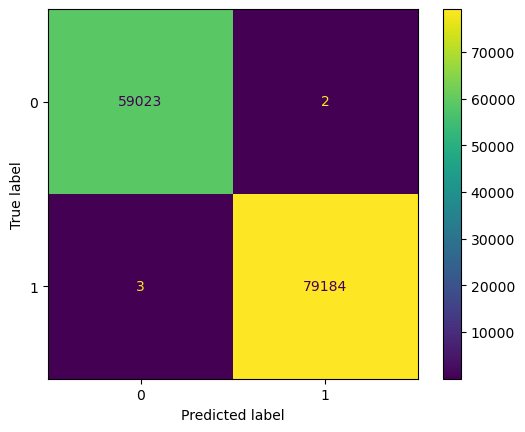

In [227]:
print("Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(ytrain,trainpred)
plt.show()

Test Confusion Matrix


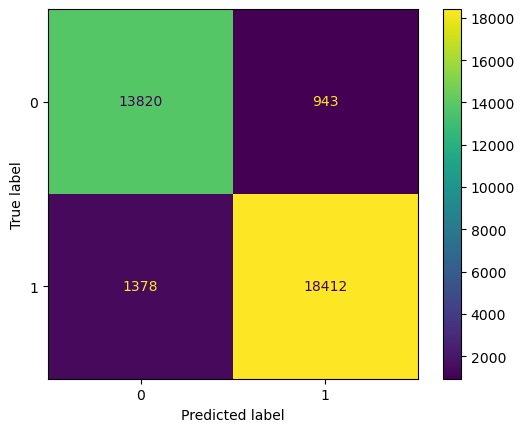

In [228]:
print("Test Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(ytest,testpred)
plt.show()

Train roc auc curve


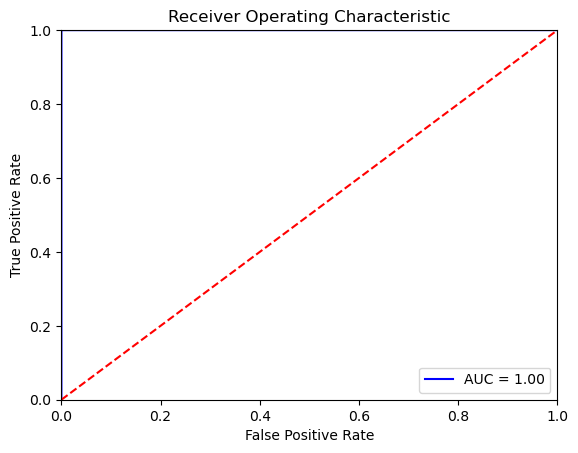

In [236]:
print("Train roc auc curve")
probs = bag_dt.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytrain, trainpred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Test roc auc curve


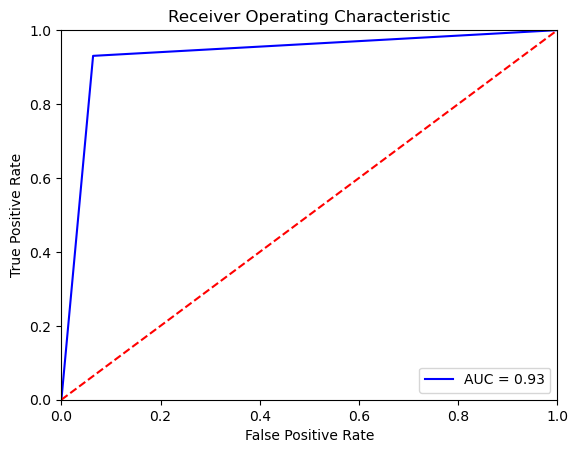

In [237]:
print("Test roc auc curve")
probs = bag_dt.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, testpred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ` second`


**COLUMNS**  :"Delivery Status", "Type", "Customer Segment", "Department Name", "Market", 
        "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"
        
**Scalling** - MinMax Scaller

**Encoder**	- Category Encoders

**Model Name**	- Decision Tree Classifier with Bagging

**Model Parameters**	- DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10) BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)

In [22]:
logical_df=df[["Delivery Status", "Type", "Customer Segment", "Department Name", "Market", 
        "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"]]

In [23]:
num = logical_df.select_dtypes(exclude="O")
cat = logical_df.select_dtypes(include="O").drop("Delivery Status",axis=1)

In [24]:
mm_scaller = MinMaxScaler()
num = pd.DataFrame(mm_scaller.fit_transform(num),columns=['Order Date', 'Order Month','Distance(KM)'])
num

,Order Date,Order Month,Distance(KM)
0,1.000000,0.0,0.961541
1,0.400000,0.0,0.690818
2,0.400000,0.0,0.655708
3,0.400000,0.0,0.604800
4,0.400000,0.0,0.862176
...,...,...,...
172760,0.500000,0.0,0.618617
172761,0.500000,0.0,0.470561
172762,0.466667,0.0,0.893788
172763,0.466667,0.0,0.881053


In [25]:
y = df["Delivery Status"].replace({"Shipping on time":0,"Late delivery":1})
cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(cat, y) 
cat = cbe_encoder.transform(cat)
cat

,Type,Customer Segment,Department Name,Market,Shipping Mode,Order Time
0,0.572177,0.573116,0.580031,0.573753,0.397693,0.564656
1,0.574782,0.573116,0.580031,0.573753,0.397693,0.606530
2,0.566324,0.573116,0.580031,0.573753,0.397693,0.606530
3,0.572177,0.575883,0.580031,0.573753,0.397693,0.539406
4,0.575291,0.570781,0.580031,0.573753,0.397693,0.539406
...,...,...,...,...,...,...
172760,0.566324,0.575883,0.571939,0.573753,0.397693,0.564656
172761,0.572177,0.570781,0.571939,0.573753,0.798284,0.564656
172762,0.574782,0.570781,0.571939,0.573753,0.397693,0.564656
172763,0.575291,0.573116,0.571939,0.573753,0.397693,0.599777


In [27]:
x = pd.concat([num,cat],axis=1)
x

,Order Date,Order Month,Distance(KM),Type,Customer Segment,Department Name,Market,Shipping Mode,Order Time
0,1.000000,0.0,0.961541,0.572177,0.573116,0.580031,0.573753,0.397693,0.564656
1,0.400000,0.0,0.690818,0.574782,0.573116,0.580031,0.573753,0.397693,0.606530
2,0.400000,0.0,0.655708,0.566324,0.573116,0.580031,0.573753,0.397693,0.606530
3,0.400000,0.0,0.604800,0.572177,0.575883,0.580031,0.573753,0.397693,0.539406
4,0.400000,0.0,0.862176,0.575291,0.570781,0.580031,0.573753,0.397693,0.539406
...,...,...,...,...,...,...,...,...,...
172760,0.500000,0.0,0.618617,0.566324,0.575883,0.571939,0.573753,0.397693,0.564656
172761,0.500000,0.0,0.470561,0.572177,0.570781,0.571939,0.573753,0.798284,0.564656
172762,0.466667,0.0,0.893788,0.574782,0.570781,0.571939,0.573753,0.397693,0.564656
172763,0.466667,0.0,0.881053,0.575291,0.573116,0.571939,0.573753,0.397693,0.599777


In [28]:
xtrain,xtest,ytrain,ytest = train_test_split(x ,y ,test_size=0.20,random_state=10,
                                                 shuffle=True,)

In [51]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10,)
dt_model=dt.fit(xtrain,ytrain)
trainpred = dt_model.predict(xtrain)
testpred = dt_model.predict(xtest)
print(accuracy_score(ytrain,trainpred))
print(accuracy_score(ytest,testpred))

0.9998770005498799
0.9317570109686568


In [29]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
bag_dt.fit(xtrain,ytrain)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=80,
                                                   random_state=10),
                  n_estimators=50, random_state=10)

In [30]:
trainpred = bag_dt.predict(xtrain)
testpred = bag_dt.predict(xtest)
print(accuracy_score(ytrain,trainpred))
print(accuracy_score(ytest,testpred))

0.9999493531675976
0.944954128440367


In [32]:
print("Train Classification Report")
print(classification_report(ytrain,trainpred))

Train Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59025
           1       1.00      1.00      1.00     79187

    accuracy                           1.00    138212
   macro avg       1.00      1.00      1.00    138212
weighted avg       1.00      1.00      1.00    138212



In [33]:
print("Test Classification Report")
print(classification_report(ytest,testpred))

Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     14763
           1       0.96      0.94      0.95     19790

    accuracy                           0.94     34553
   macro avg       0.94      0.95      0.94     34553
weighted avg       0.95      0.94      0.95     34553



Train Confusion Matrix


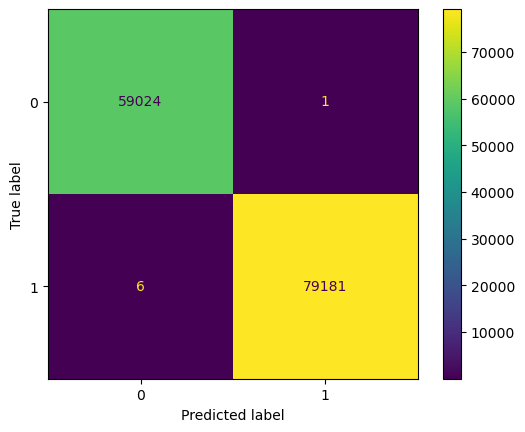

In [34]:
print("Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(ytrain,trainpred)
plt.show()

Test Confusion Matrix


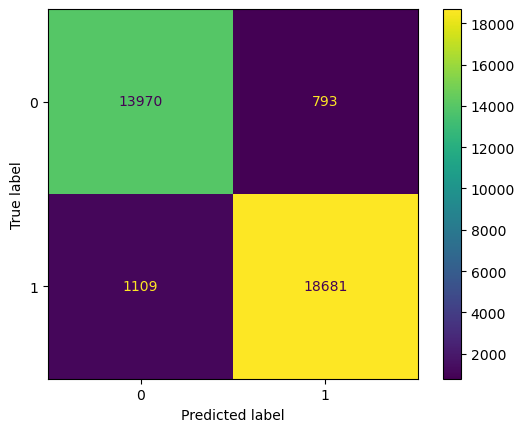

In [35]:
print("Test Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(ytest,testpred)
plt.show()

Train roc auc curve 


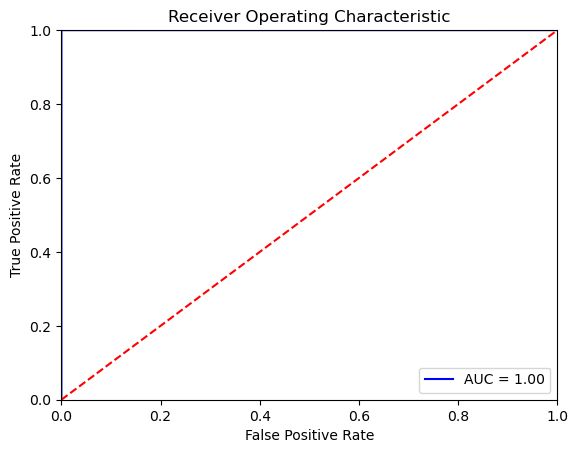

In [36]:
print("Train roc auc curve ")
probs = bag_dt.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytrain, trainpred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Test roc auc curve


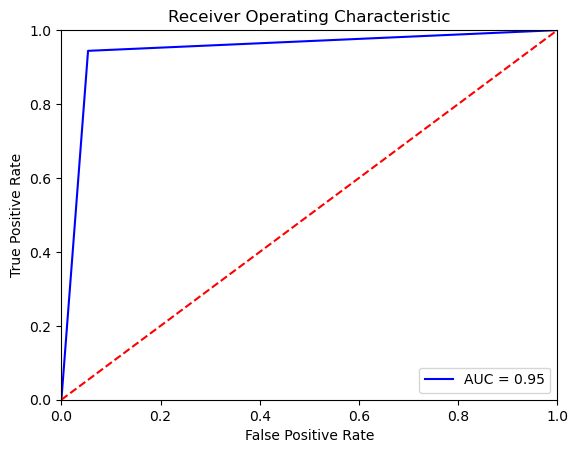

In [37]:
print("Test roc auc curve")
probs = bag_dt.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, testpred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# `CONCLUSION`

From the above two models after analysing the model, we are going forward with the following. 

**COLUMNS**  :"Delivery Status", "Type", "Customer Segment", "Department Name", "Market", 
        "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"
        
**Scalling** - MinMax Scaller

**Encoder**	- Category Encoders

**Model Name**	- Decision Tree Classifier with Bagging

**Model Parameters**	- DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10) BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)



In [50]:
log_df = df[["Delivery Status", "Type", "Customer Segment", "Department Name", "Market", 
        "Shipping Mode", "Order Date", "Order Month", "Order Time", "Distance(KM)"]]
log_df

,Delivery Status,Type,Customer Segment,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Time,Distance(KM)
0,Shipping on time,DEBIT,Consumer,Fitness,Pacific Asia,Standard Class,31,1,Night,18481.922336
1,Late delivery,TRANSFER,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,13278.496831
2,Shipping on time,CASH,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,12603.663952
3,Shipping on time,DEBIT,Home Office,Fitness,Pacific Asia,Standard Class,13,1,Morining,11625.195512
4,Shipping on time,PAYMENT,Corporate,Fitness,Pacific Asia,Standard Class,13,1,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,CASH,Home Office,Fan Shop,Pacific Asia,Standard Class,16,1,Night,11890.757350
172761,Late delivery,DEBIT,Corporate,Fan Shop,Pacific Asia,Second Class,16,1,Night,9045.058811
172762,Late delivery,TRANSFER,Corporate,Fan Shop,Pacific Asia,Standard Class,15,1,Night,17179.672776
172763,Shipping on time,PAYMENT,Consumer,Fan Shop,Pacific Asia,Standard Class,15,1,Evening,16934.899555


In [51]:
log_df.to_csv('SupplyChainDataset_1.csv', index=False)

In [53]:
log_df = pd.read_csv("SupplyChainDataset_1.csv")
log_df

,Delivery Status,Type,Customer Segment,Department Name,Market,Shipping Mode,Order Date,Order Month,Order Time,Distance(KM)
0,Shipping on time,DEBIT,Consumer,Fitness,Pacific Asia,Standard Class,31,1,Night,18481.922336
1,Late delivery,TRANSFER,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,13278.496831
2,Shipping on time,CASH,Consumer,Fitness,Pacific Asia,Standard Class,13,1,Afternoon,12603.663952
3,Shipping on time,DEBIT,Home Office,Fitness,Pacific Asia,Standard Class,13,1,Morining,11625.195512
4,Shipping on time,PAYMENT,Corporate,Fitness,Pacific Asia,Standard Class,13,1,Morining,16572.070499
...,...,...,...,...,...,...,...,...,...,...
172760,Shipping on time,CASH,Home Office,Fan Shop,Pacific Asia,Standard Class,16,1,Night,11890.757350
172761,Late delivery,DEBIT,Corporate,Fan Shop,Pacific Asia,Second Class,16,1,Night,9045.058811
172762,Late delivery,TRANSFER,Corporate,Fan Shop,Pacific Asia,Standard Class,15,1,Night,17179.672776
172763,Shipping on time,PAYMENT,Consumer,Fan Shop,Pacific Asia,Standard Class,15,1,Evening,16934.899555


In [54]:
num = logical_df.select_dtypes(exclude="O")
cat = logical_df.select_dtypes(include="O").drop("Delivery Status",axis=1)

In [55]:
mm_scaller = MinMaxScaler()
num = pd.DataFrame(mm_scaller.fit_transform(num),columns=['Order Date', 'Order Month','Distance(KM)'])
num

,Order Date,Order Month,Distance(KM)
0,1.000000,0.0,0.961541
1,0.400000,0.0,0.690818
2,0.400000,0.0,0.655708
3,0.400000,0.0,0.604800
4,0.400000,0.0,0.862176
...,...,...,...
172760,0.500000,0.0,0.618617
172761,0.500000,0.0,0.470561
172762,0.466667,0.0,0.893788
172763,0.466667,0.0,0.881053


In [56]:
y = df["Delivery Status"].replace({"Shipping on time":0,"Late delivery":1})

In [57]:
cbe_encoder = ce.cat_boost.CatBoostEncoder() 
cbe_encoder.fit(cat, y) 
cat = cbe_encoder.transform(cat)
cat

,Type,Customer Segment,Department Name,Market,Shipping Mode,Order Time
0,0.572177,0.573116,0.580031,0.573753,0.397693,0.564656
1,0.574782,0.573116,0.580031,0.573753,0.397693,0.606530
2,0.566324,0.573116,0.580031,0.573753,0.397693,0.606530
3,0.572177,0.575883,0.580031,0.573753,0.397693,0.539406
4,0.575291,0.570781,0.580031,0.573753,0.397693,0.539406
...,...,...,...,...,...,...
172760,0.566324,0.575883,0.571939,0.573753,0.397693,0.564656
172761,0.572177,0.570781,0.571939,0.573753,0.798284,0.564656
172762,0.574782,0.570781,0.571939,0.573753,0.397693,0.564656
172763,0.575291,0.573116,0.571939,0.573753,0.397693,0.599777


In [58]:
x = pd.concat([num,cat],axis=1)
x

,Order Date,Order Month,Distance(KM),Type,Customer Segment,Department Name,Market,Shipping Mode,Order Time
0,1.000000,0.0,0.961541,0.572177,0.573116,0.580031,0.573753,0.397693,0.564656
1,0.400000,0.0,0.690818,0.574782,0.573116,0.580031,0.573753,0.397693,0.606530
2,0.400000,0.0,0.655708,0.566324,0.573116,0.580031,0.573753,0.397693,0.606530
3,0.400000,0.0,0.604800,0.572177,0.575883,0.580031,0.573753,0.397693,0.539406
4,0.400000,0.0,0.862176,0.575291,0.570781,0.580031,0.573753,0.397693,0.539406
...,...,...,...,...,...,...,...,...,...
172760,0.500000,0.0,0.618617,0.566324,0.575883,0.571939,0.573753,0.397693,0.564656
172761,0.500000,0.0,0.470561,0.572177,0.570781,0.571939,0.573753,0.798284,0.564656
172762,0.466667,0.0,0.893788,0.574782,0.570781,0.571939,0.573753,0.397693,0.564656
172763,0.466667,0.0,0.881053,0.575291,0.573116,0.571939,0.573753,0.397693,0.599777


In [59]:
xtrain,xtest,ytrain,ytest = train_test_split(x ,y ,test_size=0.20,random_state=10,
                                                 shuffle=True,)

In [60]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=80,min_samples_leaf=1,min_samples_split=2,random_state=10)
bag_dt = BaggingClassifier(estimator=dt,n_estimators=50,random_state=10)
bag_dt.fit(xtrain,ytrain)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=80,
                                                   random_state=10),
                  n_estimators=50, random_state=10)

# `deploying the selected model`

In [63]:
with open('bag_dt.pkl', 'wb') as model_file:
    pickle.dump((bag_dt, mm_scaller, cbe_encoder), model_file)

In [32]:
with open('bag_dt.pkl', 'rb') as model_file:
    model, mm_scaller, cbe_encoder = pickle.load(model_file)

In [73]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
import pickle
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

st.title("Late Delivery Risk Web App")
st.header('',divider='rainbow')
st.subheader("Will your delivery be late?")

image = Image.open(r'dashboard.jpeg')
st.image(image)

with open('bag_dt.pkl', 'rb') as model_file:
    model, scaler, encoder = pickle.load(model_file)


orddate = st.slider('Order Date',0,31,0)
ordmon = st.slider('Order Month',0,12,0)
dist = st.number_input("Distance(KM)")


types = ['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT']
typ = st.selectbox("Type",types)

segment = ['Consumer', 'Home Office', 'Corporate']
seg = st.selectbox("Customer Segment",segment)

dep_name = ['Fitness','Apparel','Golf','Footwear','Outdoors','Fan Shop','Technology','Book Shop','Discs Shop',
            'Pet Shop','Health and Beauty ']
dep_nam = st.selectbox("Department Name",dep_name)

market = ['Pacific Asia', 'USCA', 'Africa', 'Europe', 'LATAM']
mar = st.selectbox("Market",market)

ship_mode = ['Standard Class', 'First Class', 'Second Class', 'Same Day']
ship = st.selectbox("Shipping Mode",ship_mode)

ord_time = ['Night', 'Afternoon', 'Morining', 'Evening']
ordtime = st.selectbox("Order Time",ord_time)


c = encoder.transform(pd.DataFrame([[typ,seg,dep_nam,mar,ship,ordtime]],
             columns=['Type','Customer Segment','Department Name','Market','Shipping Mode','Order Time']))

n = pd.DataFrame(scaler.transform([[orddate,ordmon,dist]]),
                 columns=['Order Date', 'Order Month', 'Distance(KM)'])

input_data = pd.concat([n,c],axis=1)

# Step 4: Get the prediction and print the result
prediction = model.predict(input_data)[0]
if st.button("Predict"):
    if prediction == 0:
        st.subheader("Shipping on time")
    else:
        st.subheader("Late delivery")


Overwriting app.py


In [75]:
import pandas
import numpy
import streamlit as st
import sklearn
import catboost
import PIL

In [76]:
print("pandas",pd.__version__)
print("Numpy",np.__version__)
print("Streamlit",st.__version__)
print("Sklearn",sklearn.__version__)
print("Catboost",catboost.__version__)
print("PIL",PIL.__version__)

pandas 1.5.3
Numpy 1.23.5
Streamlit 1.28.0
Sklearn 1.2.1
Catboost 1.2.2
PIL 9.4.0
